# ANALISIS DE RIESGOS: Forecast

En este notebook se crea un modelo para el PHA dadas unas situaciones atmosféricas.

In [1]:
#  Manejo de datos
import pandas as pd

#  Análisis de datos
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

#  Auxiliares
#  Numéricos
import numpy as np
#  Texto
import re

#  Representaciones gráficas
#  Graficos
import matplotlib.pyplot as plt
#  Mapas
import geopandas
import folium
from folium import plugins

## OBTENCIÓN DE DATOS

A continuación se carga en un dataframe los datos extraídos de la fuente de estudio guardados en formato parquet por su gran volumen de datos.

In [2]:
# Directorio de los datos
data_dir = 'Datasets/PHA/'
pha_file = 'PHA_Data.parquet'
legend_file = 'column_info.csv'

In [3]:
# Lectura del fichero .parquet creado todo el conjunto de datos
data_df = pd.read_parquet(data_dir + pha_file, engine='pyarrow')

# Dataframe y diccionario leyenda de las columnas
df_legend = pd.read_csv(data_dir + legend_file)
leyend_dict = dict(zip(df_legend['Column_name'], df_legend['Description']))

## EXPLORATORY DATA ANALYSIS (EDA)

<h4><div style="font-size:14px; text-align:center"><b>REDUCCIÓN DE DIMENSIONALIDAD</b><br></div></h4>

Dado que el numero de columnas es elevado y alguna de estas no aporta información a nuestro caso de estudio, se realiza primero la selección de los atributos de estudio dejando así un dataframe que sea más reducido en cuanto a sus atributos de partida para poder trabajar el analisis de datos con mayor facilidad.

<h5><div style="font-size:14px; text-align:left"><b>CORRELACION DE ATRIBUTOS</b><br></div></h5>

<p>Como primer estudio para ver la relación de los datos y ayudarnos a tomar la decisión de los atributos a seleccionar, se observa la relación de las columnas de forma gráfica. Esto es, la dependencia que tiene una columna con repecto a las otras si estas varian.</p>
<p>Para este estudio, se emplea el metodo <i>corr</i> de Pandas. Pero, previamente se requiere codificar las variables no numéricas ya que esta función, únicamente actúa sobre las columnas numéricas, y es este momento, queremos ver la relación de todas las columnas. Para ello, se hace uso del modulo <i>preprocessing</i> de <b>scikit-learn</b>. Con este modulo se puede hacer uso de métodos que nos permitirá codificar los atributos categóricas a numéricos.<br>
    Se utiliza el encoder <b>OrdinalEncoder</b> que transforma el valor en el ordinal para la columna, dando como resultado valores numericos de 0 a n-1 caracterisitica.</p>

In [4]:
# Instancia del codificador
oe = preprocessing.OrdinalEncoder()

# Ajuste del modelo (fit) y codificación de los datos (transform)
oe.fit(data_df)
data_encoded = oe.transform(data_df)

# Crear un dataframe auxiliar con los atributos y valores transformados
names = oe.get_feature_names_out()
df_encoded = pd.DataFrame(data_encoded, columns=names)
df_encoded

c1    c6    c7    c8     c10  c132  c134  c136  c138  c141  ...  \
0       0.0   1.0   0.0   0.0  1937.0  26.0  17.0  26.0  14.0   9.0  ...   
1       0.0   1.0   0.0   0.0  1937.0  26.0  17.0  26.0  14.0   9.0  ...   
2       0.0   1.0   0.0   0.0  1937.0  26.0  17.0  26.0  14.0   9.0  ...   
3       0.0   1.0   0.0   0.0  1937.0  26.0  17.0  26.0  14.0   9.0  ...   
4       0.0   1.0   0.0   0.0  1937.0  26.0  17.0  26.0  14.0   9.0  ...   
...     ...   ...   ...   ...     ...   ...   ...   ...   ...   ...  ...   
214659  3.0  48.0   1.0   5.0  1100.0  26.0  17.0  26.0  14.0   9.0  ...   
214660  3.0  48.0   1.0   6.0   967.0  26.0  17.0  26.0  14.0   9.0  ...   
214661  3.0  48.0   0.0  30.0   519.0  26.0  17.0  26.0  14.0   9.0  ...   
214662  3.0  48.0   0.0   6.0   251.0  26.0  17.0  26.0  14.0   9.0  ...   
214663  0.0  47.0  10.0  17.0   714.0  26.0  17.0  26.0  14.0   9.0  ...   

        c150  c154  c156  c158  c161  c163  c183  c191    c229    c230  
0        2.0   2.0  11.0  13.0  33.0  33.0   1.0   1.0     NaN     NaN  
1        2.0   2.0  11.0  12.0  33.0  33.0   1.0   1.0     NaN     NaN  
2        2.0   2.0  11.0  12.0  33.0  33.0   1.0   1.0     NaN     NaN  
3        2.0   2.0  11.0  12.0  33.0  33.0   1.0   1.0     NaN     NaN  
4        2.0   2.0  11.0  13.0  33.0  33.0   1.0   1.0     NaN     NaN  
...      ...   ...   ...   ...   ...   ...   ...   ...     ...     ...  
214659   3.0   2.0  11.0  12.0  33.0  33.0   1.0   1.0  5275.0     NaN  
214660   2.0   2.0  11.0  12.0  33.0  33.0   1.0   1.0  3582.0     NaN  
214661   3.0   2.0  11.0  12.0  33.0  33.0   1.0   1.0  6608.0  1257.0  
214662   3.0   2.0  11.0  12.0  33.0  33.0   1.0   1.0  2107.0     NaN  
214663   3.0   2.0  11.0  11.0  33.0  33.0   1.0   1.0  2770.0     NaN  

[214664 rows x 149 columns]

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Atributos mapeados a numéricos</i></div>

In [5]:
corr = df_encoded.corr()
corr.style.background_gradient(cmap='Blues')

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Matriz de correlacion de atributos.</i></div>

In [6]:
# Eliminar la diagonal principal y los valores debajo de esta, manteniendo solo los valores superiores
# para ver solo valores unicos diferentes de 1 (relacion con diferentes atributos)
corr_filter = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool_))

# Ordenar de mayor a menor
corr_sort = corr_filter.stack().sort_values(ascending=False).to_frame()

# Añadir nombres a las columnas para entender las relaciones
corr_sort = corr_sort.rename(columns=leyend_dict, index=leyend_dict)

corr_sort.head(60)

0
Including crew and passengers.                     Number of passengers onboard                        0.999322
Region of the air operator                         District office of the air operator                 0.994042
Region of the accident/incident location.          District office of the accident/incident location.  0.986830
Code for Weight  Class                             Powered, Nonpowered, Optional                       0.969616
Under or over 750 hp.                              Type of engine.                                     0.967706
Type of the engine code.                           Piston, turbine, turboprop, etc.                    0.960989
Residence region code of the pilot in command      Residence district office code of the pilot in ...  0.958168
Under or over 750 hp.                              Type of the engine code.                            0.951808
Type of the engine code.                           Type of engine.                                     0.947604
                                                   Text for element C153.                              0.940691
Latitude coordinates of the accident/incident      Longitude coordinates of the accident/incident      0.939748
Second remedial action area code                   Second remedial action area text                    0.938856
                                                   Second remedial action taken code                   0.932946
Number of passengers injured                       All injuries including crew passengers and public.  0.929659
Second persons involved code                       Supporting cause factor B code.            OPER...  0.926073
Number of passengers killed                        Total Fatalities                                    0.924392
Second remedial action taken code                  Second remedial action area text                    0.921989
Persons involved code                              Supporting cause factor A code.            OPER...  0.918476
Piston, turbine, turboprop, etc.                   Type of engine.                                     0.913665
Under or over 750 hp.                              Piston, turbine, turboprop, etc.                    0.913075
Second persons involved code                       Second contributing factor text                     0.906583
Code for Aircraft Design                           Wing information of the aircraft involved in th...  0.900926
Piston, turbine, turboprop, etc.                   Text for element C153.                              0.900355
Powered, Nonpowered, Optional                      Text for element C150                               0.899042
Supporting factor code                         ... Supporting factor text                         ...  0.895825
Wing information of the aircraft involved in th... Powered, Nonpowered, Optional                       0.887031
Code for Weight  Class                             Wing information of the aircraft involved in th...  0.884601
Persons involved code                              Persons involved text                               0.884581
Supporting cause factor A code.            OPER... Persons involved text                               0.879966
Supporting cause factor B code.            OPER... Second contributing factor text                     0.879617
Powered, Nonpowered, Optional                      Wing information of the aircraft text               0.877517
Under or over 750 hp.                              Certificating region of the engine                  0.875991
Persons involved code                              Contributing factor text                            0.873574
Type of the engine code.                           Certificating region of the engine                  0.867094
Code for Weight  Class                             Code representing typical engine design charact...  0.863927
                                                   Wing information of the air

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>60 primeras correlaciones.</i></div>

<p>Las primeras 60 correlaciones que se obtiene hace referencia a atributos que no son relevantes para el caso de estudio de este modelo. Como se ve, en gran parte hace referencia a personas muertas o heridas en los sucesos, dando una gran correlacion a las personas tripulantes y pasajeros, que por razones obvias, se tiene una gran correlación.<br>
    Para seguir con el estudio de la correlación, se muestra otro fragmento de resultados.</p>

In [7]:
# Siguientes 60 resultados
corr_sort.iloc[60:120]

0
Primary type of flying code                        Primary flying condition code                       0.785883
Code for Aircraft Design                           Powered, Nonpowered, Optional                       0.785133
Wing information of the aircraft involved in th... Text for element C150                               0.774048
Total number of hours in the last 90 days the p... Total number of hours in the last 90 days the p...  0.770009
Second supporting factor code .               T... Second cause factor text                            0.769300
Primary type of flying code                        Light condition text                                0.767437
Wing information of the aircraft text              Text for element C150                               0.762513
Primary type of flying code                        Secondary type of flying code                       0.761877
Primary flying condition code                      General cause category code                         0.761451
Second remedial action area text                   Second remedial action taken text                   0.759669
Primary flying condition code                      Light condition text                                0.758806
Certificate number of the air agency               District office of the air operator                 0.758416
Primary type of flying code                        General cause category code                         0.752481
Year the accident/incident happened.               Qualification code of the pilot in command .        0.748940
General cause category code                        General cause category text                         0.742242
Powered, Nonpowered, Optional                      Code representing typical engine design charact...  0.737555
Make of the engine                                 Model of the engine                                 0.734207
Second remedial action area code                   Second remedial action taken text                   0.734046
Certificate number of the air agency               Region of the air operator                          0.729220
Powered, Nonpowered, Optional                      Aid Text                                            0.725186
Second cause factor text                           Second supporting factor text                  ...  0.722129
Second contributing case code f                    Second persons involved code                        0.721485
Wind direction                                     Wind speed in miles per hours                       0.713187
Wing information of the aircraft involved in th... Code representing typical engine design charact...  0.712037
Secondary cause factor code                        Second cause factor text                            0.709523
Group of the aircraft                              Region of certification for the aircraft            0.708361
Code representing typical engine design charact... Wing information of the aircraft text               0.707777
Code for Aircraft Design                           Wing information of the aircraft text               0.707625
Wing information of the aircraft involved in th... Low wing, high wing, rotary wing, etc.              0.707518
Primary type of flying code                        Type of accident code                               0.699291
Contributing factor code                           Contributing factor text                            0.695022
Under or over 750 hp.                              Make of the engine                                  0.694418
Primary type of flying code                        Rating description of the pilot in command          0.691014
Primary type of flying text                        Secondary type of flying text                       0.687593
State of the owner / operator                      Certificate number of the air agency                0.685613
Second contributing case code f                    Supporting cause factor B c

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Segundo grupo de correlaciones.</i></div>

<p>Las siguientes correlaciones, ya aporta u nmayor numero de relacione sinterresantes para el estudio del modelo. Se puede extraer que las <b>Primary flying condition</b> tienen una importante correlación con el resultado del suceso.<br>
    Además, se observa que atributos climáticos como <b>velocidad y direccion del viento</b> toman relevancia en la relación de atributos.<br>
    También se observa que el tipo de vuelo y la calificación del piloto tienen cierta relación. Esto se considera interesante ya que se entiende de la calificación/experiencia de un piloto puede ser determinante en determinadas situaciones climáticas.<br>
    Para seguir con el estudio de la correlación, se muestra otro fragmento de resultados.</p>

In [8]:
# Siguientes 60 resultados
corr_sort.iloc[120:180]

0
State of the owner / operator                      Region of the air operator                          0.642507
Rating description of the pilot in command         Any other rating description of the pilot in co...  0.642503
Secondary flying condition code                    Secondary flying condition text                     0.642084
General cause category code                        Primary flying condition text                       0.641682
Primary flying condition code                      Rating description of the pilot in command          0.639773
Year the accident/incident happened.               Primary type of flying code                         0.639728
Code for Aircraft Design                           Low wing, high wing, rotary wing, etc.              0.638445
Make of the engine                                 Piston, turbine, turboprop, etc.                    0.636906
Qualification code of the pilot in command .       Light condition text                                0.631259
Primary flying condition code                      Type of accident code                               0.630292
Supporting cause factor A code.            OPER... Supporting Factor Text                         ...  0.627523
Code for Weight  Class                             Aid Text                                            0.621231
Group of the aircraft                              Low wing, high wing, rotary wing, etc.              0.618484
General cause category code                        Any other rating description of the pilot in co...  0.618110
Sky condition code                                 Wind direction                                      0.615710
Contributing factor code                           Persons involved code                               0.611084
Primary flying condition code                      Secondary flying condition code                     0.610887
Qualification code of the pilot in command .       General cause category code                         0.610070
Make of the engine                                 Text for element C153.                              0.609853
Sky condition code                                 Wind speed in miles per hours                       0.608882
Rating description of the pilot in command         Light condition text                                0.606178
Primary flying condition code                      Any other rating description of the pilot in co...  0.606139
Profession code of the pilot in command            Any other rating description of the pilot in co...  0.605513
Model of the aircraft                              Group of the aircraft                               0.605425
General cause category code                        Rating description of the pilot in command          0.603962
Qualification code of the pilot in command .       Profession code of the pilot in command             0.601655
Airworthiness class code of the aircraft           This field contains the year of manufacture of ...  0.601494
Primary flying condition code                      General cause category text                         0.601327
First remedial action area code                    First remedial action taken code                    0.601279
Qualification code of the pilot in command .       Rating description of the pilot in command          0.600971
Primary flying condition code                      Primary flying condition text                       0.599709
Type of accident code                              Light condition text                                0.594636
Low wing, high wing, rotary wing, etc.             Primary type of flying code                         0.594010
Contributing factor code                           Supporting cause factor A code.            OPER...  0.592817
Wing information of the aircraft involved in th... Aid Text                                            0.592628
Year the accident/incident happened.               Number of flight crew membe

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Tercer grupo de correlaciones.</i></div>

<h5><div style="font-size:14px; text-align:left"><b>SELECCIÓN DE ATRIBUTOS</b><br></div></h5>

<p>Finalmente, se observa como nuevamente toma peso las condiciones climaticas así como las condiciones del vuelo y la calificación del piloto.</p>
<p>Teniendo en cuenta las correlaciones y el modelo de datos necesario para la predicción, las columnas seleccionadas han sido decididas en base a:
<ul>
    <li>Condiciones atmosfericas como: visibilidad, viento, altura de las nubes.</li>
    <li>Condiciones básicas del avión como: aeronavegabilidad del avión, horas de vuelo o antiguedad del avión.</li>
    <li>Aptitudes del piloto como: horas de vuelo o tipo de piloto.</li>
    <li>Condiciones primarias de vuelo, fase de vuelo.</li>
</ul>
</p>

In [9]:
def col_name(col: str):
    """
    Nombre de la columna
    """
    return df_legend[df_legend["Column_name"] == col]["Description"].values[0]

def clean_data(value):
    """
    Limpieza de los datos None a NaN. Si es un String, eliminar espacios finales e iniciales
    """
    # Si se trata de un valor en blanco sustituir a NaN
    try:
        # si es un string, eliminar espacios
        if isinstance(value, str):
            value = value.strip()
        
        if value in [None, 'nan', 'N/A', pd.NA]:
            return np.NaN
        
        return value

    except Exception as e:
        return value

In [10]:
# Columnas seleccionadas
columns = [1, 6, 7, 10, 11, 12, 13, 14, 20, 21, 30, 31, 32, 41, 49, 56, 96, 106, 108, 109, 110, 112, 113, 114, 115, 
           240, 241, 242, 243]
columns = [f'c{col}' for col in columns]
for col in columns:
    print(f'[+] SELECTED_COL\t{col}\t{col_name(col)}')

# Eliminar columnas indeseadas
df = data_df.drop(columns=[col for col in data_df.columns if col not in columns])
    
# Iterar sobre todas las columnas y comprobar sus valores
columns = len(df.columns)
print('\n')

for column in df.columns:
    # Utilizar compresion de listas y aplicar el filtrado de valores
    values = [clean_data(value) for value in df[column]]
    df[column] = values
    columns -= 1
    print(f'[+] REMAINING_CLEANING\t{columns}\t', end='\r')
print(' '*50)
    
df

[+] SELECTED_COL	c1	Type of Event
[+] SELECTED_COL	c6	Year the accident/incident happened.
[+] SELECTED_COL	c7	Month the accident/incident happened.
[+] SELECTED_COL	c10	Local time of the accident/incident.
[+] SELECTED_COL	c11	Region of the accident/incident location.
[+] SELECTED_COL	c12	District office of the accident/incident location.
[+] SELECTED_COL	c13	State of the accident/incident location.
[+] SELECTED_COL	c14	City of the accident/incident location.
[+] SELECTED_COL	c20	Latitude coordinates of the accident/incident
[+] SELECTED_COL	c21	Longitude coordinates of the accident/incident
[+] SELECTED_COL	c30	Airworthiness class code of the aircraft
[+] SELECTED_COL	c31	Airframe hours of the aircraft
[+] SELECTED_COL	c32	This field contains the year of manufacture of the aircraft
[+] SELECTED_COL	c41	Certificate type code of the pilot in command
[+] SELECTED_COL	c49	Qualification code of the pilot in command .
[+] SELECTED_COL	c56	Total number of hours the pilot has flown.
[+] SELE

c1    c6  c7   c10   c30   c31 c32 c11   c12 c13  ... c115 c240 c241  \
0       A  1975   1   NaN  STRD   NaN   *  CE  CE11  MO  ...  NaN  NaN  NaN   
1       A  1975   1   NaN  STRD   NaN   *  GL  GL19  IL  ...  NaN  NaN  NaN   
2       A  1975   1   NaN   NaN   NaN   *  SO  SO62  TN  ...  NaN  NaN  NaN   
3       A  1975   1   NaN   NaN   NaN   *  GL  GL18  IN  ...  NaN  NaN  NaN   
4       A  1975   1   NaN  STRD   NaN   *  NW  NW02  OR  ...  NaN  NaN  NaN   
...    ..   ...  ..   ...   ...   ...  ..  ..   ...  ..  ...  ...  ...  ...   
214659  I  2022   2  1710   NaN   929   *  CE  CE19  TN  ...  NaN  NaN  NaN   
214660  I  2022   2  1505  STRD  1823   *  GL  GL05  OH  ...  NaN  NaN  NaN   
214661  I  2022   1  0832  STRD   970   *  NM  NM07  UT  ...  NaN  NaN  NaN   
214662  I  2022   1  0407  STRD   NaN   *  WP  WP17  NY  ...  NaN  NaN  NaN   
214663  A  2021  11  1130  STRD  1532   *  EA  EA13  PA  ...  NaN  NaN  NaN   

       c242 c243  c41  c49      c56 c96  c109  
0       NaN  NaN   03    E   1187.0  IB  Dusk  
1       NaN  NaN   03    G    364.0  DD   Day  
2       NaN  NaN   01    G    205.0  DD  Dawn  
3       NaN  NaN   01    G     95.0  HB   Day  
4       NaN  NaN   03    G    233.0  IA   Day  
...     ...  ...  ...  ...      ...  ..   ...  
214659  NaN  NaN   01  NaN     90.0  TC   NaN  
214660  NaN  NaN   01  NaN    413.0  LR   NaN  
214661  NaN  NaN   03  NaN   1551.0  TD   NaN  
214662  NaN  NaN   09  NaN  14190.0  LT   NaN  
214663  NaN  NaN   01  NaN    609.0  LA   NaN  

[214664 rows x 29 columns]

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Caracteristicas seleccionadas.</i></div>

<h4><div style="font-size:14px; text-align:center"><b>ANÁLISIS CONJUNTO DE DATOS</b><br></div></h4>

<p>Para tener un contexto de los datos que se tiene, se realiza una serie de visualización de datos.</p>
<p>La primera de estas acciones consiste en describir los datos que tenemos, en su tipo y cuántos de estos datos son válidos, o al menos, no desconocidos (NaN)</p>

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214664 entries, 0 to 214663
Data columns (total 29 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   c1      214635 non-null  object 
 1   c6      214664 non-null  int64  
 2   c7      214632 non-null  object 
 3   c10     193377 non-null  object 
 4   c30     40022 non-null   object 
 5   c31     120371 non-null  object 
 6   c32     46392 non-null   object 
 7   c11     214157 non-null  object 
 8   c12     214073 non-null  object 
 9   c13     213887 non-null  object 
 10  c14     212818 non-null  object 
 11  c20     59517 non-null   object 
 12  c21     59471 non-null   object 
 13  c106    171955 non-null  object 
 14  c108    171696 non-null  object 
 15  c110    168469 non-null  float64
 16  c112    90250 non-null   object 
 17  c113    26396 non-null   object 
 18  c114    88222 non-null   object 
 19  c115    18177 non-null   object 
 20  c240    73644 non-null   object 
 21  c241    72

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Descripción de los datos.</i></div>

De forma gráfica, y desde el concepto de porcebtaje de valores NaN en las columnas, se muestra el siguiente gráfico.

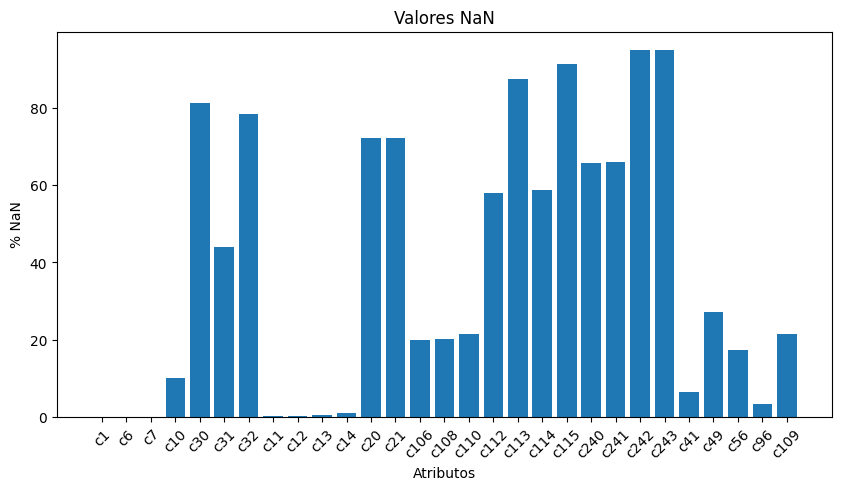

In [12]:
def plot_nan(df):
    """
    Imprimir el porcentaje de valores faltantes
    """
    def df_info_perc(df) -> dict:
        """
        Obtener el porcentaje de datos faltantes para plotear
        """
        # Diccionario con datos
        info_dic = {}
        # Numero de datos faltantes para las diferentes columnas
        rows = len(df)
        # print('\tCOLUMN\tNAN\tPERC')
        for col in df:        
            nan_values = df[col].isna().sum()
            perc = round((nan_values/rows) * 100, 2)
            # print(f'[+]\t{col}\t{nan_values}\t{perc}%')

            # Almacenar datos descriptivos
            info_dic.update({col: perc})

        return info_dic
    # Describir los datos faltantes
    info = df_info_perc(df)

    # Mostrar informacion
    plt.figure(figsize=(10, 5))
    plt.bar(info.keys(), info.values())
    plt.xlabel('Atributos')
    plt.xticks(rotation=45)
    plt.ylabel('% NaN')
    plt.title('Valores NaN')

    plt.show()
    
plot_nan(df)

<div style="font-size:12px; text-align:center"><i><b>Grafico: </b>Porcentaje de valores NaN.</i></div>

El modelo que se desea realizar, debe de ser capaz de predecir el tipo de incidente que ocurrirá. Para ver si tenemos unos datos balanceados, a continuación se muestra una gráfica de la predicción a realizar, en donde podemos observa que si existe un balance de datos.

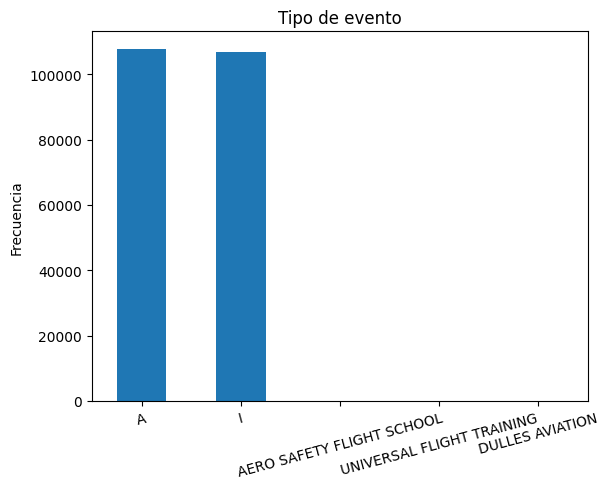

In [13]:
ax = df.c1.value_counts().plot(kind='bar', title='Tipo de evento')

ax.set_ylabel('Frecuencia')

# Rotar nombres de atributos
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(15)

plt.show()

<div style="font-size:12px; text-align:center"><i><b>Grafico: </b>Balanceo de clases.</i></div>

<p>A continuación se muestra el balanceo de datos para la columna del mes del incidente. Teniendo en cuenta el tipo de análisis a realizar, se realiza una previa visualización de la distribución de los sucesos por esta catacteristica.</p>

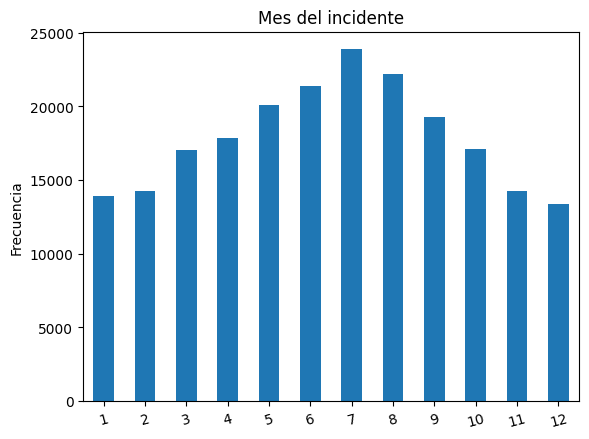

In [14]:
# Obtener la serie de conteos y ordenar los índices alfabéticamente
serie_counts = df.c7.value_counts().sort_index()

# Reordenar los valores de la serie según el nuevo orden de los índices
serie_counts = serie_counts.reindex(serie_counts.index.sort_values())

# Generar el gráfico de barras
ax = serie_counts.plot(kind='bar', title='Mes del incidente')

ax.set_ylabel('Frecuencia')

# Rotar nombres de atributos
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(15)

plt.show()

<div style="font-size:12px; text-align:center"><i><b>Grafico: </b>Frecuencia de sucesos por mes.</i></div>

<p>Se considera de relevancia conocer la ubicación del avion en el momento del suceso, es por esto que se añade los atributos de latitud y longitud al conjunto de características a trabajar en el dataset. No obstante, estos atributos son presentados de forma categórica, por lo que para poder emplearlos, se convierte a numérico.</p>
<p>Esto se debe a que las coordenas están presentados en grados y minutos en su origen, por lo tanto, estos valores se convierten a coordenadas decimales como se presenta a continuación.</p>

In [15]:
def convert_coords(coord):
    """
    Transformar las coordenadas en Grados y Minutos a Coordenadas decimales
    """
    err = 999
    dir_tuple = ('N', 'S', 'E', 'W')
    # Las coordenadas en el dataframe se dan en string. Si no es string, 
    # devolver valor atípico 0
    if isinstance(coord, str):
        # Encontrar los valores numéricos
        coord = coord.strip()        
        match = re.findall(r'[\d.]+', coord)
        
        # Son datos de coordenada válidos
        if not coord.endswith(dir_tuple) or not match:
            return err
        direction = coord[-1:]   
        
        # Si viene Grados y Minutos sin espacio
        if len(match) == 1:
            grade, minute = 0, 0
            if len(match[0]) == 5:
                grade = match[0][:3]
                minute = match[0][3:5]
                
            elif len(match[0]) == 4:
                grade = match[0][:2]
                minute = match[0][2:4]
            
            if grade or minute:
                match = [grade, minute]
            
        # Si viene separado Grados de Minutos
        if len(match) == 2:
            match = [float(match[0]), float(match[1])]
            # Comprobación de Grados
            if direction in ['N', 'S']:
                if match[0] < 0 or 90 < match[0]:
                    return err
            if direction in ['E', 'W']:
                if match[0] < 0 or 180 < match[0]:
                    return err
            # Comprobacion de Minutos
            if match[1] < 0 or 59 < match[1]:
                return err
                
            # Convertir a decimal
            decimal_coord = match[0] + match[1]/60
            
            # Convertir dirección
            return decimal_coord if direction in ['N', 'E'] else decimal_coord * -1
    return err

# Conertir las coordenadas a decimales
df['c20'] = df['c20'].apply(convert_coords)
df['c21'] = df['c21'].apply(convert_coords)

In [16]:
# Crear los puntos geometricos para el mapa a partir de Latitud y Longitud
geometry = geopandas.points_from_xy(df.c20, df.c21)
geo_df = geopandas.GeoDataFrame(df[["c20", "c21"]], geometry=geometry)

# Crear instancia de mapa de folium
geo_map = folium.Map(location=[0, 0], tiles="Cartodb dark_matter", zoom_start=2)

# Crear lista de puntos de coordenadas que sean diferentes a 999
heat_data = [[point.xy[0][0], point.xy[1][0]] for point in geo_df.geometry if point.xy[1][0] != 999 and point.xy[0][0] != 999]

# Añadir al mapa los puntos como Heatmap
plugins.HeatMap(heat_data).add_to(geo_map)
geo_map

<div style="font-size:12px; text-align:center"><i><b>Mapa: </b>Heatmap de sucesos.</i></div>

<h4><div style="font-size:14px; text-align:center"><b>DESCRIPCIÓN DE VALORES</b><br></div></h4>

Dado el elevado numero de datos faltantes y sabiendo que existe valores que están en columnas diferentes por el estudio realizado para obtener el dataset de trabajo. A continuación se detalla los valores que existe para cada uno de los atributos del modelo de datos obtenido.

In [17]:
# Iterar las columnas y mostrar los valores únicos
for col in df:
    print(f"[+] {col}\t{col_name(col)}")
    print(f"VALUES\t{df[col].unique()}\n")

[+] c1	Type of Event
VALUES	['A' 'I' nan 'AERO SAFETY FLIGHT SCHOOL' 'UNIVERSAL FLIGHT TRAINING'
 'DULLES AVIATION']

[+] c6	Year the accident/incident happened.
VALUES	[1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011    0 2012 2013 2014 2015
 2016 2017 2018 2019 2020 2021 2022]

[+] c7	Month the accident/incident happened.
VALUES	[1 2 3 4 5 6 7 10 9 8 11 12 <NA>]

[+] c10	Local time of the accident/incident.
VALUES	[nan '0000' '1515' ... '4105' '0129' '0239']

[+] c30	Airworthiness class code of the aircraft
VALUES	['STRD' nan 'REST' 'EXPT' 'MULT' 'LIMT' 'PROV']

[+] c31	Airframe hours of the aircraft
VALUES	[nan '660.0' '28.0' ... '9887' '10009' '10905']

[+] c32	This field contains the year of manufacture of the aircraft
VALUES	['*' nan]

[+] c11	Region of the accident/incident location.
VALUES	['CE' 'GL' 'SO' 'NW' 'SW' 'WE' 'RM' 'PC' 'NE' 'EA' '

<h4><div style="font-size:14px; text-align:center"><b>CONCLUSIÓN</b><br></div></h4>

<p>Como se puede observar, existe la mitad de columnas que contiene más del 50% de datos nulos o vacíos que habrá que tener en cuenta a la hora de la selección de caracteristicas para nuestro estudio. Además de valores atípicos para su columna por encontrarse desplazados.</p>
<p>Se observa que las clases de estudio (Accidente o Incidente) están balanceadas, así como el lugar de los sucesos que se distribuye por gran parte de la geografía mundial. En resumen, se puede decir que se está con un conjunto de datos balanceado.</p>
<p>Existe el atributo c32 que hace referencia al año de construcción del avión, pero todos sus valores son * o bien NaN. Esta característica se había escogido junto con el año del suceso para conocer la antiguedad del avión en el momento del suceso.Por lo tanto, dados los no valores de dicha columna, se deberá desestimar del conjunto de datos ambos atributos.</p>
<p>El atributo c242 contiene datos que no son claros sin más indicaciones que las que aporta la información del dataset. Y por este motivo se eliminará dicha columna del conjunto de datos, además, a nivel conceptual en el dataset, para las rachas de viento existe un segundo atributo, el c243, por lo que dicha caracteristica del incidente, se seguirá pudiendo analizar.</p>
<p>Por último, analizando el tipo de datos para el dataframe, se observa que la gran mayoría de atributos hace referencia a tipo objeto. Se debe a que determinados de estos atributos, tiene datos categóricos que mezcla numeros y letras en sus datos. No obstante, se analiza más adelante cuál de estas son realmente este tipo de columnas y cuáles son fruto de un error en los datos.</p>


## DATA PREPROCESSING (DP)

Con las conclusiones extraídas en el apartado anterior, en este apartado se realiza las correccciones necesarias para corregir estos errores.

<h3><div style="font-size:14px; text-align:center"><b>ELIMINAR CARACTERÍSTICAS</b></div></h3>

Como se ha mencionado, la caracteristica c32 no tiene los valores que se esperaba, así que se elimina junto a c6. Así como c242 por no aportar datos claros.

In [18]:
# Eliminar columnas indeseadas
df = df.drop(columns=['c6', 'c32', 'c242'])

<h3><div style="font-size:14px; text-align:center"><b>VALORES DESPLAZADOS</b></div></h3>

A continuación, se define los valores que ha de tener cada una de las columnas categóricas para encontrar en que otras columnas puede existir y asi poder relocalizarlas. Esta busqueda se realiza sobre todo el dataset, de este modo, se podrá importar esos valores a las columnas del dataset de estudio.

In [19]:
#  Type of Event
c1 = ['A', 'I']
#  Region of the accident/incident location
c11 = ['AC','AG','AL','CE','EA','EU','FS','GL','NE','NM','SD','SO','SW','WA','WP']
#  District office of the accident/incident location
c12 = ['ACRC','AC70','AC74','AC75','AC78','AC90','AGC1','ALRC','AL00','AL01','AL03','AL05','AL70','AL72','AL78','AL79',
       'AL80','AL90','AL91','AUS','CA','CERC','CE00','CE01','CE03','CE05','CE07','CE09','CE40','CE42','CE43','CE44',
       'CE45','CE46','CE47','CE48','CE49','CE50','CE51','CE52','CE53','CE54','CE55','CE56','CE57','CE58','CE59','CE70',
       'CE71','CE72','CE73','CE78','CE79','CE80','CE90','CE91','EARC','EA00','EA01','EA03','EA05','EA07','EA09','EA11',
       'EA13','EA15','EA16','EA17','EA19','EA21','EA23','EA25','EA27','EA29','EA31','EA33','EA35','EA70','EA71','EA72',
       'EA73','EA74','EA78','EA79','EA80','EA90','EA91','EU00','EU01','EU02','EU03','EU70','EU72','EU73','EU74','EU76',
       'FS01','GLRC','GL00','GL01','GL03','GL05','GL07','GL09','GL10','GL11','GL13','GL15','GL17','GL19','GL21','GL23',
       'GL25','GL27','GL31','GL70','GL71','GL72','GL73','GL74','GL75','GL76','GL78','GL79','GL80','GL90','GL91','NERC',
       'NE00','NE01','NE02','NE03','NE05','NE40','NE41','NE42','NE43','NE44','NE45','NE46','NE47','NE48','NE49','NE56',
       'NE57','NE58','NE70','NE71','NE78','NE79','NE80','NE90','NE91','NMRC','NM00','NM01','NM02','NM03','NM04','NM05',
       'NM06','NM07','NM08','NM09','NM10','NM11','NM13','NM40','NM41','NM42','NM43','NM46','NM47','NM48','NM50','NM51',
       'NM56','NM57','NM58','NM70','NM71','NM72','NM73','NM78','NM79','NM80','NM81','NM82','NM83','NM90','NM91','SD00',
       'SORC','SO00','SO01','SO03','SO05','SO06','SO07','SO08','SO09','SO11','SO13','SO14','SO15','SO16','SO17','SO19',
       'SO21','SO23','SO25','SO27','SO31','SO33','SO64','SO70','SO71','SO72','SO73','SO74','SO75','SO76','SO77','SO78',
       'SO79','SO80','SO90','SO91','SO92','SO93','SO94','SO95','SWRC','SW00','SW01','SW02','SW03','SW05','SW07','SW09',
       'SW11','SW13','SW15','SW17','SW19','SW21','SW40','SW41','SW42','SW43','SW56','SW57','SW70','SW71','SW72','SW73',
       'SW78','SW79','SW80','SW84','SW90','SW91','SW99','WA45','WA70','WA71','WA72','WA73','WA91','WPRC','WP00','WP01',
       'WP02','WP03','WP05','WP06','WP07','WP09','WP11','WP13','WP15','WP17','WP19','WP21','WP23','WP25','WP27','WP28',
       'WP29','WP30','WP31','WP33','WP70','WP71','WP72','WP73','WP74','WP75','WP76','WP77','WP78','WP79','WP80','WP81',
       'WP82','WP83','WP90','WP91']
#  State of the accident/incident location
c13 = ['AA','AB','AC','AF','AG','AI','AJ','AK','AL','AM','AN','AO','AQ','AR','AS','AT','AU',
       'AV','AY','AZ','BA','BB','BC','BD','BE','BF','BG','BH','BK','BL','BM','BN','BO','BP',
       'BQ','BR','BS','BT','BU','BV','BX','BY','CA','CB','CC','CD','CE','CF','CG','CH','CI',
       'CJ','CK','CL','CM','CN','CO','CP','CQ','CR','CS','CT','CU','CV','CW','CY','CZ','DA',
       'DC','DE','DJ','DM','DO','DQ','DR','EC','EG','EI','EK','EN','EQ','ER','ES','ET','EU',
       'EZ','FA','FG','FI','FJ','FK','FL','FM','FO','FP','FQ','FR','FS','FT','GA','GB','GC',
       'GE','GG','GH','GI','GJ','GK','GL','GM','GN','GO','GP','GQ','GR','GT','GV','GY','GZ',
       'HA','HI','HK','HM','HO','HQ','HR','HU','IA','IC','ID','IE','II','IL','IM','IN','IO',
       'IP','IR','IS','IT','IV','IZ','JA','JE','JM','JN','JO','JQ','JU','KE','KG','KN','KO',
       'KQ','KR','KS','KT','KU','KY','KZ','LA','LE','LG','LH','LI','LO','LQ','LS','LT','LU',
       'LY','L0','MA','MB','MC','MD','ME','MF','MG','MH','MI','MJ','MK','ML','MM','MN','MO',
       'MP','MQ','MR','MS','MT','MU','MV','MW','MX','MY','MZ','M1','M2','M3','M4','NA','NB',
       'NC','ND','NE','NF','NG','NH','NI','NJ','NL','NM','NO','NP','NR','NS','NT','NU','NV',
       'NW','NX','NY','NZ','OH','OK','OR','PA','PC','PE','PF','PG','PK','PL','PN','PO','PP',
       'PQ','PR','PS','PT','PU','QA','RE','RH','RI','RM','RO','RP','RQ','RS','RW','SA','SB',
       'SC','SD','SE','SF','SG','SH','SI','SK','SL','SM','SN','SO','SP','SR','SS','ST','SU',
       'SV','SW','SX','SY','SZ','S1','S2','TC','TD','TE','TG','TH','TI','TK','TL','TM','TN',
       'TO','TP','TS','TU','TV','TW','TX','TZ','UG','UK','UP','UR','US','UT','UV','UY','UZ',
       'VA','VC','VE','VI','VM','VQ','VT','WA','WF','WI','WN','WQ','WS','WV','WY','WZ','XX',
       'YE','YM','YO','YS','ZA','ZI']
#  Airworthiness class code of the aircraft
c30 = ['STRD', 'LIMT', 'REST', 'EXPT', 'PROV', 'MULT', 'FERY']
#  Certificate type code of the pilot in command
c41 = ['F1', 'F3', 'F9', 'TT', 'XX', '00', '01', '02', '03', '09']
#  Qualification code of the pilot in command
c49 = ['E', 'F', 'G', 'H','M', 'N', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X']
#  Phase of flight code
c96 = ['AA','AB','AC','AD','BA','BB','BC','BD','BE','BF','BG','BH','BI','CX',
       'DA','DB','DC','DD','DE','DF','DG','DH','EX','FA','FB','FC','FD','FE',
       'FF','FG','GX','HA','HB','HC','HD','HE','HF','HG','HH','HK','HM','IA',
       'IB','IC','ID','IE','IF','IG','IH','JX','KA','KB','KC','KD','KE','KF',
       'KG','PJ','PL','SR']
#  Primary flying condition code
c106 = ['A', 'B', 'C']
#  Secondary flying condition code
c108 = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
        'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W']
#  Light condition text
c109 = ['DAY', 'NIGHT', 'DAWN', 'DUSK']
#  Light condition code
c110 = ['1', '2', '3', '4', '5']
#  Sky condition code
c112 = ['BRKN', 'CLER', 'OBSC', 'OCST', 'SCAT']
#  Visibility code
c114 = ['G10', 'LS1', '1', '2' ,'3' ,'4' ,'5' ,'6' ,'7' ,'8' ,'9' ,'10']
#  Visibility restriction code
c115 = ['BLS', 'DRZ', 'DST', 'FOG', 'HAZ', 'RAI', 'SMK', 'SNO']

In [20]:
# Lista de columnas categóricas con tuplas que contienen la lista de valores y nombre de la columna
cat_cols = [('c1', c1), ('c11', c11), ('c12', c12), ('c13', c13), ('c30', c30), ('c41', c41), 
            ('c49', c49), ('c96', c96), ('c106', c106), ('c108', c108), ('c109', c109),
            ('c110', c110), ('c112', c112), ('c114', c114), ('c115', c115)]
    
# Buscar columnas que coincida con valores que son de la columna categótrica del modelo de estudio
match_cols = {}
for index, data in enumerate(cat_cols):
    # Crear un dataframa con valores True/False para aquellos que hay coincidencia
    df_match_values = data_df.isin(data[1])
    
    # Crear un dataframe de dos columnas que indica para columna si hay coincidencia o no
    match = df_match_values.any()
    
    print(f'[+] COLUMN_DATA\t{data[0]}')
    print(f'COLUMN_VALUES\t{data[1]}')
    # Devolver el indice del match que es True, es decir, que tiene coincidencia
    match = list(match[match == True].index)
    match_cols.update({data[0]: match})
    print(f'MATCH_COLUMNS\t{match}', end='\n\n')

[+] COLUMN_DATA	c1
COLUMN_VALUES	['A', 'I']
MATCH_COLUMNS	['c1', 'c132', 'c134', 'c136', 'c138', 'c155', 'c102', 'c104', 'c106', 'c108', 'c242', 'c52', 'c80', 'c82', 'c84', 'c88', 'c90', 'c92', 'c100', 'c184', 'c192']

[+] COLUMN_DATA	c11
COLUMN_VALUES	['AC', 'AG', 'AL', 'CE', 'EA', 'EU', 'FS', 'GL', 'NE', 'NM', 'SD', 'SO', 'SW', 'WA', 'WP']
MATCH_COLUMNS	['c157', 'c27', 'c38', 'c11', 'c13', 'c57', 'c59', 'c121', 'c127', 'c78', 'c86', 'c94', 'c96']

[+] COLUMN_DATA	c12
COLUMN_VALUES	['ACRC', 'AC70', 'AC74', 'AC75', 'AC78', 'AC90', 'AGC1', 'ALRC', 'AL00', 'AL01', 'AL03', 'AL05', 'AL70', 'AL72', 'AL78', 'AL79', 'AL80', 'AL90', 'AL91', 'AUS', 'CA', 'CERC', 'CE00', 'CE01', 'CE03', 'CE05', 'CE07', 'CE09', 'CE40', 'CE42', 'CE43', 'CE44', 'CE45', 'CE46', 'CE47', 'CE48', 'CE49', 'CE50', 'CE51', 'CE52', 'CE53', 'CE54', 'CE55', 'CE56', 'CE57', 'CE58', 'CE59', 'CE70', 'CE71', 'CE72', 'CE73', 'CE78', 'CE79', 'CE80', 'CE90', 'CE91', 'EARC', 'EA00', 'EA01', 'EA03', 'EA05', 'EA07', 'EA09', 'EA11', 'E

Como se observa, existe para varias de las columnas, valores que a su vez están en otras columnas del dataset. A continuación se detalla y analiza si esos valores deberán ser devueltos a su columna de origen. Para ello, se realiza una comparación de todo el dataset original con las columnas categoricas que se ha preseleccionado.<br>
Para esta comparación, se tiene en cuenta que los valores coincidentes no son los de un estado ya que estos, existen en otras columnas y son un elevado numero de datos para poder monitorizarlos.

In [21]:
# Existe unos códigos de estados los cuáles son compartidos por varias columnas
states = c13

def moved_values(cat_column: str, conflict_col: list):
    # Obtener los valores de la columna categórica
    cat_values = [col[1] for col in cat_cols if col[0] == cat_column][0]
    print(f"CAT_COLUMN\t{cat_column}\t{col_name(cat_column)}\nVALUES\t{cat_values}\n")

    # Iterar las columnas y mostrar los valores únicos
    for col in data_df:
        # Continuar si no hay coincidencia de valores o es la misma columna
        if col not in conflict_col or col == cat_column:
            continue
            
        match_col_values = data_df[col].unique()
        
        # Imprimir las coincidencias 
        res = [val for val in match_col_values if str(val) not in states]
        print(f"[+] {col}\t{col_name(col)}")        
        # print(f"VALUES\t{match_col_values}")
        matches = set(cat_values) & set(res)
        if not matches:
            print('STATE MATCHES\n')
            continue
        
        print(f"COMMON_VALUES\t{matches}\n")
    

Sobre la columna <b>c1</b> no se realiza ninguna comporobación ya que sus valores, son comunes a muchas otras columnas y no se podría realizar una recolocación con certeza.

In [22]:
# Columna categorica a comprobar
cat_column = 'c11'
conflict_col = match_cols[cat_column]
moved_values(cat_column=cat_column, conflict_col=conflict_col)    

CAT_COLUMN	c11	Region of the accident/incident location.
VALUES	['AC', 'AG', 'AL', 'CE', 'EA', 'EU', 'FS', 'GL', 'NE', 'NM', 'SD', 'SO', 'SW', 'WA', 'WP']

[+] c157	Type of Landing Gear code.
STATE MATCHES

[+] c27	Region of certification for the aircraft
COMMON_VALUES	{'WP', 'EA'}

[+] c38	Certificating region of the engine
COMMON_VALUES	{'EA', 'WP'}

[+] c13	State of the accident/incident location.
STATE MATCHES

[+] c57	Residence region code of the pilot in command
COMMON_VALUES	{'WP', 'EA'}

[+] c59	Residence state of the pilot in command
STATE MATCHES

[+] c121	State of the owner / operator
STATE MATCHES

[+] c127	Region of the air operator
COMMON_VALUES	{'WP', 'EA'}

[+] c78	Primary cause factor code
STATE MATCHES

[+] c86	Secondary cause factor code
STATE MATCHES

[+] c94	Type of accident code
STATE MATCHES

[+] c96	Phase of flight code
STATE MATCHES



Para la columna de las regiones, existe coincidencias con otras columnas del dataset original que hacen referencia también a las regiones. Es decir, no hay ningún valor movido a columnas que no debiera.

In [23]:
# Columna categorica a comprobar
cat_column = 'c12'
conflict_col = match_cols[cat_column]
moved_values(cat_column=cat_column, conflict_col=conflict_col)    

CAT_COLUMN	c12	District office of the accident/incident location.
VALUES	['ACRC', 'AC70', 'AC74', 'AC75', 'AC78', 'AC90', 'AGC1', 'ALRC', 'AL00', 'AL01', 'AL03', 'AL05', 'AL70', 'AL72', 'AL78', 'AL79', 'AL80', 'AL90', 'AL91', 'AUS', 'CA', 'CERC', 'CE00', 'CE01', 'CE03', 'CE05', 'CE07', 'CE09', 'CE40', 'CE42', 'CE43', 'CE44', 'CE45', 'CE46', 'CE47', 'CE48', 'CE49', 'CE50', 'CE51', 'CE52', 'CE53', 'CE54', 'CE55', 'CE56', 'CE57', 'CE58', 'CE59', 'CE70', 'CE71', 'CE72', 'CE73', 'CE78', 'CE79', 'CE80', 'CE90', 'CE91', 'EARC', 'EA00', 'EA01', 'EA03', 'EA05', 'EA07', 'EA09', 'EA11', 'EA13', 'EA15', 'EA16', 'EA17', 'EA19', 'EA21', 'EA23', 'EA25', 'EA27', 'EA29', 'EA31', 'EA33', 'EA35', 'EA70', 'EA71', 'EA72', 'EA73', 'EA74', 'EA78', 'EA79', 'EA80', 'EA90', 'EA91', 'EU00', 'EU01', 'EU02', 'EU03', 'EU70', 'EU72', 'EU73', 'EU74', 'EU76', 'FS01', 'GLRC', 'GL00', 'GL01', 'GL03', 'GL05', 'GL07', 'GL09', 'GL10', 'GL11', 'GL13', 'GL15', 'GL17', 'GL19', 'GL21', 'GL23', 'GL25', 'GL27', 'GL31', 'GL70', '

Para la columna de los distritos, existe coincidencias con otras columnas del dataset original que hacen referencia también a estas. Es decir, no hay ningún valor movido a columnas que no debiera.

Sobre la columna <b>c30</b> no se realiza ninguna comporobación ya que sus valores, no existen en ninguna otra columna.

In [24]:
# Columna categorica a comprobar
cat_column = 'c41'
conflict_col = match_cols[cat_column]
moved_values(cat_column=cat_column, conflict_col=conflict_col)    

CAT_COLUMN	c41	Certificate type code of the pilot in command
VALUES	['F1', 'F3', 'F9', 'TT', 'XX', '00', '01', '02', '03', '09']

[+] c13	State of the accident/incident location.
COMMON_VALUES	{'TT'}

[+] c240	Wind direction
COMMON_VALUES	{'02', '01', '09', '03', '00'}

[+] c241	Wind speed in miles per hours
COMMON_VALUES	{'02', '01', '09', '03', '00'}

[+] c243	Gust speed in miles per hour
COMMON_VALUES	{'02', '01', '09', '03', '00'}

[+] c59	Residence state of the pilot in command
COMMON_VALUES	{'00', 'TT'}

[+] c121	State of the owner / operator
COMMON_VALUES	{'00'}

[+] c127	Region of the air operator
COMMON_VALUES	{'03'}



Para las columnas con coincidencias en valores numérico, no se decide aplicar ningún desplazamiento de datos. Esto se debe a que son ambiguos y existe en muchas columnas, no obstante, los valores categóricos de las columnas <b>c13, c59</b> si se relocalizarán a su columna de origen por ser unicos de c41.

In [25]:
# Columna categorica a comprobar
cat_column = 'c49'
conflict_col = match_cols[cat_column]
moved_values(cat_column=cat_column, conflict_col=conflict_col)    

CAT_COLUMN	c49	Qualification code of the pilot in command .
VALUES	['E', 'F', 'G', 'H', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X']

[+] c132	First remedial action area code
COMMON_VALUES	{'U', 'N', 'W', 'X', 'R', 'M', 'H', 'E', 'F', 'S', 'V', 'P', 'G', 'T'}

[+] c134	First remedial action taken code
COMMON_VALUES	{'X', 'R', 'H', 'E', 'F', 'N', 'G'}

[+] c136	Second remedial action area code
COMMON_VALUES	{'U', 'N', 'W', 'X', 'R', 'M', 'H', 'E', 'F', 'S', 'V', 'P', 'G', 'T'}

[+] c138	Second remedial action taken code
COMMON_VALUES	{'X', 'R', 'H', 'E', 'F', 'G'}

[+] c145	Code for Weight  Class
COMMON_VALUES	{'N', 'S', 'M'}

[+] c147	Wing information of the aircraft involved in the investigation.
COMMON_VALUES	{'W', 'X', 'M', 'H', 'E', 'F', 'S', 'P', 'G'}

[+] c155	Type of the engine code.
COMMON_VALUES	{'U', 'W', 'X', 'R', 'F', 'V', 'T'}

[+] c233	Flag to indicate if the pilot was killed.
COMMON_VALUES	{'N'}

[+] c234	Flag to indicate if the second pilot was killed.
COMMON_VALUE

Se desestima los cambios para esta columna ya que sus datos categóricos, son compartidos con varias columnas del dataset.

In [26]:
# Columna categorica a comprobar
cat_column = 'c96'
conflict_col = match_cols[cat_column]
moved_values(cat_column=cat_column, conflict_col=conflict_col)    

CAT_COLUMN	c96	Phase of flight code
VALUES	['AA', 'AB', 'AC', 'AD', 'BA', 'BB', 'BC', 'BD', 'BE', 'BF', 'BG', 'BH', 'BI', 'CX', 'DA', 'DB', 'DC', 'DD', 'DE', 'DF', 'DG', 'DH', 'EX', 'FA', 'FB', 'FC', 'FD', 'FE', 'FF', 'FG', 'GX', 'HA', 'HB', 'HC', 'HD', 'HE', 'HF', 'HG', 'HH', 'HK', 'HM', 'IA', 'IB', 'IC', 'ID', 'IE', 'IF', 'IG', 'IH', 'JX', 'KA', 'KB', 'KC', 'KD', 'KE', 'KF', 'KG', 'PJ', 'PL', 'SR']

[+] c13	State of the accident/incident location.
STATE MATCHES

[+] c59	Residence state of the pilot in command
STATE MATCHES

[+] c121	State of the owner / operator
STATE MATCHES

[+] c78	Primary cause factor code
COMMON_VALUES	{'HG', 'IF', 'FC', 'IG', 'FE'}

[+] c86	Secondary cause factor code
COMMON_VALUES	{'HG', 'IF', 'FC', 'IG', 'FE'}

[+] c94	Type of accident code
COMMON_VALUES	{'GX', 'IH', 'KC', 'IB', 'KA', 'EX', 'JX', 'HB', 'CX'}



Paa las columnas c78 y c86 se desestima los cambios ya que las coincidencias son valores propios de estas columnas.<br>
Para la columna <b>c94</b>, los valores <b>CX, KA, JX, IH, KC</b> son desplazados ya que son propios unicamente de la columna estudiada, c96, por lo tanto, estos valores se moverán a su columna de origen.

In [27]:
# Columna categorica a comprobar
cat_column = 'c106'
conflict_col = match_cols[cat_column]
moved_values(cat_column=cat_column, conflict_col=conflict_col)    

CAT_COLUMN	c106	Primary flying condition code
VALUES	['A', 'B', 'C']

[+] c1	Type of Event
COMMON_VALUES	{'A'}

[+] c132	First remedial action area code
COMMON_VALUES	{'C', 'B', 'A'}

[+] c134	First remedial action taken code
COMMON_VALUES	{'C', 'B', 'A'}

[+] c136	Second remedial action area code
COMMON_VALUES	{'C', 'B', 'A'}

[+] c138	Second remedial action taken code
COMMON_VALUES	{'C', 'B', 'A'}

[+] c147	Wing information of the aircraft involved in the investigation.
COMMON_VALUES	{'B'}

[+] c155	Type of the engine code.
COMMON_VALUES	{'B'}

[+] c102	Primary type of flying code
COMMON_VALUES	{'C', 'B', 'A'}

[+] c104	Secondary type of flying code
COMMON_VALUES	{'C', 'B', 'A'}

[+] c108	Secondary flying condition code
COMMON_VALUES	{'C', 'B', 'A'}

[+] c242	Gust indicator flag
COMMON_VALUES	{'B', 'A'}

[+] c52	Profession code of the pilot in command
COMMON_VALUES	{'C', 'B', 'A'}

[+] c80	Contributing factor code
COMMON_VALUES	{'C', 'B', 'A'}

[+] c82	Persons involved code
COMMON_VA

Se desestima los cambios para esta columna ya que sus datos categóricos, son compartidos con varias columnas en el dataset como propios de estas.

In [28]:
# Columna categorica a comprobar
cat_column = 'c108'
conflict_col = match_cols[cat_column]
moved_values(cat_column=cat_column, conflict_col=conflict_col)    

CAT_COLUMN	c108	Secondary flying condition code
VALUES	['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W']

[+] c1	Type of Event
COMMON_VALUES	{'I', 'A'}

[+] c132	First remedial action area code
COMMON_VALUES	{'W', 'R', 'M', 'J', 'S', 'V', 'I', 'N', 'G', 'A', 'U', 'C', 'L', 'D', 'H', 'E', 'B', 'O', 'Q', 'F', 'K', 'P', 'T'}

[+] c134	First remedial action taken code
COMMON_VALUES	{'C', 'R', 'J', 'D', 'H', 'E', 'F', 'B', 'O', 'I', 'K', 'N', 'G', 'A'}

[+] c136	Second remedial action area code
COMMON_VALUES	{'W', 'R', 'M', 'J', 'S', 'V', 'I', 'N', 'G', 'A', 'U', 'C', 'L', 'D', 'H', 'E', 'B', 'O', 'Q', 'F', 'K', 'P', 'T'}

[+] c138	Second remedial action taken code
COMMON_VALUES	{'C', 'R', 'J', 'D', 'H', 'E', 'F', 'B', 'I', 'K', 'G', 'A'}

[+] c145	Code for Weight  Class
COMMON_VALUES	{'N', 'S', 'M', 'D'}

[+] c147	Wing information of the aircraft involved in the investigation.
COMMON_VALUES	{'W', 'L', 'M', 'D', 'H', 'S', 'F'

Se desestima los cambios para esta columna ya que sus datos categóricos, son compartidos con varias columnas en el dataset como propios de estas.

Sobre la columna <b>c109</b> no se realiza ninguna comporobación ya que sus valores, no existen en ninguna otra columna, tampoco existe coincidencias en su propia columna, más adelante se corregirá los errores.

In [29]:
# Columna categorica a comprobar
cat_column = 'c110'
conflict_col = match_cols[cat_column]
moved_values(cat_column=cat_column, conflict_col=conflict_col)    

CAT_COLUMN	c110	Light condition code
VALUES	['1', '2', '3', '4', '5']

[+] c10	Local time of the accident/incident.
COMMON_VALUES	{'5', '4', '1', '2', '3'}

[+] c145	Code for Weight  Class
COMMON_VALUES	{'2', '1'}

[+] c153	Under or over 750 hp.
COMMON_VALUES	{'4', '3'}

[+] c155	Type of the engine code.
COMMON_VALUES	{'1'}

[+] c24	Model of the aircraft
COMMON_VALUES	{'2'}

[+] c25	Group of the aircraft
COMMON_VALUES	{'2', '1', '4'}

[+] c102	Primary type of flying code
COMMON_VALUES	{'5', '4', '1', '2', '3'}

[+] c104	Secondary type of flying code
COMMON_VALUES	{'2', '5', '1', '3'}

[+] c113	Cloud ceiling
COMMON_VALUES	{'5', '3'}

[+] c114	Visibility code
COMMON_VALUES	{'5', '4', '1', '2', '3'}

[+] c242	Gust indicator flag
COMMON_VALUES	{'5', '4', '1', '2', '3'}

[+] c41	Certificate type code of the pilot in command
COMMON_VALUES	{'1', '3'}

[+] c126	Certificate number of the air agency
COMMON_VALUES	{'5', '1'}

[+] c80	Contributing factor code
COMMON_VALUES	{'5', '4', '1', '2', '3'

Se desestima los cambios para esta columna ya que sus datos categóricos, son compartidos con varias columnas en el dataset como propios de estas.

In [30]:
# Columna categorica a comprobar
cat_column = 'c112'
conflict_col = match_cols[cat_column]
moved_values(cat_column=cat_column, conflict_col=conflict_col)    

CAT_COLUMN	c112	Sky condition code
VALUES	['BRKN', 'CLER', 'OBSC', 'OCST', 'SCAT']

[+] c113	Cloud ceiling
COMMON_VALUES	{'CLER', 'OBSC', 'SCAT', 'OCST', 'BRKN'}



Todas las coincidencia de la columna <b>c113</b> son originarias de la columna c112 y de ninguna otra, por lo tanto, todos estos valores serán desplazados a su lugar de origen.

In [31]:
# Columna categorica a comprobar
cat_column = 'c114'
conflict_col = match_cols[cat_column]
moved_values(cat_column=cat_column, conflict_col=conflict_col)    

CAT_COLUMN	c114	Visibility code
VALUES	['G10', 'LS1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

[+] c10	Local time of the accident/incident.
COMMON_VALUES	{'5', '4', '9', '10', '1', '6', '7', '2', '3'}

[+] c145	Code for Weight  Class
COMMON_VALUES	{'2', '1'}

[+] c149	Powered, Nonpowered, Optional
COMMON_VALUES	{'8', '7'}

[+] c153	Under or over 750 hp.
COMMON_VALUES	{'4', '3'}

[+] c155	Type of the engine code.
COMMON_VALUES	{'1'}

[+] c24	Model of the aircraft
COMMON_VALUES	{'2'}

[+] c25	Group of the aircraft
COMMON_VALUES	{'8', '4', '10', '1', '7', '2'}

[+] c102	Primary type of flying code
COMMON_VALUES	{'5', '8', '4', '9', '1', '6', '7', '2', '3'}

[+] c104	Secondary type of flying code
COMMON_VALUES	{'2', '5', '1', '3'}

[+] c113	Cloud ceiling
COMMON_VALUES	{'3', '5', '10', '7'}

[+] c240	Wind direction
COMMON_VALUES	{'10'}

[+] c241	Wind speed in miles per hours
COMMON_VALUES	{'10'}

[+] c242	Gust indicator flag
COMMON_VALUES	{'5', '8', '4', '1', '6', '7', '2', '3'}


Todas las coincidencias para este atributo se trata de valores numericos, por lo tanto, se desestima moverlos ya que se trata de valores ambiguos existentes en muchas otras columnas.

Sobre la columna <b>c115</b> no se realiza ninguna comporobación ya que sus valores, no existen en ninguna otra columna.

Como conclusión tras analizar los valores desplazados:
- Columnas c13 y c59 tienen valores de la columna c41.
- Columna c94 tiene valores de la columna c96.
- Columna c113 tiene valores de la columna c112.
- La columna c109 debe mapear todos sus datos para coincidir con sus categóricos.

La reordenación de valores se realizará si, para la columna objetivo, existe un valor NaN y el de la misma fila de la columna erronea tiene el dato que debiera estar en la columna original.<br>
Para poder realizar esta comprobación, previamente se convertirá a NaN todos aquellos valores de las columnas categóricas preseleccionadas que sean inválidos ya que no se necesita un pretratado previo con los valores de las columnas objetivo al ser óptimos en gran medida y no encontrar ningún valor atípico.

In [32]:
# Identificar los valores que no son de la columna y convertirlos a NaN
def validate_values(col: pd.Series, cat_values: list):
    def clean_data(value):
        if value in cat_values:
            cat_type = type(cat_values[0])
            if not isinstance(value, cat_type):
                if cat_type == str:
                    return str(value)
                elif cat_type == int:
                    return int(value)
                elif cat_type == float:
                    return float(value)
                
            return value
        else:
            return np.nan
    return col.apply(clean_data)        

In [33]:
def foreign_values(c_origin, searched_values, c_foreign, dataframe: pd.DataFrame, source_df: pd.DataFrame = data_df):
    moved = 0
    match = 0
    origin_values = []

    for index, values in source_df.iterrows():
        if values[c_foreign] in searched_values:
            match += 1
            # Si el valor de la columna en origen es NaN, traer el valor de la columna erronea
            # si su valor pertenece a la columna.
            if pd.isna(values[c_origin]):
                dataframe.loc[index, c_origin] = values[c_foreign]
                moved += 1
            else:
                origin_values.append(values[c_foreign])

    print(f'\tMATCH\t{match}\tMOVED\t{moved}')
    if origin_values:
        print(f'\t[!] VALUES_IN_ORIGIN\t{origin_values}')

- Valores desplazados <b>c41 <i>Certificate type code of the pilot in command</i></b><br>

In [34]:
column = 'c41'
column_foreign = ['c13', 'c59']
col_values = c41
searched_values = ['TT']

# Limpieza de los datos foraneos de la columna
df[column] = validate_values(df[column], col_values)

# Desplazar valores foraneos a columna origen y eliminarlos. Se indica los valores
# que han tenido una coincidencia en la busqueda previa de coincidencias
for c_for in column_foreign:
    print(f'[+] COLUMN\t{c_for}')
    foreign_values(c_origin=column, searched_values=searched_values, 
                   c_foreign=c_for, dataframe=df)

[+] COLUMN	c13
	MATCH	6	MOVED	0
	[!] VALUES_IN_ORIGIN	['TT', 'TT', 'TT', 'TT', 'TT', 'TT']
[+] COLUMN	c59
	MATCH	1	MOVED	0
	[!] VALUES_IN_ORIGIN	['TT']


- Valores desplazados <b>c96 <i>Phase of flight code</i></b><br>

In [35]:
column = 'c96'
column_foreign = ['c94']
col_values = c96
searched_values = ['CX', 'KA', 'JX', 'IH', 'KC']

# Limpieza de los datos foraneos de la columna
df[column] = validate_values(df[column], col_values)

# Desplazar valores foraneos a columna origen y eliminarlos. Se indica los valores
# que han tenido una coincidencia en la busqueda previa de coincidencias
for c_for in column_foreign:
    print(f'[+] COLUMN\t{c_for}')
    foreign_values(c_origin=column, searched_values=searched_values, 
                   c_foreign=c_for, dataframe=df)

[+] COLUMN	c94
	MATCH	7	MOVED	0
	[!] VALUES_IN_ORIGIN	['KC', 'KC', 'CX', 'CX', 'JX', 'KA', 'IH']


- Valores desplazados <b>c112 <i>Sky condition code</i></b><br>

In [36]:
column = 'c112'
column_foreign = ['c113']
col_values = c112
searched_values = ['OBSC', 'CLER', 'SCAT', 'BRKN', 'OCST']

# Limpieza de los datos foraneos de la columna
df[column] = validate_values(df[column], col_values)

# Desplazar valores foraneos a columna origen y eliminarlos. Se indica los valores
# que han tenido una coincidencia en la busqueda previa de coincidencias
for c_for in column_foreign:
    print(f'[+] COLUMN\t{c_for}')
    foreign_values(c_origin=column, searched_values=searched_values, 
                   c_foreign=c_for, dataframe=df)

[+] COLUMN	c113
	MATCH	57	MOVED	45
	[!] VALUES_IN_ORIGIN	['CLER', 'CLER', 'CLER', 'SCAT', 'CLER', 'OCST', 'CLER', 'CLER', 'CLER', 'OBSC', 'CLER', 'CLER']


La unica columna que ha sufrido moviento de datos ha sido la c112 ya que para el resto de columnas, los valores coincidian con los buscados, del mismo modo que también sucede para algunos registros en la columna c112.

<h3><div style="font-size:14px; text-align:center"><b>VALORES ATIPICOS</b></div></h3>

Ahora que ya tenemos todas las columnas con los datos sin deplazar, es hora de ver aquellos valore atípcos o que sea faltantes en cada atributo.<br>
Para poder realizar dicho estudio, se hará uso de la descripción de los valores realizada previamente y mediante una comparación de sus datos esperados, se imputará un valor nulo NaN para poder tratarlos más adelante.<br>
Ya que existe atributos categóricos y numéricos, se realiza dos tipos de comprobaciones:
- Datos categoricos: Se comprueba que el valor de la columna es el esperado.
- Datos numericos: Se castea el tipo de dato a numérico.<br>

***NOTA***<br>
*Los datos aquí indicados como categóricos o numéricos, no son necesariamente de dicha índole para el estudio del modelo, esta agrupación se ha realizado por tipo de datos contenido pero no por significado para el modelo final.*

<h4><div style="font-size:14px; text-align:left"><b>COLUMNAS CATEGORICAS</b></div></h4>

<h6><div style="font-size:14px; text-align:left"><b>c1 Type of event</b><br></div></h6>

In [37]:
col = 'c1'
cat_values = c1
col_values = df[col].unique()
bad_values = set(col_values) - set(cat_values)

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f'EXP_VALUES\t{cat_values}')
print(f"COL_VALUES\t{col_values}")
print(f"BAD_VALUES\t{bad_values}")

[+] c1	Type of Event
EXP_VALUES	['A', 'I']
COL_VALUES	['A' 'I' nan 'AERO SAFETY FLIGHT SCHOOL' 'UNIVERSAL FLIGHT TRAINING'
 'DULLES AVIATION']
BAD_VALUES	{nan, 'AERO SAFETY FLIGHT SCHOOL', 'DULLES AVIATION', 'UNIVERSAL FLIGHT TRAINING'}


Existe valores que no son de la columna en cuestión, sin más análisis que realizar, se elimina dichos valores y se convierten a NaN

In [38]:
df[col] = validate_values(col=df[col], cat_values=cat_values)
df[col].unique()

array(['A', 'I', nan], dtype=object)

<h6><div style="font-size:14px; text-align:left"><b>c11 Region of the accident/incident location</b><br></div></h6>

In [39]:
col = 'c11'
cat_values = c11
col_values = df[col].unique()
bad_values = set(col_values) - set(cat_values)

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f'EXP_VALUES\t{cat_values}')
print(f"COL_VALUES\t{col_values}")
print(f"BAD_VALUES\t{bad_values}")

[+] c11	Region of the accident/incident location.
EXP_VALUES	['AC', 'AG', 'AL', 'CE', 'EA', 'EU', 'FS', 'GL', 'NE', 'NM', 'SD', 'SO', 'SW', 'WA', 'WP']
COL_VALUES	['CE' 'GL' 'SO' 'NW' 'SW' 'WE' 'RM' 'PC' 'NE' 'EA' 'AL' 'EU' 'WP' 'NM' nan
 'AS' 'WA' '99' 'SD' 'FS']
BAD_VALUES	{nan, '99', 'RM', 'WE', 'PC', 'NW', 'AS'}


Existe valores que no son de la columna en cuestión, sin más análisis que realizar, se elimina dichos valores y se convierten a NaN

In [40]:
df[col] = validate_values(col=df[col], cat_values=cat_values)
df[col].unique()

array(['CE', 'GL', 'SO', nan, 'SW', 'NE', 'EA', 'AL', 'EU', 'WP', 'NM',
       'WA', 'SD', 'FS'], dtype=object)

<h6><div style="font-size:14px; text-align:left"><b>c12 District office of the accident/incident location</b><br></div></h6>

In [41]:
col = 'c12'
cat_values = c12
col_values = df[col].unique()
bad_values = set(col_values) - set(cat_values)

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f'EXP_VALUES\t{cat_values}')
print(f"COL_VALUES\t{col_values}")
print(f"BAD_VALUES\t{bad_values}")

[+] c12	District office of the accident/incident location.
EXP_VALUES	['ACRC', 'AC70', 'AC74', 'AC75', 'AC78', 'AC90', 'AGC1', 'ALRC', 'AL00', 'AL01', 'AL03', 'AL05', 'AL70', 'AL72', 'AL78', 'AL79', 'AL80', 'AL90', 'AL91', 'AUS', 'CA', 'CERC', 'CE00', 'CE01', 'CE03', 'CE05', 'CE07', 'CE09', 'CE40', 'CE42', 'CE43', 'CE44', 'CE45', 'CE46', 'CE47', 'CE48', 'CE49', 'CE50', 'CE51', 'CE52', 'CE53', 'CE54', 'CE55', 'CE56', 'CE57', 'CE58', 'CE59', 'CE70', 'CE71', 'CE72', 'CE73', 'CE78', 'CE79', 'CE80', 'CE90', 'CE91', 'EARC', 'EA00', 'EA01', 'EA03', 'EA05', 'EA07', 'EA09', 'EA11', 'EA13', 'EA15', 'EA16', 'EA17', 'EA19', 'EA21', 'EA23', 'EA25', 'EA27', 'EA29', 'EA31', 'EA33', 'EA35', 'EA70', 'EA71', 'EA72', 'EA73', 'EA74', 'EA78', 'EA79', 'EA80', 'EA90', 'EA91', 'EU00', 'EU01', 'EU02', 'EU03', 'EU70', 'EU72', 'EU73', 'EU74', 'EU76', 'FS01', 'GLRC', 'GL00', 'GL01', 'GL03', 'GL05', 'GL07', 'GL09', 'GL10', 'GL11', 'GL13', 'GL15', 'GL17', 'GL19', 'GL21', 'GL23', 'GL25', 'GL27', 'GL31', 'GL70', 'GL7

Existe valores que no son de la columna, no obstante, dado el formato de estos, se entiende que son de la misma característica que el resto de valores pero que no se ha incluido en el documento de referencia para los datos esperados en cada columna. Dicho esto, se mantiene los datos en la columna.

<h6><div style="font-size:14px; text-align:left"><b>c13 State of the accident/incident location</b><br></div></h6>

In [42]:
col = 'c13'
cat_values = c13
col_values = df[col].unique()
bad_values = set(col_values) - set(cat_values)

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f'EXP_VALUES\t{cat_values}')
print(f"COL_VALUES\t{col_values}")
print(f"BAD_VALUES\t{bad_values}")

[+] c13	State of the accident/incident location.
EXP_VALUES	['AA', 'AB', 'AC', 'AF', 'AG', 'AI', 'AJ', 'AK', 'AL', 'AM', 'AN', 'AO', 'AQ', 'AR', 'AS', 'AT', 'AU', 'AV', 'AY', 'AZ', 'BA', 'BB', 'BC', 'BD', 'BE', 'BF', 'BG', 'BH', 'BK', 'BL', 'BM', 'BN', 'BO', 'BP', 'BQ', 'BR', 'BS', 'BT', 'BU', 'BV', 'BX', 'BY', 'CA', 'CB', 'CC', 'CD', 'CE', 'CF', 'CG', 'CH', 'CI', 'CJ', 'CK', 'CL', 'CM', 'CN', 'CO', 'CP', 'CQ', 'CR', 'CS', 'CT', 'CU', 'CV', 'CW', 'CY', 'CZ', 'DA', 'DC', 'DE', 'DJ', 'DM', 'DO', 'DQ', 'DR', 'EC', 'EG', 'EI', 'EK', 'EN', 'EQ', 'ER', 'ES', 'ET', 'EU', 'EZ', 'FA', 'FG', 'FI', 'FJ', 'FK', 'FL', 'FM', 'FO', 'FP', 'FQ', 'FR', 'FS', 'FT', 'GA', 'GB', 'GC', 'GE', 'GG', 'GH', 'GI', 'GJ', 'GK', 'GL', 'GM', 'GN', 'GO', 'GP', 'GQ', 'GR', 'GT', 'GV', 'GY', 'GZ', 'HA', 'HI', 'HK', 'HM', 'HO', 'HQ', 'HR', 'HU', 'IA', 'IC', 'ID', 'IE', 'II', 'IL', 'IM', 'IN', 'IO', 'IP', 'IR', 'IS', 'IT', 'IV', 'IZ', 'JA', 'JE', 'JM', 'JN', 'JO', 'JQ', 'JU', 'KE', 'KG', 'KN', 'KO', 'KQ', 'KR', 'KS', 'KT

In [43]:
df[col] = validate_values(col=df[col], cat_values=cat_values)
df[col].unique()

array(['MO', 'IL', 'TN', 'IN', 'OR', 'OK', 'WA', 'OH', 'FL', 'WI', 'MI',
       'AZ', 'CA', 'SC', 'TX', 'IA', 'CO', 'MN', 'XX', 'MA', 'AR', 'KS',
       'UT', 'VA', 'LA', 'NH', 'NC', 'WY', 'GA', 'NE', 'MD', 'AK', 'KY',
       'ID', 'CT', 'NM', 'NV', 'SD', 'AL', 'PA', 'MT', 'NY', 'VT', 'ND',
       'DE', 'DC', 'NJ', 'RQ', 'HI', 'ME', 'MS', 'RI', 'WV', 'VQ', 'CN',
       nan, 'GQ', 'BF', 'IR', 'JA', 'DR', 'RP', 'PN', 'CM', 'AQ', 'UK',
       'MX', 'GE', 'CH', 'EI', 'HA', 'VE', 'IT', 'MY', 'AV', 'GC', 'TC',
       'CU', 'JM', 'BL', 'PO', 'NU', 'VM', 'BE', 'NL', 'SW', 'KO', 'BR',
       'NR', 'IC', 'FR', 'SA', 'CS', 'TK', 'DO', 'GT', 'YE', 'PR', 'WN',
       'PQ', 'II', 'GL', 'MB', 'KE', 'AO', 'SF', 'VI', 'BH', 'YO', 'BD',
       'MQ', 'PE', 'BA', 'CQ', 'HK', 'NZ', 'VC', 'CP', 'AC', 'GY', 'HO',
       'SK', 'FT', 'PG', 'AS', 'NT', 'TO', 'GR', 'KU', 'PS', 'KQ', 'IE',
       'AY', 'TD', 'FM', 'WQ', 'SP', 'PC', 'NG', 'BC', 'AJ', 'EC', 'AG',
       'SG', 'BP', 'MP', 'PL', 'EU', 'NX', 'ES', 'SN

<h6><div style="font-size:14px; text-align:left"><b>c14 City of the accident/incident location</b><br></div></h6>

In [44]:
col = 'c14'
col_values = df[col].unique()

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f"COL_VALUES\t{col_values}")

[+] c14	City of the accident/incident location.
COL_VALUES	['RICHMOND' 'OLNEY' 'MONTEREY' ... 'DREXEL HILL' 'RAINBOW' 'ADAIR']


La columna contiene muchos elementos diferentes, por lo que quiere decir que no existe una lista de ciudades finita. Es por eso, que se comprueba que valores de la lista no son una cadena de texto, es decir, que contenga caracteres que no son letras.

In [45]:
# Comprobar toda la columna contiene solo palabras
res = df['c14'].str.isalpha().all()
print('[+] ONLY_ALPHA\t', res)

# Comprobar que valores no son palabras y tampoco NaN
if not res:
    # Indicar los valores no palabras y no NaN con True/False 
    bad_values = df[col].apply(lambda x: type(x) != str and not pd.isna(x))
    # Extraer los valores erroneos de la columna
    bad_values = df.loc[bad_values, col]
    print(f'BAD_VALUES\t{bad_values}')

[+] ONLY_ALPHA	 False
BAD_VALUES	Series([], Name: c14, dtype: object)


Se comprueba que los valores que no son string, en realidad son valores NaN, por lo que, no es necesario realizar ninguna operación.

<h6><div style="font-size:14px; text-align:left"><b>c30 Airworthiness class code of the aircraft</b><br></div></h6>

In [46]:
col = 'c30'
cat_values = c30
# Valores de la columna
col_values = df[col].unique()
# Valores de la columna que no son los esperados
bad_values = set(col_values) - set(cat_values)

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f'EXP_VALUES\t{cat_values}')
print(f"COL_VALUES\t{col_values}")
print(f"BAD_VALUES\t{bad_values}")

[+] c30	Airworthiness class code of the aircraft
EXP_VALUES	['STRD', 'LIMT', 'REST', 'EXPT', 'PROV', 'MULT', 'FERY']
COL_VALUES	['STRD' nan 'REST' 'EXPT' 'MULT' 'LIMT' 'PROV']
BAD_VALUES	{nan}


No existe valores foráneos a la columna. Por lo tanto no se necesita limpiaza de los datos.

<h6><div style="font-size:14px; text-align:left"><b>c41 Certificate type code of the pilot in command</b><br></div></h6>

In [47]:
col = 'c41'
cat_values = c41
# Valores de la columna
col_values = df[col].unique()
# Valores de la columna que no son los esperados
bad_values = set(col_values) - set(cat_values)

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f'EXP_VALUES\t{cat_values}')
print(f"COL_VALUES\t{col_values}")
print(f"BAD_VALUES\t{bad_values}")

[+] c41	Certificate type code of the pilot in command
EXP_VALUES	['F1', 'F3', 'F9', 'TT', 'XX', '00', '01', '02', '03', '09']
COL_VALUES	['03' '01' '09' 'XX' nan 'TT' 'F3' 'F9' 'F1' '00' '02']
BAD_VALUES	{nan}


No existe valores foráneos a la columna. Por lo tanto no se necesita limpiaza de los datos.

<h6><div style="font-size:14px; text-align:left"><b>c49 Qualification code of the pilot in command</b><br></div></h6>

In [48]:
col = 'c49'
cat_values = c49
# Valores de la columna
col_values = df[col].unique()
# Valores de la columna que no son los esperados
bad_values = set(col_values) - set(cat_values)

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f'EXP_VALUES\t{cat_values}')
print(f"COL_VALUES\t{col_values}")
print(f"BAD_VALUES\t{bad_values}")

[+] c49	Qualification code of the pilot in command .
EXP_VALUES	['E', 'F', 'G', 'H', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X']
COL_VALUES	['E' 'G' 'H' 'M' nan 'F' 'R' 'N' 'P' 'S' 'T' 'U' 'W' 'V' 'X']
BAD_VALUES	{nan}


No existe valores foráneos a la columna. Por lo tanto no se necesita limpiaza de los datos.

<h6><div style="font-size:14px; text-align:left"><b>c96 Phase of flight code</b><br></div></h6>

In [49]:
col = 'c96'
cat_values = c96
# Valores de la columna
col_values = df[col].unique()
# Valores de la columna que no son los esperados
bad_values = set(col_values) - set(cat_values)

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f'EXP_VALUES\t{cat_values}')
print(f"COL_VALUES\t{col_values}")
print(f"BAD_VALUES\t{bad_values}")

[+] c96	Phase of flight code
EXP_VALUES	['AA', 'AB', 'AC', 'AD', 'BA', 'BB', 'BC', 'BD', 'BE', 'BF', 'BG', 'BH', 'BI', 'CX', 'DA', 'DB', 'DC', 'DD', 'DE', 'DF', 'DG', 'DH', 'EX', 'FA', 'FB', 'FC', 'FD', 'FE', 'FF', 'FG', 'GX', 'HA', 'HB', 'HC', 'HD', 'HE', 'HF', 'HG', 'HH', 'HK', 'HM', 'IA', 'IB', 'IC', 'ID', 'IE', 'IF', 'IG', 'IH', 'JX', 'KA', 'KB', 'KC', 'KD', 'KE', 'KF', 'KG', 'PJ', 'PL', 'SR']
COL_VALUES	['IB' 'DD' 'HB' 'IA' 'BD' 'BI' 'IH' 'DE' 'DA' 'BC' 'KE' 'IE' 'BG' 'BF'
 'KC' 'HA' 'GX' 'IC' 'EX' 'FE' 'BE' 'JX' 'AD' 'KG' 'KD' 'BA' 'BH' 'AB'
 'AA' 'HD' 'KB' 'KF' 'IF' 'AC' 'HC' 'KA' 'ID' 'FD' 'IG' 'FF' nan 'DF' 'FG'
 'BB' 'HH' 'HF' 'DB' 'FA' 'FB' 'DG' 'HG' 'FC' 'HE' 'DH' 'PJ' 'HM' 'SR'
 'HK' 'PL']
BAD_VALUES	{nan}


No existe valores foráneos a la columna. Por lo tanto no se necesita limpiaza de los datos.

<h6><div style="font-size:14px; text-align:left"><b>c106 Primary flying condition code</b><br></div></h6>

In [50]:
col = 'c106'
cat_values = c106
# Valores de la columna
col_values = df[col].unique()
# Valores de la columna que no son los esperados
bad_values = set(col_values) - set(cat_values)

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f'EXP_VALUES\t{cat_values}')
print(f"COL_VALUES\t{col_values}")
print(f"BAD_VALUES\t{bad_values}")

[+] c106	Primary flying condition code
EXP_VALUES	['A', 'B', 'C']
COL_VALUES	['B' 'A' 'C' nan '19540228.0' '19620714.0' '19760912.0' '19700202.0'
 '19680726.0' '19691204.0' '19641127.0' '19440916.0' '19560306.0'
 '19550927.0' '19961002.0' '19670626.0' '19930126.0' '19571026.0'
 '19691006.0']
BAD_VALUES	{nan, '19930126.0', '19700202.0', '19670626.0', '19550927.0', '19961002.0', '19691006.0', '19641127.0', '19571026.0', '19540228.0', '19691204.0', '19760912.0', '19560306.0', '19620714.0', '19440916.0', '19680726.0'}


In [51]:
df[col] = validate_values(col=df[col], cat_values=cat_values)
df[col].unique()

array(['B', 'A', 'C', nan], dtype=object)

<h6><div style="font-size:14px; text-align:left"><b>c108 Secondary flying condition code</b><br></div></h6>

In [52]:
col = 'c108'
cat_values = c108
# Valores de la columna
col_values = df[col].unique()
# Valores de la columna que no son los esperados
bad_values = set(col_values) - set(cat_values)

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f'EXP_VALUES\t{cat_values}')
print(f"COL_VALUES\t{col_values}")
print(f"BAD_VALUES\t{bad_values}")

[+] c108	Secondary flying condition code
EXP_VALUES	['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W']
COL_VALUES	['S' 'D' 'U' 'M' 'G' 'N' nan 'L' 'T' 'H' 'F' 'I' 'O' 'W' 'J' 'V' 'A' 'P'
 'B' 'C' 'R' 'K' 'E' 'Q' '19890602.0']
BAD_VALUES	{nan, '19890602.0'}


In [53]:
df[col] = validate_values(col=df[col], cat_values=cat_values)
df[col].unique()

array(['S', 'D', 'U', 'M', 'G', 'N', nan, 'L', 'T', 'H', 'F', 'I', 'O',
       'W', 'J', 'V', 'A', 'P', 'B', 'C', 'R', 'K', 'E', 'Q'],
      dtype=object)

<h6><div style="font-size:14px; text-align:left"><b>c109 Light condition text</b><br></div></h6>

In [54]:
col = 'c109'
cat_values = c109
# Valores de la columna
col_values = df[col].unique()
# Valores de la columna que no son los esperados
bad_values = set(col_values) - set(cat_values)

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f'EXP_VALUES\t{cat_values}')
print(f"COL_VALUES\t{col_values}")
print(f"BAD_VALUES\t{bad_values}")

[+] c109	Light condition text
EXP_VALUES	['DAY', 'NIGHT', 'DAWN', 'DUSK']
COL_VALUES	['Dusk' 'Day' 'Dawn' 'Night' 'Unknown' nan]
BAD_VALUES	{nan, 'Day', 'Night', 'Dusk', 'Dawn', 'Unknown'}


Los valores para el atributo Light condition text, son los correctos pero estos no están en mayúsculas, dicho esto, se convierte los valores a mayúsculas y se elimina el valor Unknown por NaN.

In [55]:
def upper_attr(value):
    """
    Devuelve el string en mayusculas
    """
    return value.upper() if isinstance(value, str) else value

df[col] = df[col].apply(upper_attr)
df[col].unique()

array(['DUSK', 'DAY', 'DAWN', 'NIGHT', 'UNKNOWN', nan], dtype=object)

Una vez tenemos los valores como se espera, se elimna aquellos que no son válidos para el atributo.

In [56]:
df[col] = validate_values(col=df[col], cat_values=cat_values)
df[col].unique()

array(['DUSK', 'DAY', 'DAWN', 'NIGHT', nan], dtype=object)

<h6><div style="font-size:14px; text-align:left"><b>c110 Light condition code</b><br></div></h6>

In [57]:
col = 'c110'
cat_values = c110
# Valores de la columna
col_values = df[col].unique()
# Valores de la columna que no son los esperados
bad_values = set(col_values) - set(cat_values)

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f'EXP_VALUES\t{cat_values}')
print(f"COL_VALUES\t{col_values}")
print(f"BAD_VALUES\t{bad_values}")

[+] c110	Light condition code
EXP_VALUES	['1', '2', '3', '4', '5']
COL_VALUES	[ 4.  1.  3.  2.  5. nan]
BAD_VALUES	{nan, 1.0, 2.0, 3.0, 4.0, 5.0}


Los valores del atributo coinciden, pero estos están en formato flotante por lo que se convierten a el formato string esperado.

In [59]:
# Convertir los valores nulos a 0, que no son de la columna para poder convertir a enteror los valores posteriormente
df[col] = df[col].fillna(0)
df[col] = df[col].astype(int).astype(str)
df[col].unique()

array(['4', '1', '3', '2', '5', '0'], dtype=object)

In [60]:
df[col] = validate_values(col=df[col], cat_values=cat_values)
df[col].unique()

array(['4', '1', '3', '2', '5', nan], dtype=object)

<h6><div style="font-size:14px; text-align:left"><b>c112 Sky condition code</b><br></div></h6>

In [61]:
col = 'c112'
cat_values = c112
# Valores de la columna
col_values = df[col].unique()
# Valores de la columna que no son los esperados
bad_values = set(col_values) - set(cat_values)

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f'EXP_VALUES\t{cat_values}')
print(f"COL_VALUES\t{col_values}")
print(f"BAD_VALUES\t{bad_values}")

[+] c112	Sky condition code
EXP_VALUES	['BRKN', 'CLER', 'OBSC', 'OCST', 'SCAT']
COL_VALUES	[nan 'BRKN' 'SCAT' 'CLER' 'OBSC' 'OCST']
BAD_VALUES	{nan}


No existe valores foráneos a la columna. Por lo tanto no se necesita limpiaza de los datos.

<h6><div style="font-size:14px; text-align:left"><b>c114 Visibility code</b><br></div></h6>

In [62]:
col = 'c114'
cat_values = c114
# Valores de la columna
col_values = df[col].unique()
# Valores de la columna que no son los esperados
bad_values = set(col_values) - set(cat_values)

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f'EXP_VALUES\t{cat_values}')
print(f"COL_VALUES\t{col_values}")
print(f"BAD_VALUES\t{bad_values}")

[+] c114	Visibility code
EXP_VALUES	['G10', 'LS1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
COL_VALUES	[nan '5' 'G10' '10' 'LS1' '1' '3' '4' '6' '7' '2' '8' '9' 'GR3']
BAD_VALUES	{nan, 'GR3'}


Se observa que existe un valor no coincidente con los del atributo, por lo que se elimina y se convierte en NaN sus coincencias.

In [63]:
df[col] = validate_values(col=df[col], cat_values=cat_values)
df[col].unique()

array([nan, '5', 'G10', '10', 'LS1', '1', '3', '4', '6', '7', '2', '8',
       '9'], dtype=object)

<h6><div style="font-size:14px; text-align:left"><b>c115 Visibility restriction code</b><br></div></h6>

In [64]:
col = 'c115'
cat_values = c115
# Valores de la columna
col_values = df[col].unique()
# Valores de la columna que no son los esperados
bad_values = set(col_values) - set(cat_values)

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f'EXP_VALUES\t{cat_values}')
print(f"COL_VALUES\t{col_values}")
print(f"BAD_VALUES\t{bad_values}")

[+] c115	Visibility restriction code.
EXP_VALUES	['BLS', 'DRZ', 'DST', 'FOG', 'HAZ', 'RAI', 'SMK', 'SNO']
COL_VALUES	[nan 'FOG' 'RAI' 'HAZ' 'SNO' 'DRZ' 'BLS' 'DST' 'SMK']
BAD_VALUES	{nan}


No existe valores foráneos a la columna. Por lo tanto no se necesita limpiaza de los datos.

<h4><div style="font-size:14px; text-align:left"><b>COLUMNAS NUMERICAS</b></div></h4>

<h6><div style="font-size:14px; text-align:left"><b>c7 Month the accident/incident happened</b><br></div></h6>

In [65]:
col = 'c7'

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f"VALUES\t{df[col].unique()}\n")

[+] c7	Month the accident/incident happened.
VALUES	[1 2 3 4 5 6 7 10 9 8 11 12 <NA>]



Todos los valores de la columna son los esperados, no se castea ningún valor no añade nuevos NaN.

<h6><div style="font-size:14px; text-align:left"><b>c10 Local time of the accident/incident</b><br></div></h6>

In [66]:
col = 'c10'

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f"VALUES\t{df[col].unique()}\n")

[+] c10	Local time of the accident/incident.
VALUES	[nan '0000' '1515' ... '4105' '0129' '0239']



La columna c10 contiene los datos de la hora del incidente, pero para poder lidiar con todos los datos, se convierte los valores dados en formato HHMM en HH. Para ello, se recorre todos los valores y se modifica su valor, además, si los minutos son más de 30, se sumará una hora al resultado.<br>
Se toma esta decisión para no sobrepasar al modelo de características para este atributo.

In [67]:
def get_hour(value):
    """
    Convertir la hora en HHMM a HH
    """
    try:
        if value in[None, 'nan']:
            return np.NaN
        
        # Extraer la hora y minuto
        hour = int(value[:2])
        # Comprobar que la hora sea correcta y no sea un valor
        # ilogico
        if hour >= 24:
            return np.NaN
        minute = int(value[2:])
        hour += 1 if minute > 30 else 0
        # Cambiar la hora a 00 para aquellas que sumen 1 y sea las 23
        hour = 0 if hour == 24 else hour
        
        return str(hour).zfill(2)
    
    except (TypeError, Exception):
        return np.NaN
    
# Utilizar compresion de listas y aplicar el filtrado de valores
hours = [get_hour(value) for value in df['c10']]
df['c10'] = hours

df.c10.unique()

array([nan, '00', '15', '14', '09', '13', '11', '20', '22', '18', '16',
       '19', '21', '10', '08', '12', '17', '07', '01', '06', '23', '05',
       '02', '04', '03'], dtype=object)

<h6><div style="font-size:14px; text-align:left"><b>c20 Latitude coordinates of the accident/incident</b><br></div></h6>

In [68]:
col = 'c20'

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f"VALUES\t{df[col].unique()}\n")

[+] c20	Latitude coordinates of the accident/incident
VALUES	[999.          42.16666667  51.33333333 ...  67.45        24.88333333
  20.23333333]



In [69]:
df[col].info()

<class 'pandas.core.series.Series'>
RangeIndex: 214664 entries, 0 to 214663
Series name: c20
Non-Null Count   Dtype  
--------------   -----  
214664 non-null  float64
dtypes: float64(1)
memory usage: 1.6 MB


La columna tiene el tipo de datos esperado, pero existe un valor ilógico introducido previamente, el 999, que se ha de convertir a NaN.

In [70]:
df[col].replace(999, np.nan, inplace=True)
df[col].unique()

array([        nan, 42.16666667, 51.33333333, ..., 67.45      ,
       24.88333333, 20.23333333])

<h6><div style="font-size:14px; text-align:left"><b>c21 Longitude coordinates of the accident/incident</b><br></div></h6>

In [71]:
col = 'c21'

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f"VALUES\t{df[col].unique()}\n")

[+] c21	Longitude coordinates of the accident/incident
VALUES	[ 999.         -120.4         -37.5        ...  -12.4          97.71666667
 -140.23333333]



In [72]:
df[col].info()

<class 'pandas.core.series.Series'>
RangeIndex: 214664 entries, 0 to 214663
Series name: c21
Non-Null Count   Dtype  
--------------   -----  
214664 non-null  float64
dtypes: float64(1)
memory usage: 1.6 MB


La columna tiene el tipo de datos esperado, pero existe un valor ilógico introducido previamente, el 999, que se ha de convertir a NaN.

In [73]:
df[col].replace(999, np.nan, inplace=True)
df[col].unique()

array([          nan, -120.4       ,  -37.5       , ...,  -12.4       ,
         97.71666667, -140.23333333])

<h6><div style="font-size:14px; text-align:left"><b>c31 Airframe hours of the aircraft</b><br></div></h6>

In [74]:
col = 'c31'

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f"VALUES\t{df[col].unique()}\n")

[+] c31	Airframe hours of the aircraft
VALUES	[nan '660.0' '28.0' ... '9887' '10009' '10905']



La columna para las horas de vuelo del avión, debiera estar compuesta de numeros enteros. Es por este motivo que se convierte todos los NaN a -1, introduciendo así un valor ilógico, para poder convertir el tipo de la columna a integer, realizando una conversión a NaN con los errores que suceda.

In [75]:
# Convertir los valores NaN a -1
df[col].fillna(-1, inplace=True)

# Convertir el tipo de datos de la columna a entero, aquellos que den error, se 
# convierten a NaN
df[col] = pd.to_numeric(df[col], errors='coerce', downcast='integer')
df[col].info()

<class 'pandas.core.series.Series'>
RangeIndex: 214664 entries, 0 to 214663
Series name: c31
Non-Null Count   Dtype  
--------------   -----  
214640 non-null  float64
dtypes: float64(1)
memory usage: 1.6 MB


In [76]:
df[col].replace(-1, np.nan, inplace=True)
df[col].unique()

array([   nan,   660.,    28., ..., 17919., 13163., 10745.])

<h6><div style="font-size:14px; text-align:left"><b>c56 Total number of hours the pilot has flown</b><br></div></h6>

In [77]:
col = 'c56'

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f"VALUES\t{df[col].unique()}\n")

[+] c56	Total number of hours the pilot has flown.
VALUES	[ 1187.   364.   205. ...  6537. 15179. 11291.]



In [78]:
df[col].info()

<class 'pandas.core.series.Series'>
RangeIndex: 214664 entries, 0 to 214663
Series name: c56
Non-Null Count   Dtype  
--------------   -----  
177616 non-null  float64
dtypes: float64(1)
memory usage: 1.6 MB


La columna para las horas de vuelo del piloto, esta en formato float por lo que no se realiza ningún cambio de valores por estar en formato correcto.

<h6><div style="font-size:14px; text-align:left"><b>c113 Cloud ceiling</b><br></div></h6>

In [79]:
col = 'c113'

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f"VALUES\t{df[col].unique()}\n")

[+] c113	Cloud ceiling
VALUES	[nan '600' '200' '400' 'CLER' '800' '7000' '4500' '3500' '1000' '2500'
 '500' '2000' '5000' '3000' 'GRIK' '2300' '1800' '6000' '9999' '2900'
 '3100' '900' '4000' '2200' '9000' '8000' '1721' '1200' '5500' '100' '700'
 '6400' '1500' '1900' '4900' '2400' '3400' '1300' '1700' '7500' '3200'
 '2100' '$)))' '3300' 'GRIL' '2700' 'GEIK' '4600' 'G10' '1600' '6500'
 'SCAT' '2600' '1400' '300' '2800' '3800' '4400' '6' '9500' '2020' '1100'
 '4300' '3700' '8500' '7' '0700' 'BRKN' 'ZERO' '3600' '0' 'GR1K' '2'
 '1340' 'OCS' '850' '150' '0600' 'OVCT' '3900' '?' '.' '2280' '5600' '38'
 '10,0' '1' '4100' '5' '7200' '250' '8' '1032' '25' '4700' '75' '85' '50'
 '125' '4002' 'GRI' 'OCST' 'F' '40' '4200' '650' '0500' '10' '4800' '1350'
 'GIK' 'GROL' 'GERI' '0400' '0100' '00' 'OBSC' '800L' '7800' '5005' '330G'
 '8400' '5002' 'GRKG' '0300' '0200' '9200' '0800' '900G' '8001' '200L'
 '1040' '0900' '9-99' '9997' '0000' '0850' '5800' '0004' '0740' '0350'
 '6600' '0003' '7003' '0010' '

En la columna de la altura de las nubes se esperaría valores numéricos, por lo que se convierte todos los valores no numérios a NaN. Así como la conversion de los valores numéricos que están en formato string.

In [80]:
# Convertir los valores NaN a -1
df[col].fillna(-1, inplace=True)

# Convertir el tipo de datos de la columna a entero, aquellos que den error, se 
# convierten a NaN
df[col] = pd.to_numeric(df[col], errors='coerce', downcast='integer')
df[col].info()

<class 'pandas.core.series.Series'>
RangeIndex: 214664 entries, 0 to 214663
Series name: c113
Non-Null Count   Dtype  
--------------   -----  
208070 non-null  float64
dtypes: float64(1)
memory usage: 1.6 MB


In [81]:
df[col].replace(-1, np.nan, inplace=True)
df[col].unique()

array([      nan, 6.000e+02, 2.000e+02, 4.000e+02, 8.000e+02, 7.000e+03,
       4.500e+03, 3.500e+03, 1.000e+03, 2.500e+03, 5.000e+02, 2.000e+03,
       5.000e+03, 3.000e+03, 2.300e+03, 1.800e+03, 6.000e+03, 9.999e+03,
       2.900e+03, 3.100e+03, 9.000e+02, 4.000e+03, 2.200e+03, 9.000e+03,
       8.000e+03, 1.721e+03, 1.200e+03, 5.500e+03, 1.000e+02, 7.000e+02,
       6.400e+03, 1.500e+03, 1.900e+03, 4.900e+03, 2.400e+03, 3.400e+03,
       1.300e+03, 1.700e+03, 7.500e+03, 3.200e+03, 2.100e+03, 3.300e+03,
       2.700e+03, 4.600e+03, 1.600e+03, 6.500e+03, 2.600e+03, 1.400e+03,
       3.000e+02, 2.800e+03, 3.800e+03, 4.400e+03, 6.000e+00, 9.500e+03,
       2.020e+03, 1.100e+03, 4.300e+03, 3.700e+03, 8.500e+03, 7.000e+00,
       3.600e+03, 0.000e+00, 2.000e+00, 1.340e+03, 8.500e+02, 1.500e+02,
       3.900e+03, 2.280e+03, 5.600e+03, 3.800e+01, 1.000e+00, 4.100e+03,
       5.000e+00, 7.200e+03, 2.500e+02, 8.000e+00, 1.032e+03, 2.500e+01,
       4.700e+03, 7.500e+01, 8.500e+01, 5.000e+01, 

<h6><div style="font-size:14px; text-align:left"><b>c240 Wind direction</b><br></div></h6>

In [82]:
col = 'c240'

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f"VALUES\t{df[col].unique()}\n")

[+] c240	Wind direction
VALUES	[nan '21' '05' '11' '0' '13' '30' '15' '09' '04' '36' '17' '26' '08' '31'
 '27' '33' '12' '23' '01' '32' '18' '25' '16' '07' '02' '35' '28' '34'
 '29' '24' '03' '14' '22' '06' '20' '10' '19' '00' '60' '39' '50' 'G3'
 'G1' '55' '40' 'G4' 'C' '1' '3' '6' '5' '8' '47' '4' '45' '7' '38' '2'
 '90' '9' 'G2' 'G' '.9' 'OO' '37' 'N' '70' 'O' 'G6' '80' 'G5' '89' '66'
 '@@' 'G0' '75' '87' '24.0' '28.0' '5.0' '30.0' '33.0' '36.0' '11.0' '2.0'
 '22.0' '18.0' '20.0' '23.0' '15.0' '14.0' '29.0' '10.0' '35.0' '21.0'
 '13.0' '19.0' '12.0' '1.0' '27.0' '16.0' '9.0' '4.0' '34.0' '31.0' '7.0'
 '25.0' '17.0' '8.0' '32.0' '3.0' '6.0' '26.0' '0.0' '1B' '3N']



En la columna se esperaría valores numéricos, por lo que se convierte todos los valores no numérios a NaN. Así como la conversion de los valores numéricos que están en formato string.

In [83]:
# Convertir los valores NaN a -1
df[col].fillna(-1, inplace=True)

# Convertir el tipo de datos de la columna a entero, aquellos que den error, se 
# convierten a NaN
df[col] = pd.to_numeric(df[col], errors='coerce', downcast='integer')
df[col].info()

<class 'pandas.core.series.Series'>
RangeIndex: 214664 entries, 0 to 214663
Series name: c240
Non-Null Count   Dtype  
--------------   -----  
214613 non-null  float64
dtypes: float64(1)
memory usage: 1.6 MB


In [84]:
df[col].replace(-1, np.nan, inplace=True)
df[col].unique()

array([ nan, 21. ,  5. , 11. ,  0. , 13. , 30. , 15. ,  9. ,  4. , 36. ,
       17. , 26. ,  8. , 31. , 27. , 33. , 12. , 23. ,  1. , 32. , 18. ,
       25. , 16. ,  7. ,  2. , 35. , 28. , 34. , 29. , 24. ,  3. , 14. ,
       22. ,  6. , 20. , 10. , 19. , 60. , 39. , 50. , 55. , 40. , 47. ,
       45. , 38. , 90. ,  0.9, 37. , 70. , 80. , 89. , 66. , 75. , 87. ])

<h6><div style="font-size:14px; text-align:left"><b>c241 Wind speed in miles per hours</b><br></div></h6>

In [85]:
col = 'c241'

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f"VALUES\t{df[col].unique()}\n")

[+] c241	Wind speed in miles per hours
VALUES	[nan '15' '05' '07' '03' '10' '08' '06' '04' '09' '18' '12' '11' '24' '14'
 '22' '13' '25' '20' '19' '16' '17' '01' '02' '23' '8' '29' '26' '28' '44'
 '21' '52' '40' 'G1' 'G0' '2' 'G3' '90' 'G2' '30' '0' '00' 'G' '27' '34'
 '9' '31' 'S' 'B' '35' '4' '7' '5' '36' '6' '41' '55' '3' 'T' 'G4' 'G6'
 '60' 'X' '33' '50' '1' 'W' '43' '32' '80' '39' '99' '38' '51' '53' ')'
 '45' '0G' '46' '70' '56' '54' '58' 'G5' '49' '87' '66' '57' '37' '47'
 '48' '69' '9.0' '8.0' '5.0' '15.0' '6.0' '10.0' '0.0' '12.0' '7.0' '14.0'
 '3.0' '40.0' '2.0' '11.0' '25.0' '13.0' '16.0' '26.0' '21.0' '24.0' '4.0'
 '65.0' '23.0' '18.0' '20.0' '17.0' '35.0' '22.0' '28.0' '1.0' '30.0'
 '33.0' '19.0' '37.0' '32.0' '27.0' '57.0' '45.0' '31.0' '38.0' '87.0'
 '29.0' '84.0' '46.0' '58.0' '50.0' '36.0' '51.0' '75.0' '70.0' '92.0'
 '74.0' '80.0' '60.0' '34.0' '55.0' '42.0']



En la columna se esperaría valores numéricos, por lo que se convierte todos los valores no numérios a NaN. Así como la conversion de los valores numéricos que están en formato string.

In [86]:
# Convertir los valores NaN a -1
df[col].fillna(-1, inplace=True)

# Convertir el tipo de datos de la columna a entero, aquellos que den error, se 
# convierten a NaN
df[col] = pd.to_numeric(df[col], errors='coerce', downcast='integer')
df[col].info()

<class 'pandas.core.series.Series'>
RangeIndex: 214664 entries, 0 to 214663
Series name: c241
Non-Null Count   Dtype  
--------------   -----  
214538 non-null  float64
dtypes: float64(1)
memory usage: 1.6 MB


In [87]:
df[col].replace(-1, np.nan, inplace=True)
df[col].unique()

array([nan, 15.,  5.,  7.,  3., 10.,  8.,  6.,  4.,  9., 18., 12., 11.,
       24., 14., 22., 13., 25., 20., 19., 16., 17.,  1.,  2., 23., 29.,
       26., 28., 44., 21., 52., 40., 90., 30.,  0., 27., 34., 31., 35.,
       36., 41., 55., 60., 33., 50., 43., 32., 80., 39., 99., 38., 51.,
       53., 45., 46., 70., 56., 54., 58., 49., 87., 66., 57., 37., 47.,
       48., 69., 65., 84., 75., 92., 74., 42.])

<h6><div style="font-size:14px; text-align:left"><b>c243 Gust speed in miles per hour</b><br></div></h6>

In [88]:
col = 'c243'

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f"VALUES\t{df[col].unique()}\n")

[+] c243	Gust speed in miles per hour
VALUES	[nan '32' '16' '15' '12' '29' '40' '22' '27' '35' '18' '10' '30' '25' '31'
 '14' '20' '19' '28' '24' '17' '38' '36' '23' '26' '2' '34' '33' '52' '43'
 '21' '45' '53' '58' '05' '08' '06' '1' '0' '4' 'C' '42' '48' 'B' '37'
 '39' '7' '13' '60' '55' '07' '50' '44' 'G' 'S' 'L' '03' '02' '8' '04'
 '85' '09' '65' '80' '11' '5' '46' '70' '00' '90' '47' '75' '51' '41' '01'
 '77' '18.0' '25.0' '30.0' '15.0' '12.0' '20.0' '40.0' '22.0' '23.0'
 '35.0' '24.0' '10.0' '32.0' '28.0' '38.0' '19.0' '21.0' '41.0' '33.0'
 '27.0' '29.0' '55.0' '68.0' '45.0' '42.0' '36.0' '58.0' '37.0' '13.0'
 '7.0' '2.0' '17.0' '60.0' '8.0' '44.0' '39.0' '34.0' '16.0' '6.0' '26.0'
 '50.0' '11.0' '14.0' '46.0' '5.0' '9.0' '4.0' '31.0' '52.0' '48.0' '47.0'
 '70.0' '43.0' '3.0' '80.0' '54.0' '0.0' '65.0' '1.0' '62.0' '57.0' '49.0'
 '51.0' '56.0' '99.0']



En la columna se esperaría valores numéricos, por lo que se convierte todos los valores no numérios a NaN. Así como la conversion de los valores numéricos que están en formato string.

In [89]:
# Convertir los valores NaN a -1
df[col].fillna(-1, inplace=True)

# Convertir el tipo de datos de la columna a entero, aquellos que den error, se 
# convierten a NaN
df[col] = pd.to_numeric(df[col], errors='coerce', downcast='integer')
df[col].info()

<class 'pandas.core.series.Series'>
RangeIndex: 214664 entries, 0 to 214663
Series name: c243
Non-Null Count   Dtype  
--------------   -----  
214653 non-null  float64
dtypes: float64(1)
memory usage: 1.6 MB


In [90]:
df[col].replace(-1, np.nan, inplace=True)
df[col].unique()

array([nan, 32., 16., 15., 12., 29., 40., 22., 27., 35., 18., 10., 30.,
       25., 31., 14., 20., 19., 28., 24., 17., 38., 36., 23., 26.,  2.,
       34., 33., 52., 43., 21., 45., 53., 58.,  5.,  8.,  6.,  1.,  0.,
        4., 42., 48., 37., 39.,  7., 13., 60., 55., 50., 44.,  3., 85.,
        9., 65., 80., 11., 46., 70., 90., 47., 75., 51., 41., 77., 68.,
       54., 62., 57., 49., 56., 99.])

<h3><div style="font-size:14px; text-align:center"><b>IMPUTACION DE VALORES</b><br></div></h3>

Hasta ahora, se ha marcado todos los valores perdidos indicándolos como NaN. Ahora, para poder realizar el modelo de Machine Learing, se realiza una serie de estratégias para tratar con estos valores. Mediante la eliminación de instancias o imputación de valores.<br>

***Nota***<br>
*Las columnas c11, c12, c13 y c14 no son objeto de imputación ya que su uso es de apoyo a la imputación de otras columnas*

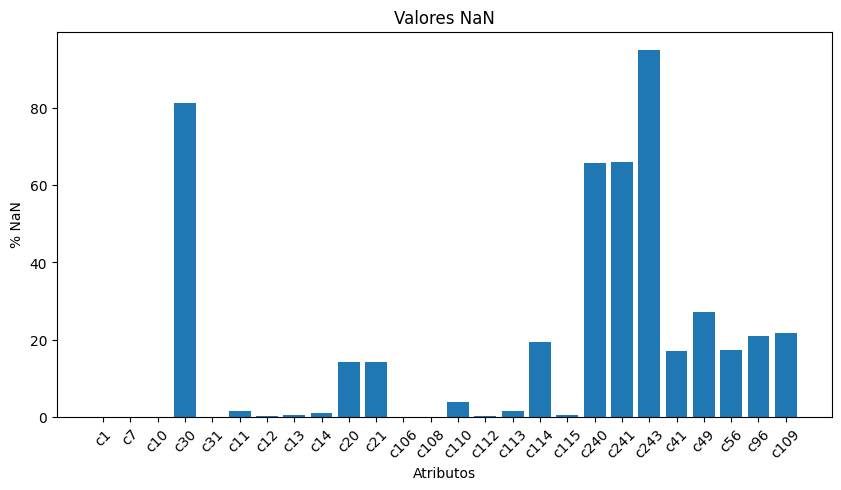

In [268]:
plot_nan(df)

In [92]:
def categorical_histogram(col: str, df: pd.DataFrame = df, bins=10):
    # Instancia del codificador
    oe = preprocessing.OrdinalEncoder()

    # Ajuste del modelo (fit) y codificación de los datos (transform)
    try:
        oe.fit(df[[col]])
        col_encoded = oe.transform(df[[col]])
    except:
        oe.fit(df[[col]].astype(str))
        col_encoded = oe.transform(df[[col]].astype(str))

    # Crear un dataframe auxiliar con los atributos y valores transformados
    names = oe.get_feature_names_out()
    col_df = pd.DataFrame(col_encoded, columns=names)

    # Imprimir el histograma de los datos
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,5))

    col_df.plot(kind='box', ax=axes[0]).set_title('Distribución de los datos.')
    col_df.plot.hist(bins=bins, ax=axes[1])

    plt.show()
    
    print('[+] VALUES_ENCODED\t', oe.categories_[0])
    print('[+] SKEW\t', col_df.skew()[0])
    
def numerical_histogram(col: str, df: pd.DataFrame = df, bins=10):
    # Imprimir el histograma de los datos
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,5))

    df[col].plot(kind='box', ax=axes[0]).set_title('Distribución de los datos.')
    df[col].plot.hist(bins=bins, ax=axes[1])

    plt.show()
    print('[+] SKEW\t', df[[col]].skew()[0])
    

In [93]:
df_backup = df.copy()

In [94]:
STOP

NameError: name 'STOP' is not defined

In [207]:
df = df_backup.copy()

<h4><div style="font-size:14px; text-align:left"><b>COLUMNAS NO RELACIONADAS</b></div></h4>

<h6><div style="font-size:14px; text-align:left"><b>c7: Month the accident/incident happened.</b></div></h6>

In [208]:
col = 'c7'
print('[+] COL\t', col_name(col), '\n')
print('[+] NAN_VALUES\t', df[[col]].isna().sum()[0])
df[[col]].describe()

[+] COL	 Month the accident/incident happened. 

[+] NAN_VALUES	 32


c7
count   214632
unique      12
top          7
freq     23871

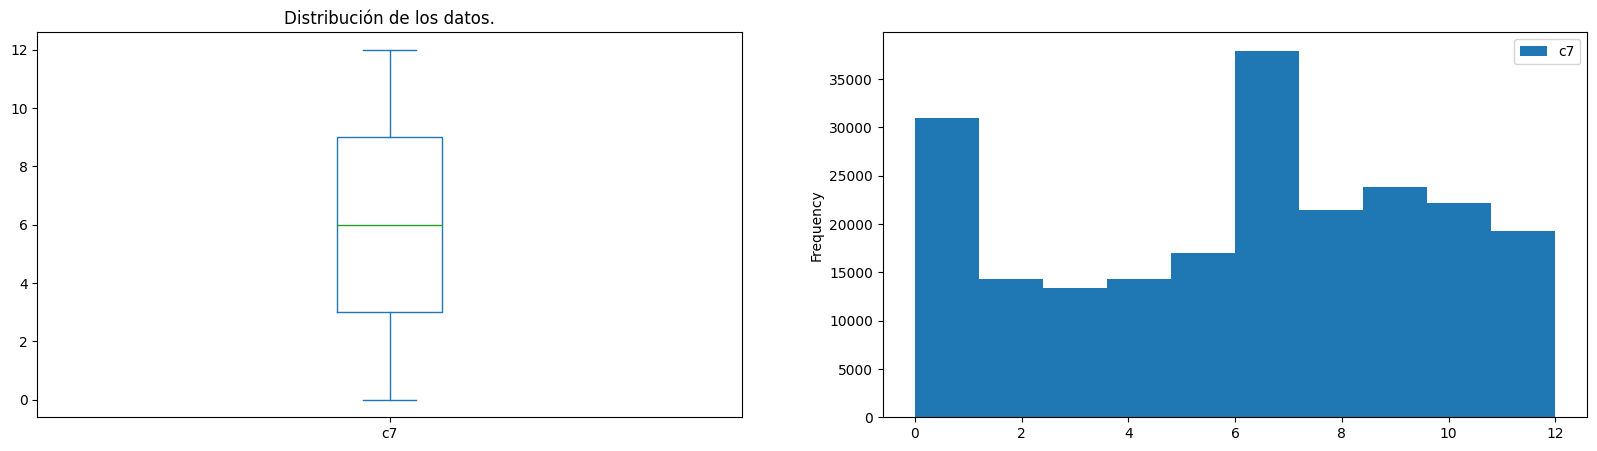

[+] VALUES_ENCODED	 ['1' '10' '11' '12' '2' '3' '4' '5' '6' '7' '8' '9' '<NA>']
[+] SKEW	 -0.2518795522548588


In [209]:
categorical_histogram(col)

Ya que se trata de un pequeño numero de datos faltantes, se decide imputar el mas frecuente pues apenas influye en la distribución de los datos.

In [210]:
# Modelo de imputacion most_frequent
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# Imputación de los datos
df[col] = imputer.fit_transform(df[[col]].astype(str))

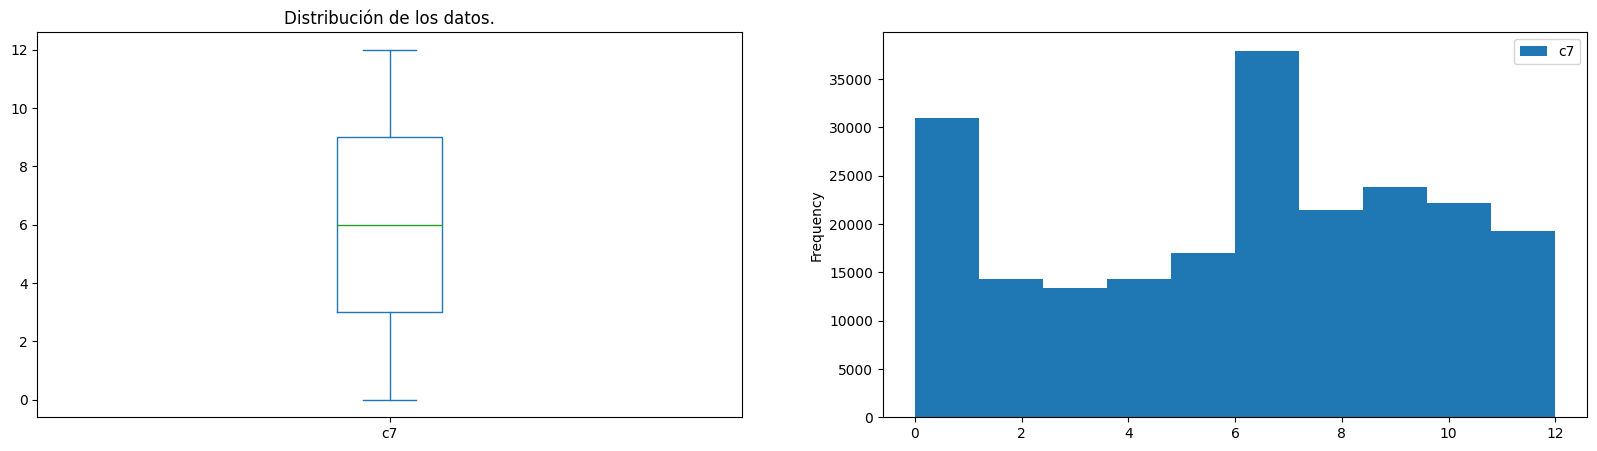

[+] VALUES_ENCODED	 ['1' '10' '11' '12' '2' '3' '4' '5' '6' '7' '8' '9' '<NA>']
[+] SKEW	 -0.2518795522548588


In [211]:
categorical_histogram(col)

Como se menciona, no existe ninguna variación en la distribución de los datos.

<h6><div style="font-size:14px; text-align:left"><b>c30: Airworthiness class code of the aircraft</b></div></h6>

In [264]:
col = 'c30'
print('[+] COL\t', col_name(col), '\n')
print('[+] NAN_VALUES\t', df[[col]].isna().sum()[0])
df[[col]].describe()

[+] COL	 Airworthiness class code of the aircraft 

[+] NAN_VALUES	 174642


c30
count   40022
unique      6
top      STRD
freq    32323

Al tratarse de una columna categórica, se realiza una codificación de los datos para poder ver la distribución de estos y poder decidir una técnica de imputación.

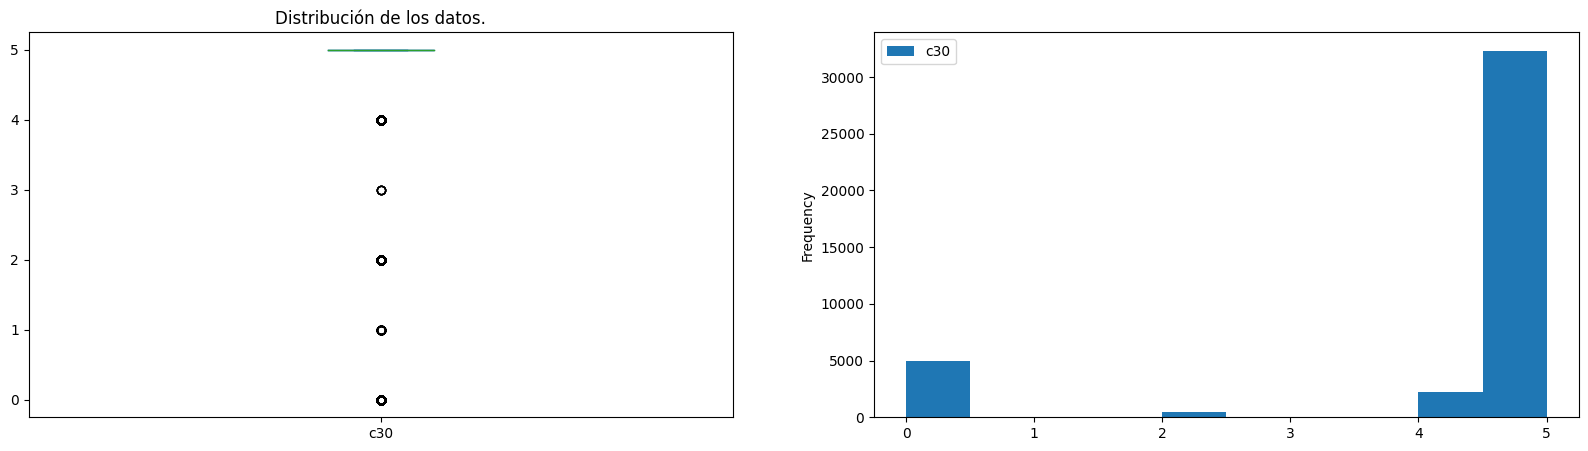

[+] VALUES_ENCODED	 ['EXPT' 'LIMT' 'MULT' 'PROV' 'REST' 'STRD' nan]
[+] SKEW	 -2.1014134506233697


c30
count   40022
unique      6
top      STRD
freq    32323

In [265]:
categorical_histogram(col, df, bins=6)
df[[col]].describe()

Con el gráfico del histograma se observa que la gran mayoría de los resultados son de la clase Standard "STRD". Pero, existe un gran numero de datos faltantes, por lo tanto, se decide limitar la imputación en el numero de NaN consecutivos que exista.

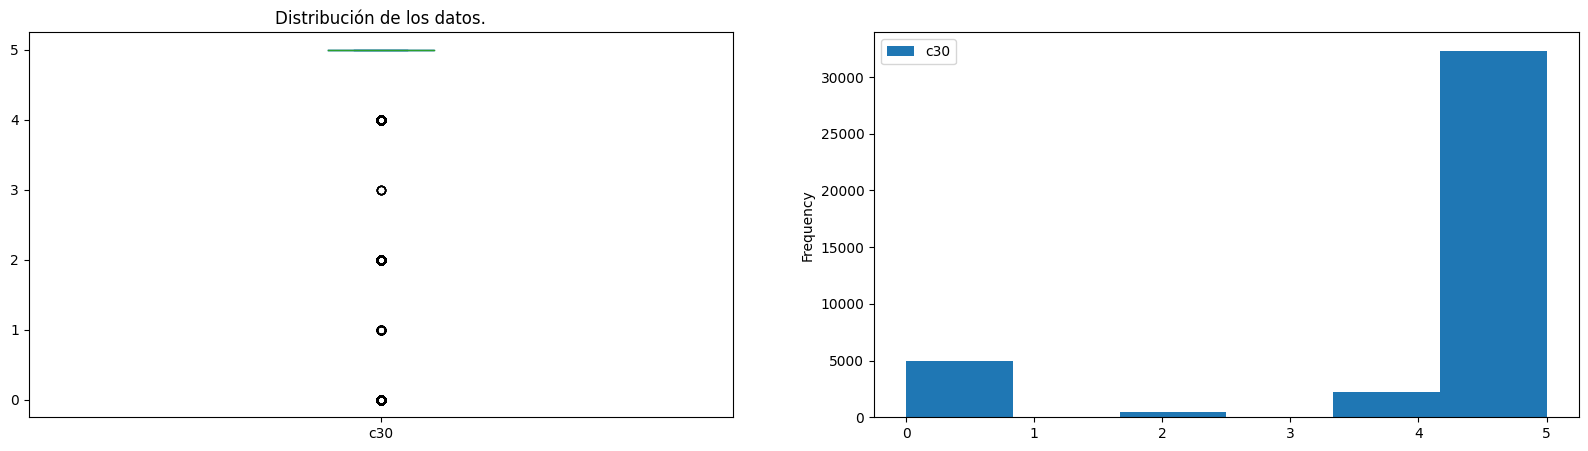

[+] VALUES_ENCODED	 ['EXPT' 'LIMT' 'MULT' 'PROV' 'REST' 'STRD' nan]
[+] SKEW	 -2.1014134506233697


c30
count   40022
unique      6
top      STRD
freq    32323

In [267]:
# Numero de datos faltantes y limite
nan_values = df[[col]].isna().sum()[0]
limit = int(round( nan_values * 0.30, 0))

# imputación
df[col].fillna(df[col].mode(), inplace=True, limit=limit)

# Representación
categorical_histogram(col, df, bins=6)
df[[col]].describe()

Como se puede apreciar, no se ha imputado ningún nuevo valor, pues existe grupos de datos faltantes de más del 30% de los datos NaN.

<h6><div style="font-size:14px; text-align:left"><b>c31: Airframe hours of the aircraft</b><br></div></h6>

In [215]:
col = 'c31'
print('[+] COL\t', col_name(col), '\n')
print('[+] NAN_VALUES\t', df[[col]].isna().sum()[0])
df[[col]].describe()

[+] COL	 Airframe hours of the aircraft 

[+] NAN_VALUES	 94317


c31
count  120347.000000
mean     4946.355622
std      8731.752435
min         0.000000
25%      1202.000000
50%      2730.000000
75%      4964.000000
max     99999.000000

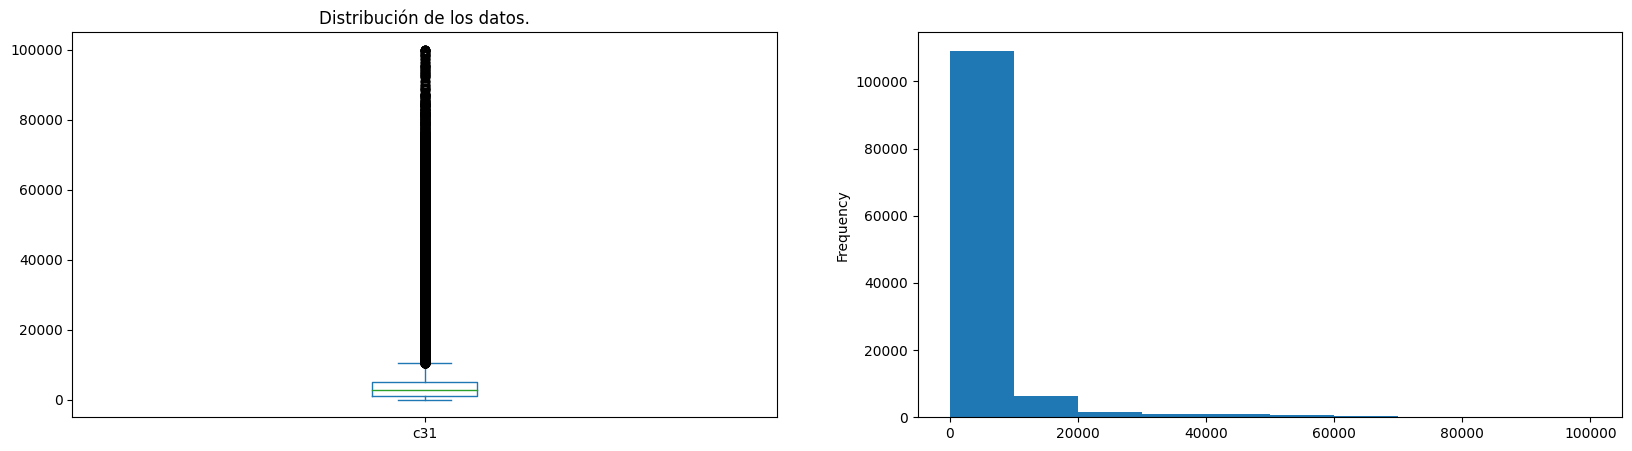

[+] SKEW	 4.959558388999156


c31
count  120347.000000
mean     4946.355622
std      8731.752435
min         0.000000
25%      1202.000000
50%      2730.000000
75%      4964.000000
max     99999.000000

In [216]:
numerical_histogram(col)
df[[col]].describe()

Se observa que se trata de una caracteristica con un gran numero de datos átipicos pero con media dentro de la caja. Es por esto que se imputa los datos faltantes con la media de los atributos.

In [217]:
df[col].fillna(df[col].mean(), inplace=True)
df[[col]].describe()

c31
count  214664.000000
mean     4946.355622
std      6537.905618
min         0.000000
25%      2393.000000
50%      4946.355622
75%      4946.355622
max     99999.000000

Se observa con la imputación de los valores que la desviación estandar se reduce así como la mediana y la moda coinciden. Más adelante se seguirá trabajando este atributo al tener un fuerte sesgo hacia la derecha.

<h6><div style="font-size:14px; text-align:left"><b>c106: Primary flying condition code</b></div></h6>

In [218]:
col = 'c106'
print('[+] COL\t', col_name(col), '\n')
print('[+] NAN_VALUES\t', df[[col]].isna().sum()[0])
df[[col]].describe()

[+] COL	 Primary flying condition code 

[+] NAN_VALUES	 42724


c106
count   171940
unique       3
top          B
freq    130636

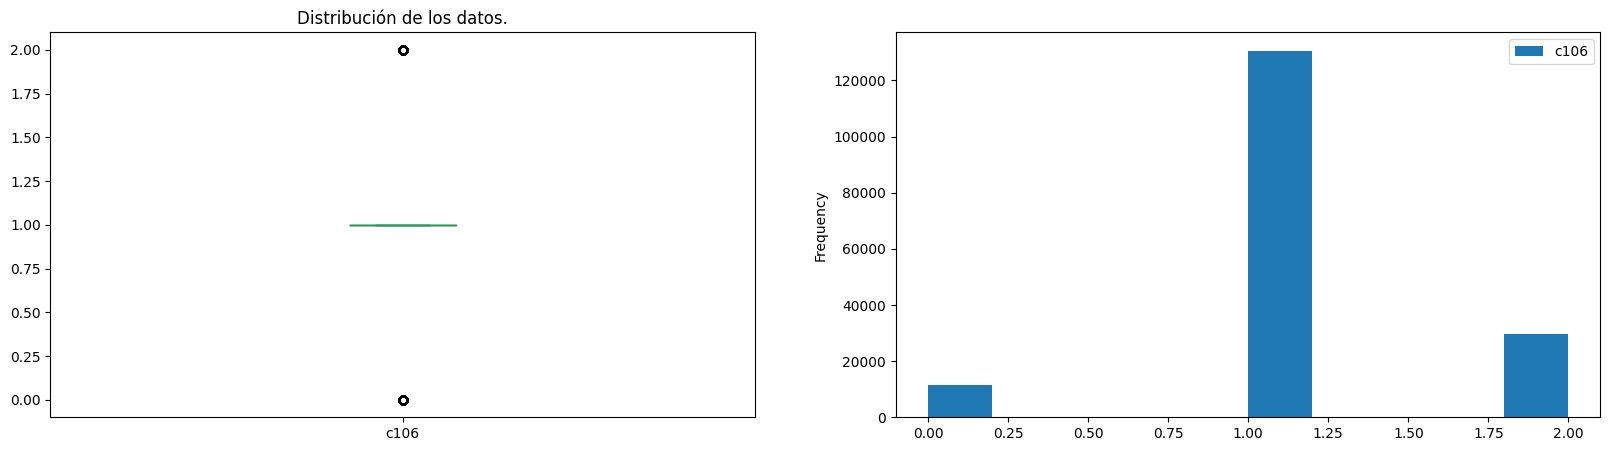

[+] VALUES_ENCODED	 ['A' 'B' 'C' nan]
[+] SKEW	 0.2932921334971132


In [219]:
categorical_histogram(col)

Al observar la distribución de los datos, claramente se observa que la característica B es la que más se extiende por el atributo, además, dado el numero de datos faltantes y los existentes para esta característica, se considera que imputar por el más frecuente se trata de una buena opción.

In [220]:
df[col].fillna(df[col].mode()[0], inplace=True)
df[[col]].isna().sum()

c106    0
dtype: int64

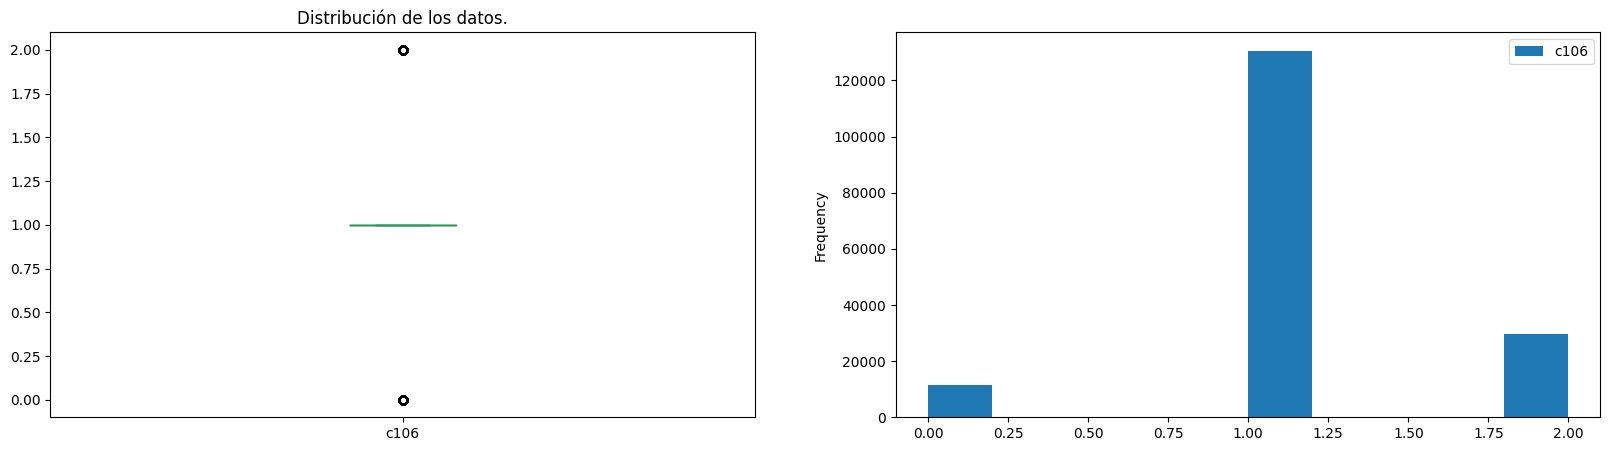

[+] VALUES_ENCODED	 ['A' 'B' 'C' nan]
[+] SKEW	 0.2932921334971132


In [221]:
categorical_histogram(col)

Finalmente, tras la imputación, existe un ligero aumento de un sesgo a la derecha, de 0,2 puntos, que se considera no excesivo.

<h6><div style="font-size:14px; text-align:left"><b>c108: Secondary flying condition code</b></div></h6>

In [222]:
col = 'c108'
print('[+] COL\t', col_name(col), '\n')
print('[+] NAN_VALUES\t', df[[col]].isna().sum()[0])
df[[col]].describe()

[+] COL	 Secondary flying condition code 

[+] NAN_VALUES	 42969


c108
count   171695
unique      23
top          S
freq    138179

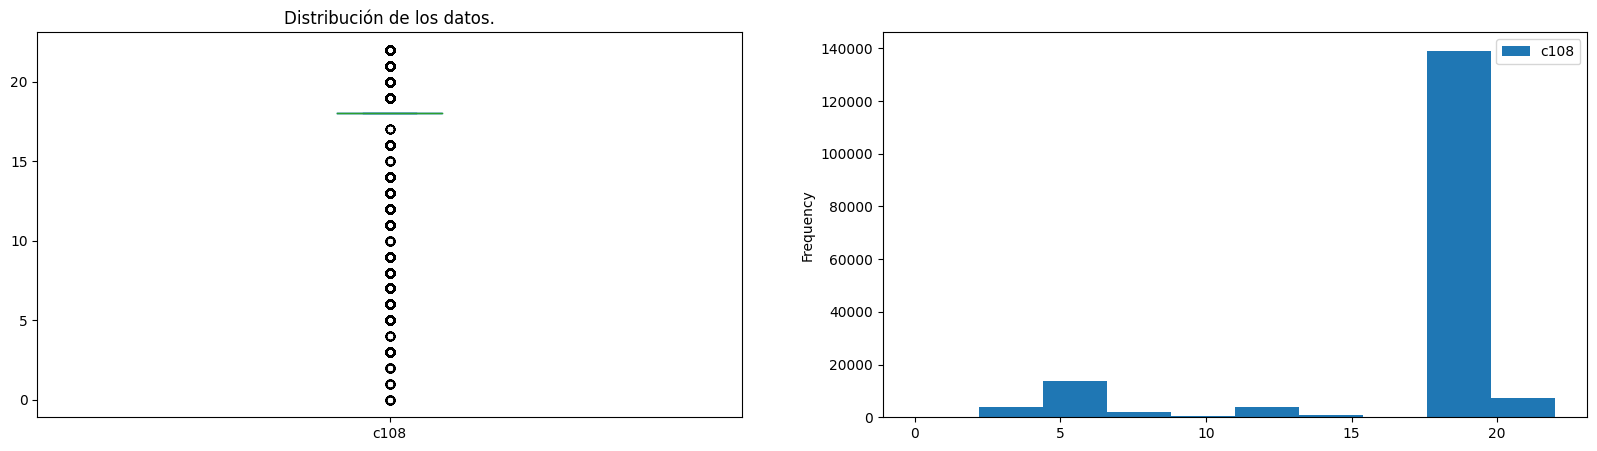

[+] VALUES_ENCODED	 ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' nan]
[+] SKEW	 -2.0978404805175357


In [223]:
categorical_histogram(col)

Al observar la distribución de los datos, claramente se observa que la característica B es la que más se extiende por el atributo, además, dado el numero de datos faltantes y los existentes para esta característica, se considera que imputar por el más frecuente se trata de una buena opción.

In [224]:
df[col].fillna(df[col].mode()[0], inplace=True)
df[[col]].isna().sum()

c108    0
dtype: int64

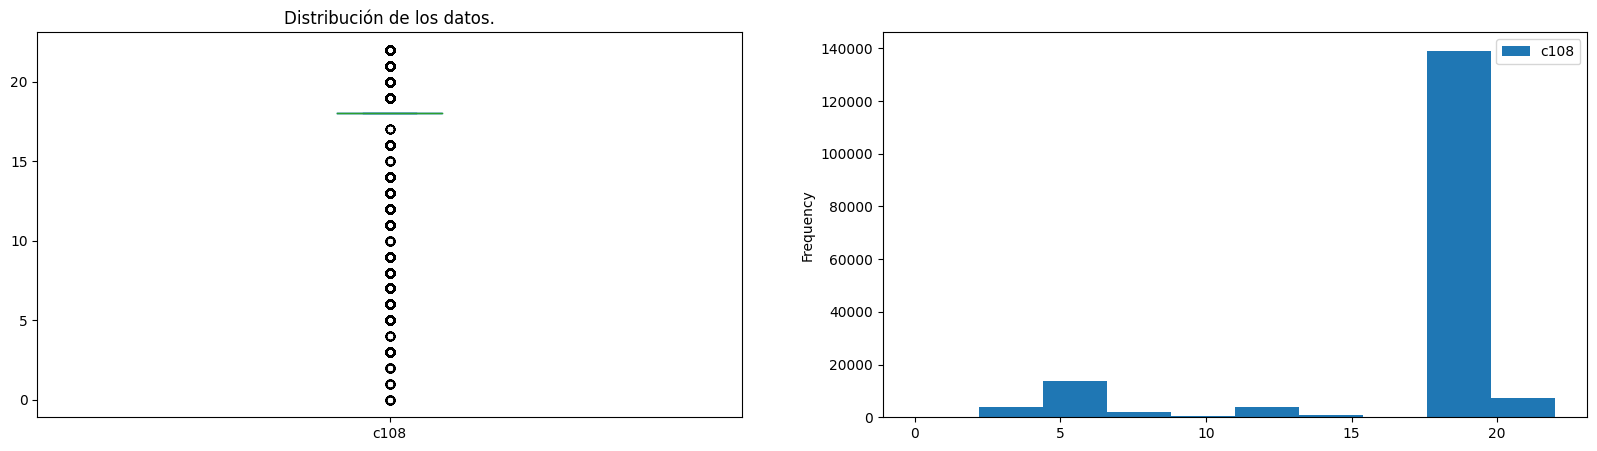

[+] VALUES_ENCODED	 ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' nan]
[+] SKEW	 -2.0978404805175357


In [225]:
categorical_histogram(col)

Finalmente, tras la imputación, existe un ligero aumento de un sesgo a la derecha, de 0,2 puntos, que se considera no excesivo.

<h6><div style="font-size:14px; text-align:left"><b>c240: Wind direction</b></div></h6>

In [146]:
col = 'c240'
print('[+] COL\t', col_name(col), '\n')
print('[+] NAN_VALUES\t', df[[col]].isna().sum()[0])
df[[col]].describe()

[+] COL	 Wind direction 

[+] NAN_VALUES	 141071


c240
count  73593.000000
mean      18.625384
std       10.855023
min        0.000000
25%       10.000000
50%       19.000000
75%       27.000000
max       90.000000

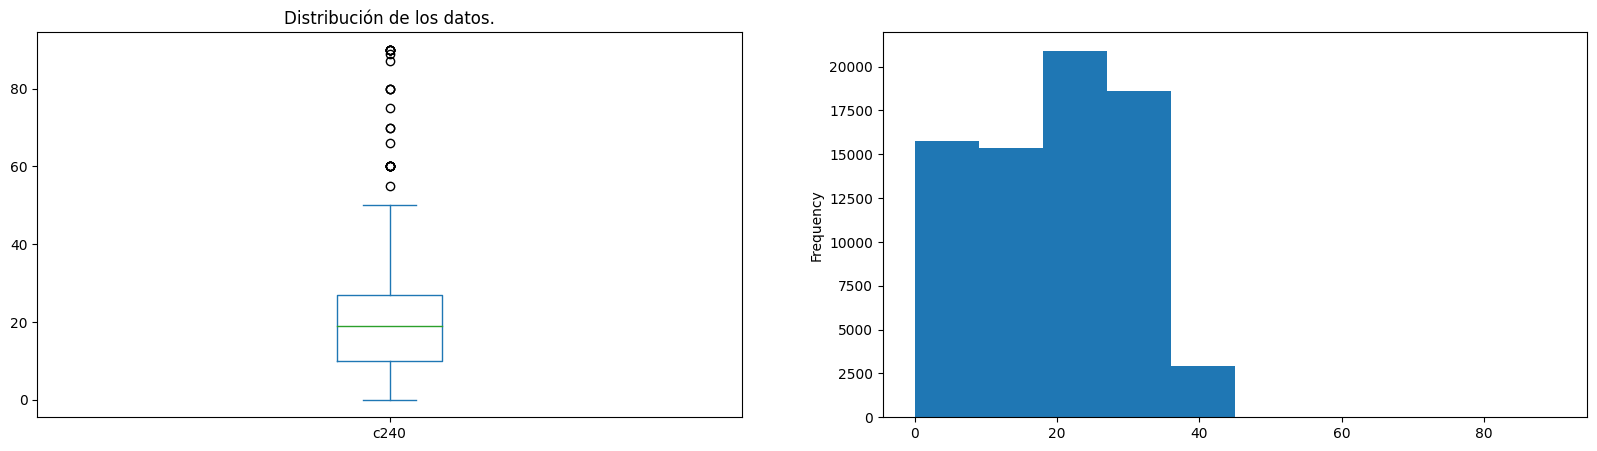

[+] SKEW	 -0.1379627129535676


In [149]:
numerical_histogram(col, df, bins=10)

No existe un elevado sesgo por lo que se realiza una imputación teniendo en cuenta la media.

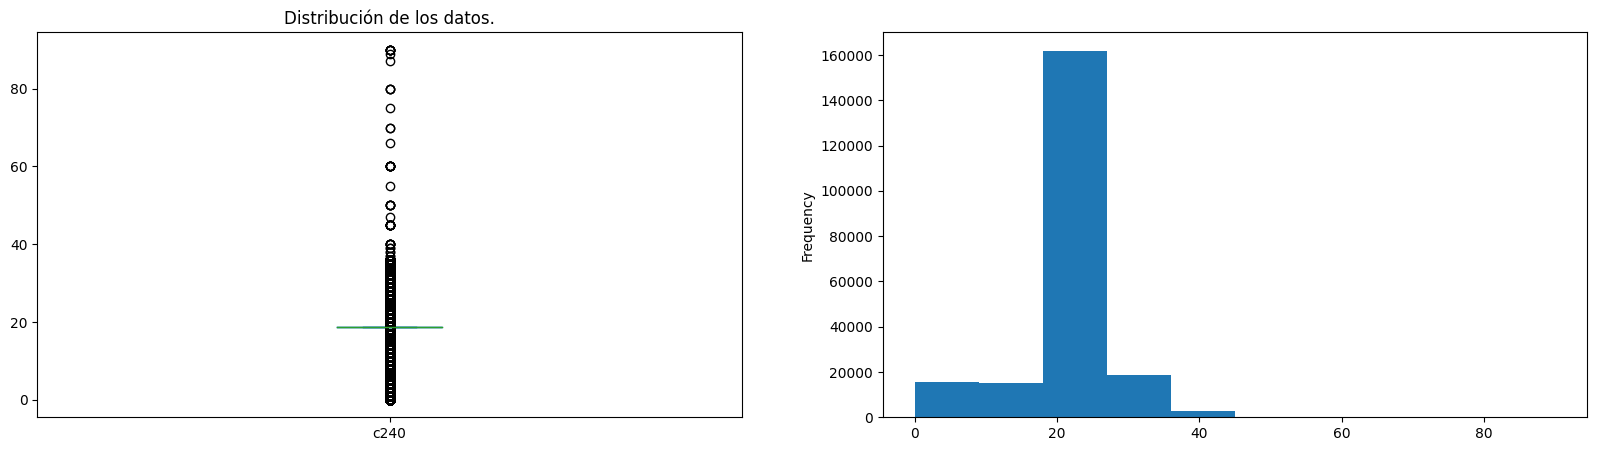

[+] SKEW	 -0.23562277352018277


c240
count  214664.000000
mean       18.625384
std         6.355759
min         0.000000
25%        18.625384
50%        18.625384
75%        18.625384
max        90.000000

In [150]:
# Imputación ded atos
df[col].fillna(df[col].mean(), inplace=True)

# Representación de datos
numerical_histogram(col, df, bins=10)
df[[col]].describe()

<h6><div style="font-size:14px; text-align:left"><b>c241: Wind speed in miles per hours</b></div></h6>

In [198]:
col = 'c241'
print('[+] COL\t', col_name(col), '\n')
print('[+] NAN_VALUES\t', df[[col]].isna().sum()[0])
df[[col]].describe()

[+] COL	 Wind speed in miles per hours 

[+] NAN_VALUES	 142012


c241
count  72652.000000
mean       8.814348
std        5.961852
min        0.000000
25%        5.000000
50%        8.000000
75%       11.000000
max       99.000000

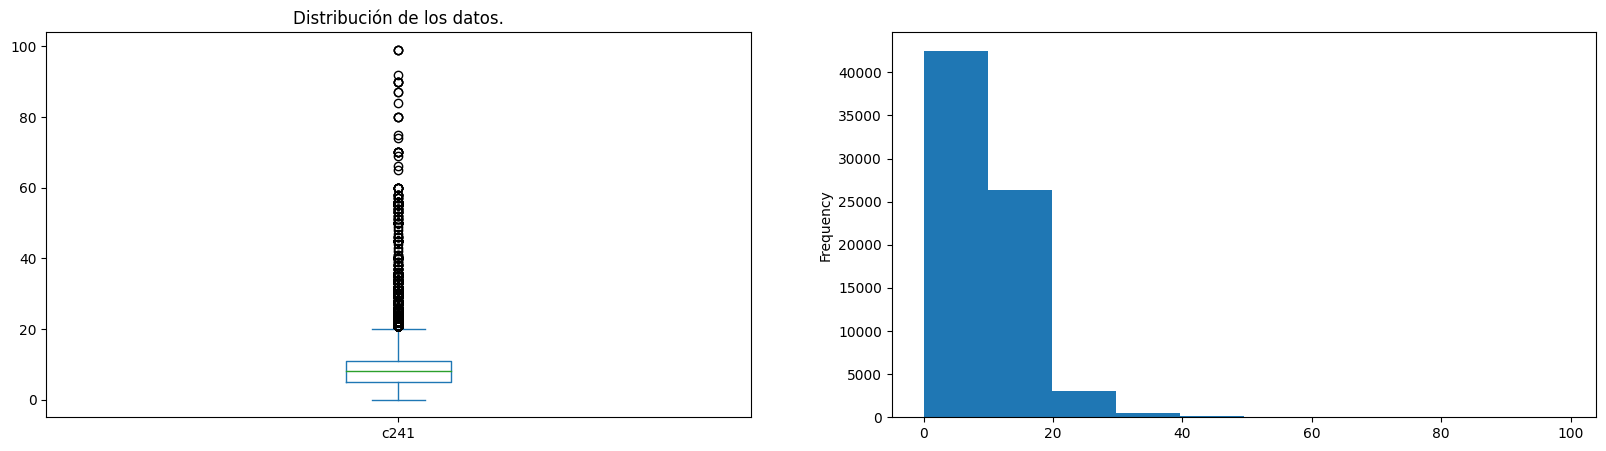

[+] SKEW	 2.1958949925009055


In [199]:
numerical_histogram(col, df, bins=10)

Existe un sesgo a la derecha por lo que se imputa los valores teniendo en cuenta la mediana.

In [201]:
print(df[[col]].isna().sum()[0])
limit = int(round(df[[col]].isna().sum()[0] * 0.50))
limit

142012


42604

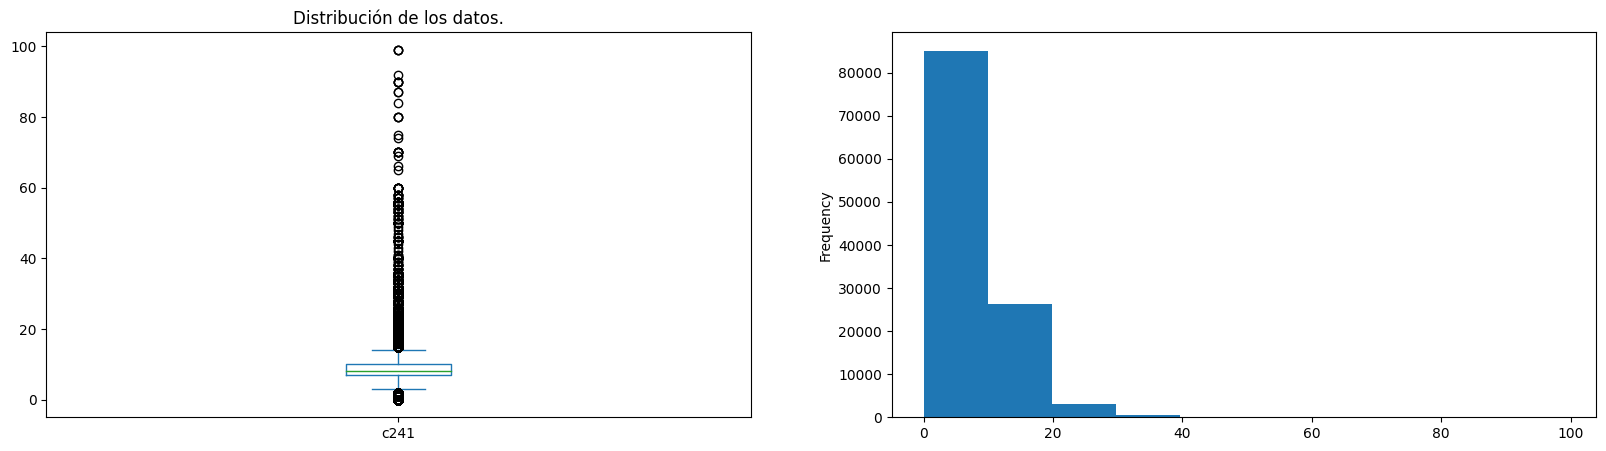

[+] SKEW	 2.925929195899891
[+] IMPUTED	-42604


In [202]:
# Imputación de datos
nan_values = df[[col]].isna().sum()[0]
limit = int(round( nan_values * 0.30, 0))
df[col].fillna(df[col].median(), inplace=True, limit=limit)

# Representación de datos
numerical_histogram(col, df, bins=10)
df[[col]].describe()
print(f'[+] IMPUTED\t{df[[col]].isna().sum()[0] - nan_values}')

<h4><div style="font-size:14px; text-align:left"><b>COLUMNAS RELACIONADAS</b></div></h4>

Existe determinadas columnas que sus datos están relacionados a otras columnas. Estas relaciones son:
- Localización del incidente<br>
Para las columnas de Latitud y longitud, su relación existe con las columnas c11, c12, c13 y c14 pues hacen referencia a la region, distrito, estado y ciudad respectivamente.

- Hora del incidente<br>
La hora del incidente está vinculada al código de luminosidad, c110, ya que sus datos indican el momento del día del incidente.

- Estado del cielo<br>
Para esta característica, existe un conjunto de columnas que estarán relacionadas entre ellas, en concreto son:
    - c112 Sky condition code
    - c113 Cloud ceiling
    - c114 Visibility code
    - c110 Light condition code
    - c115 Visibility restriction code
    
Estas relaciones se explicarán en cada uno de los casos de estudio.

Dada la relación de c110 y c10, y encontrandose en diferentes grupos, se realiza la comprobacion de sus NaN para ver cual se debiera imputar primero.

In [97]:
# Muestra de valores NaN para cada columna
related_cols = ['c110', 'c10']
for col in related_cols:
    print(f'[+] NAN_VALUES\t{col}\t{col_name(col):<35}\t{df[[col]].isna().sum()[0]}')

[+] NAN_VALUES	c110	Light condition code               	46195
[+] NAN_VALUES	c10	Local time of the accident/incident.	25668


Ya que c110 tiene un número mayor de valore sfaltantes, se imputa primero el grupo al que este pertenece

<h5><div style="font-size:14px; text-align:left"><b>LOCALIZACIÓN DEL INCIDENTE</b></div></h5>

In [227]:
col = ['c20', 'c21']
print('[+] COL\t', col_name(col[0]), '&', col_name(col[1]), '\n')
print('[+] NAN_VALUES\t', df[[col[0]]].isna().sum()[0])
print('[+] NAN_VALUES\t', df[[col[1]]].isna().sum()[0])
df[col].describe()

[+] COL	 Latitude coordinates of the accident/incident & Longitude coordinates of the accident/incident 

[+] NAN_VALUES	 156390
[+] NAN_VALUES	 156415


c20           c21
count  58274.000000  58249.000000
mean      39.303099    -97.838415
std        9.263097     26.061591
min     -163.866667   -180.750000
25%       33.866667   -113.716667
50%       38.966667    -93.550000
75%       42.616667    -81.683333
max       90.916667    180.000000

[+] Latitude


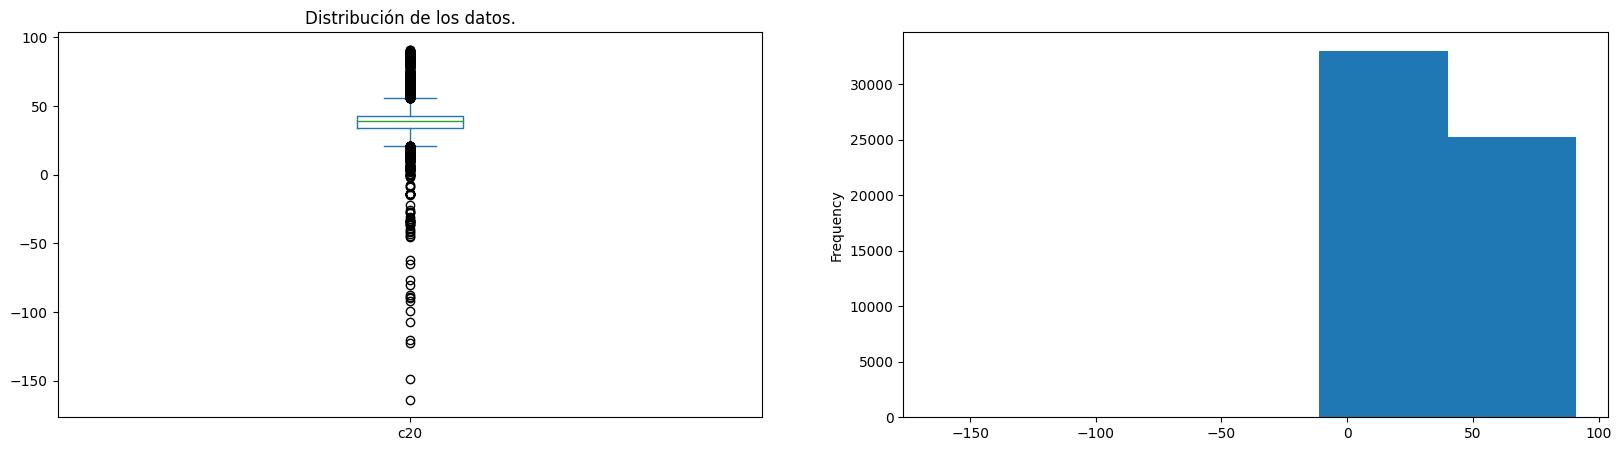

[+] SKEW	 -0.22389156785945905


In [228]:
print('[+] Latitude')
numerical_histogram(col[0], df, bins=5)

[+] Longitude


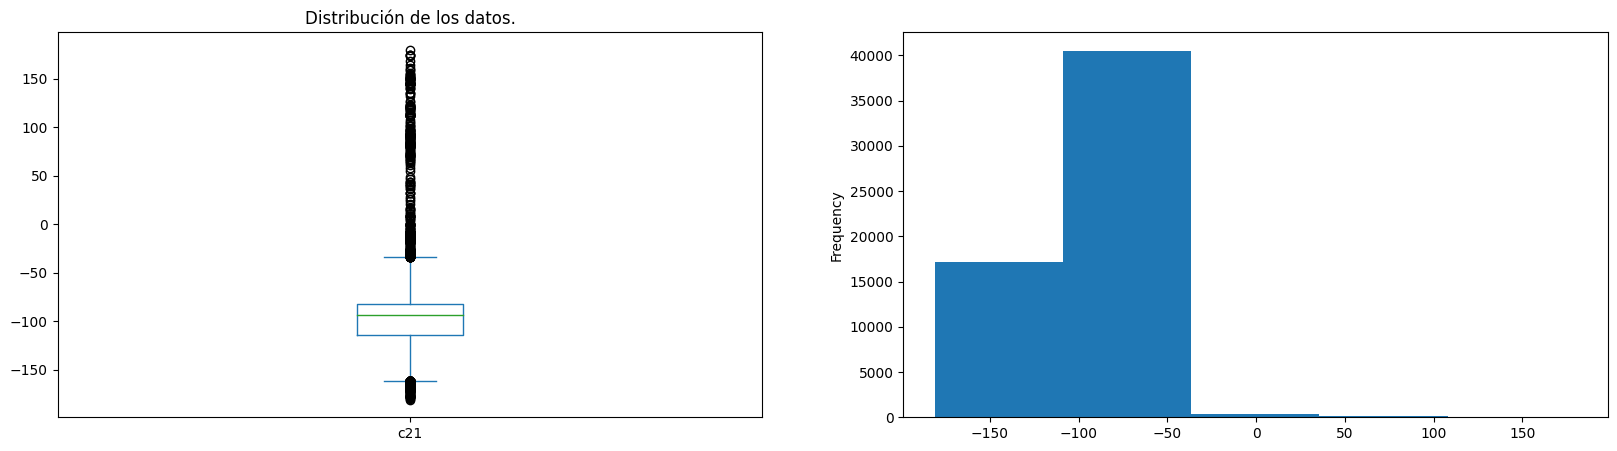

[+] SKEW	 1.2204295481897933


In [229]:
print('[+] Longitude')
numerical_histogram(col[1], df, bins=5)

Según los sesgos obtenidos, se realiza una imputación con la media para los valores de Latitud y de mediana para la Longitud ya que representa un sesgo mayor.

Para realizar la imputación de los valores perdidos de latitud y longitud, primero se agrupa los datos según las columnas para estado, ciudad, region y distrito. Pero para saber en que orden se ha de realizar la agrupación, se extrae el total de valores unicos de cada columna, de modo que podamos agrupar de más grande a más pequeño. 

In [230]:
df[['c11', 'c12', 'c13', 'c14']].nunique()

c11       13
c12      271
c13      164
c14    19418
dtype: int64

Teniendo en cuenta los resultados, se realiza el agrupamiento por orden de Region(c11)/Estado(c13)/Ciudad(c14). Tras analizar los datos que se tiene, se decide eliminar de la agrupación la columna c12, relativa a la region, porque no aporta una información tan clara de su significado para la agrupación como si las otras columnas.

In [231]:
# Crear los grupos en orden segun: Region - Estado - Ciudad
groups = df.groupby(['c11', 'c13', 'c14'], group_keys=False, dropna=True)

print('[+] TOTAL_GROUPS\t', groups.ngroups)
groups.mean(numeric_only=True)[col]

[+] TOTAL_GROUPS	 28165


c20  c21
c11 c13 c14                            
AL  AB  BONNYVILLE       53.916667  NaN
    AK  ACKERMAN LAKE          NaN  NaN
        ADAK ISLAND            NaN  NaN
        ADMIRALTY ISLAN        NaN  NaN
        AFOGNAK ISL            NaN  NaN
...                            ...  ...
WP  XX  PACIFIC OCEAN          NaN  NaN
        PUERTA VLARTA          NaN  NaN
        PUERTOCITAS            NaN  NaN
        ROTA                   NaN  NaN
        SANTA INEZ             NaN  NaN

[28165 rows x 2 columns]

Una vez se tiene el orden de los grupos, se obtiene un total de 28000 grupos, sobre estos grupos a continuación se realizará una imputación por interpolación.

C:\Users\vicsi\Documents\Master EIP\TFM-EIP\ML-Models\env\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


[+] Latitude


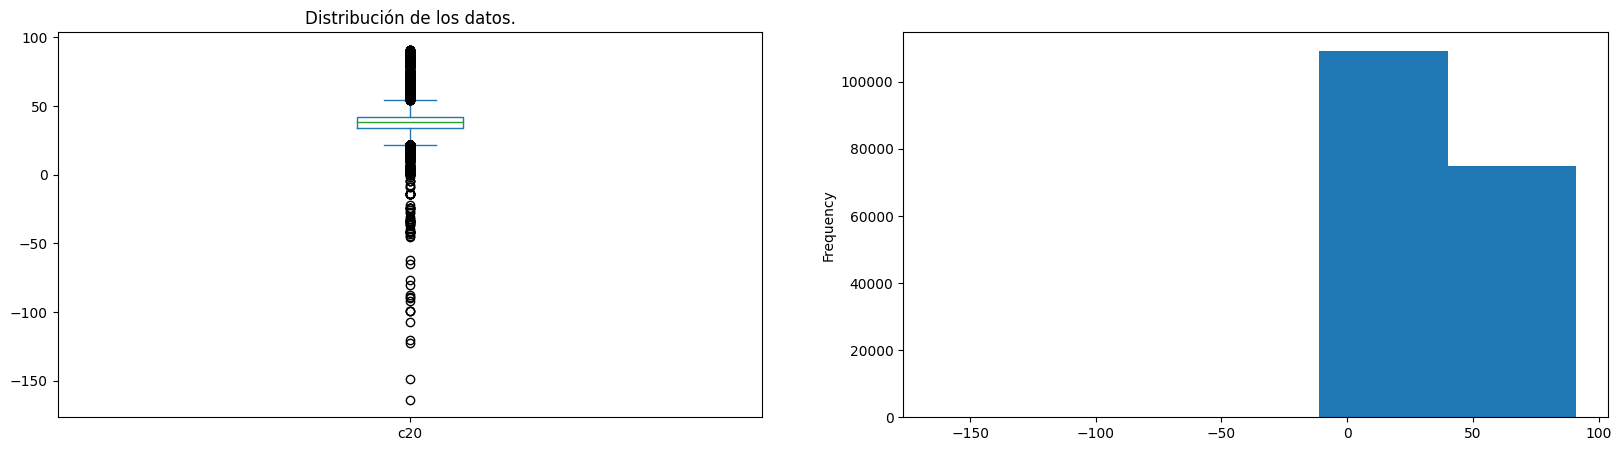

[+] SKEW	 0.32330985643282034
[+] Longitude


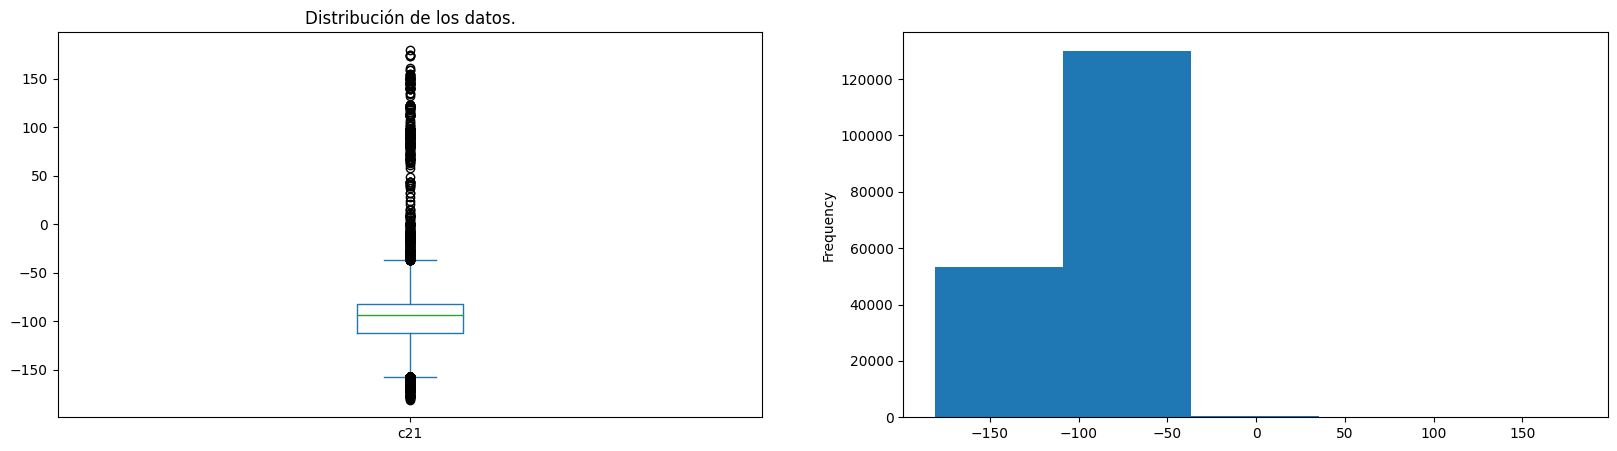

[+] SKEW	 0.32651905380921076


c20            c21
count  184332.000000  184321.000000
mean       38.609824     -97.585577
std         8.018483      22.055395
min      -163.866667    -180.750000
25%        33.737500    -112.066667
50%        38.682203     -93.316667
75%        42.016667     -82.083333
max        90.916667     180.000000

In [232]:
# Aplicar la imputación a las columnas c20 y c21 de cada grupo
df[[col[0]]] = groups[[col[0]]].transform(lambda group: group.fillna(group.mean()))
df[[col[1]]] = groups[[col[1]]].transform(lambda group: group.fillna(group.median()))

# Representar datos
print('[+] Latitude')
numerical_histogram(col[0], df, bins=5)
print('[+] Longitude')
numerical_histogram(col[1], df, bins=5)
df[col].describe()

Tras la imputación, se observa que el sesgo se ha conseguido reducir hasta 1 punto en el caso de la Longitud, mientras que la Latitud se ha desplazado hacia la derecha.

<h5><div style="font-size:14px; text-align:left"><b>ESTADO DEL CIELO</b></div></h5>

Para estas relaciones, primero se evaluará cuál de las columnas relacionadas contiene un mayor número de datos NaN para imputar sus datos en relación a las otras. 

In [233]:
# Muestra de valores NaN para cada columna
related_cols = ['c110', 'c112', 'c113', 'c114', 'c115']
for col in related_cols:
    print(f'[+] NAN_VALUES\t{col}\t{col_name(col):<35}\t{df[[col]].isna().sum()[0]}')

[+] NAN_VALUES	c110	Light condition code               	46195
[+] NAN_VALUES	c112	Sky condition code                 	124369
[+] NAN_VALUES	c113	Cloud ceiling                      	194862
[+] NAN_VALUES	c114	Visibility code                    	126446
[+] NAN_VALUES	c115	Visibility restriction code.       	196487


A contniación se imputará los valores a las columnas en función de los resultados obtenidos.

<h6><div style="font-size:14px; text-align:left"><b>c115: Visibility restriction code</b></div></h6>

In [234]:
col = 'c115'
print('[+] COL\t', col_name(col), '\n')
print('[+] NAN_VALUES\t', df[[col]].isna().sum()[0])
df[[col]].describe()

[+] COL	 Visibility restriction code. 

[+] NAN_VALUES	 196487


c115
count   18177
unique      8
top       HAZ
freq     6992

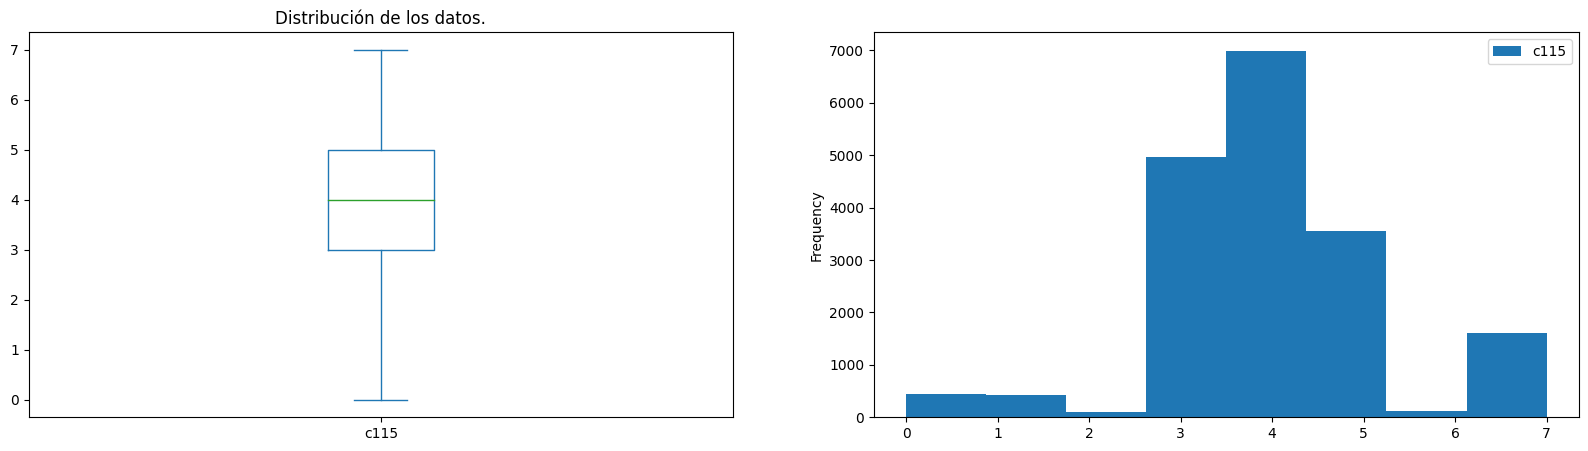

[+] VALUES_ENCODED	 ['BLS' 'DRZ' 'DST' 'FOG' 'HAZ' 'RAI' 'SMK' 'SNO' nan]
[+] SKEW	 0.003743929340825541


In [235]:
categorical_histogram(col, df, bins=8)

Para la codificación de estos datos, del mismo modo que con las columnas anteriores, existe una relación con una serie de columnas, en concreto con:
- Estado del cielo (c112)
- Código de la luz (c110)
- Distancia de la visión (c114)

In [236]:
df[['c112', 'c110', 'c114']].nunique()

c112     5
c110     5
c114    12
dtype: int64

Teniendo en cuenta los resultados, se realiza el agrupamiento por orden de c110/c112/c114

In [237]:
# Convertir la columna a numérica para realizar la imputación
# Instancia del codificador
oe = preprocessing.OrdinalEncoder()
oe.fit(df[[col]])
col_encoded = oe.transform(df[[col]])

# Crear un dataframe auxiliar con los atributos y valores transformados
df[col] = col_encoded

# Crear los grupos en orden segun: Codigo de luz - Estado del cielo - Restriccion de visión
groups = df.groupby(['c110', 'c112', 'c114'], group_keys=False, dropna=False)

print('[+] TOTAL_GROUPS\t', groups.ngroups)
groups.mean(numeric_only=True)[[col]]

[+] TOTAL_GROUPS	 372


c115
c110 c112 c114          
1    BRKN 1     4.020202
          10    4.648148
          2     4.008511
          3     4.027668
          4     4.067729
...                  ...
NaN  NaN  7          NaN
          9          NaN
          G10   7.000000
          LS1   1.500000
          NaN   3.606299

[372 rows x 1 columns]

Dado el sesgo que es cercano a 0, se realiza una imputación teniendo en cuenta la media.

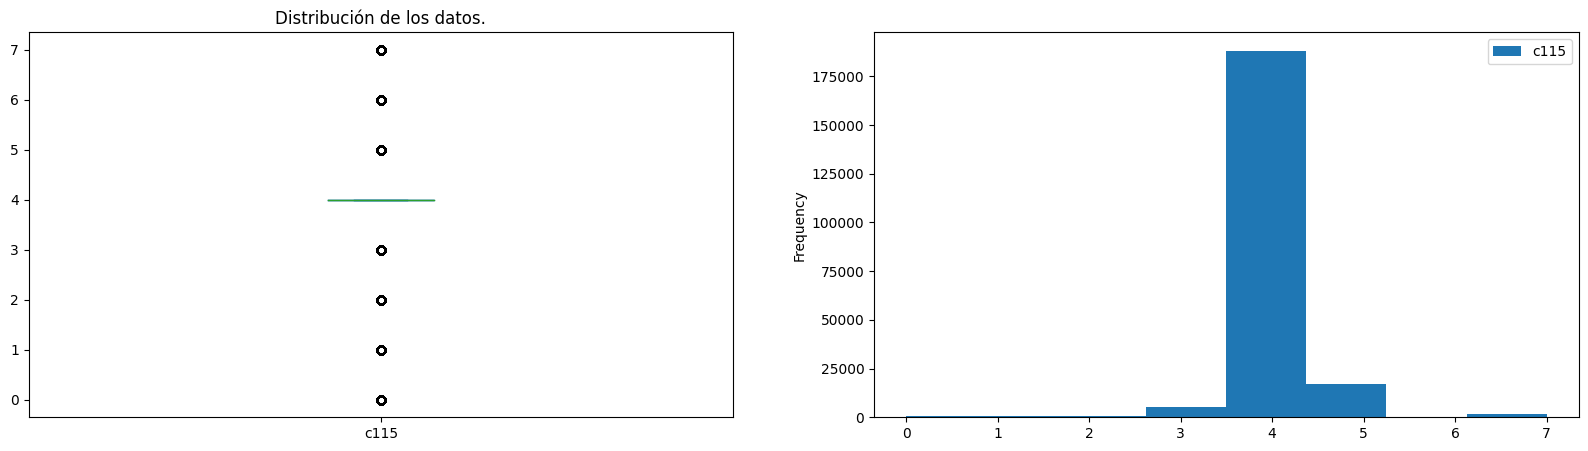

[+] VALUES_ENCODED	 ['BLS' 'DRZ' 'DST' 'FOG' 'HAZ' 'RAI' 'SMK' 'SNO' nan]
[+] SKEW	 0.12103087423331625


c115
count   213978
unique       8
top        HAZ
freq    188206

In [238]:
# Aplicar la imputación
df[[col]] = groups[[col]].transform(lambda group: group.fillna(round(group.mean(), 0)))

# Devolver los valores a su categoria
df[[col]] = oe.inverse_transform(df[[col]])

# Presentar datos
categorical_histogram(col, df, bins=8)
df[[col]].describe()

<h6><div style="font-size:14px; text-align:left"><b>c113: Cloud ceiling</b></div></h6>

In [239]:
col = 'c113'
print('[+] COL\t', col_name(col), '\n')
print('[+] NAN_VALUES\t', df[[col]].isna().sum()[0])
df[[col]].describe()

[+] COL	 Cloud ceiling 

[+] NAN_VALUES	 194862


c113
count  19802.000000
mean    3043.249571
std     2674.987580
min        0.000000
25%      800.000000
50%     2500.000000
75%     4500.000000
max     9999.000000

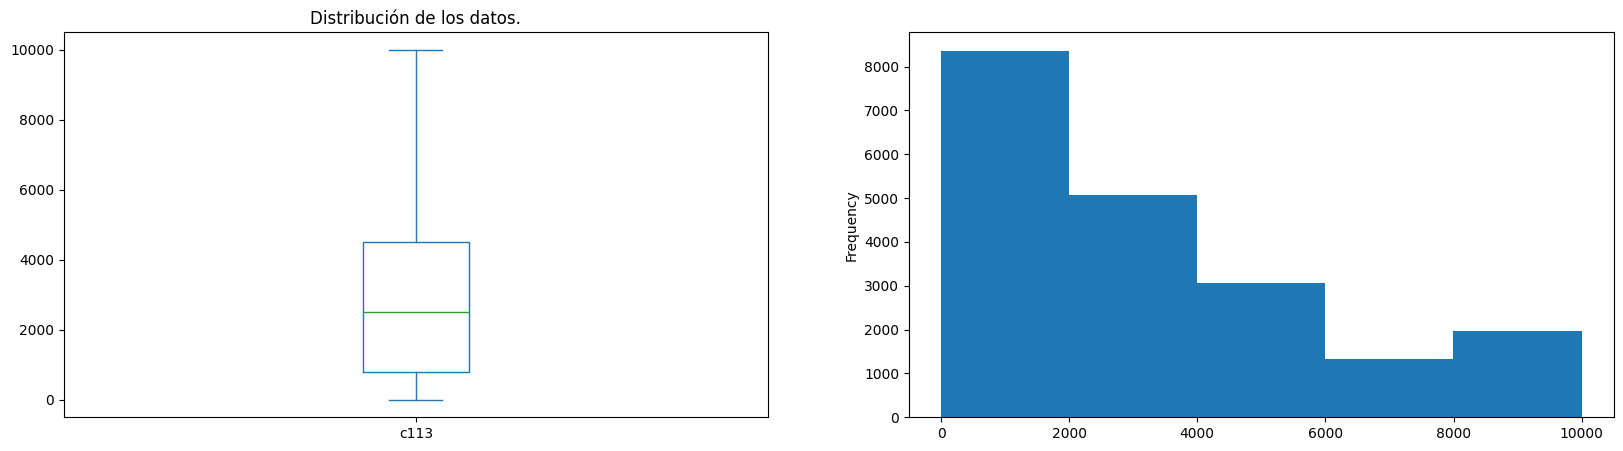

[+] SKEW	 0.9894317762650485


In [240]:
numerical_histogram(col, df, bins=5)

Teniendo en cuenta el significado de la columna, esta tiene una relacion con la columna c112, condiciones del cielo, pues sus datos representan el estado de las nubes en el momento del incidente. Además, también se tiene en cuenta las columnas de visibilidad, la c114 para la distancia de visión y c115 para el tipo de restricción. Dada esta relación, se agrupa el dataframe y se imputa los valores.

In [241]:
df[['c112', 'c114', 'c115']].nunique()

c112     5
c114    12
c115     8
dtype: int64

Teniendo en cuenta los resultados, se realiza el agrupamiento por orden de Condición del cierlo (c112)/Restricción(c115)/Distancia visión(c114).

In [242]:
# Crear los grupos en orden segun: Condición del cielo - Restriccion de vision - Distancia de visión
groups = df.groupby(['c112', 'c115', 'c114'], group_keys=False, dropna=False)

print('[+] TOTAL_GROUPS\t', groups.ngroups)
groups.median(numeric_only=True)[[col]]

[+] TOTAL_GROUPS	 492


c113
c112 c115 c114        
BRKN BLS  1     1300.0
          10     758.0
          2     1200.0
          3     2500.0
          4     8000.0
...                ...
NaN  NaN  5        NaN
          7        NaN
          8     6000.0
          9        NaN
          G10   6500.0

[492 rows x 1 columns]

Dado el sesgo que existe, se opta por realizar una imputación teniendo en cuenta la mediana.

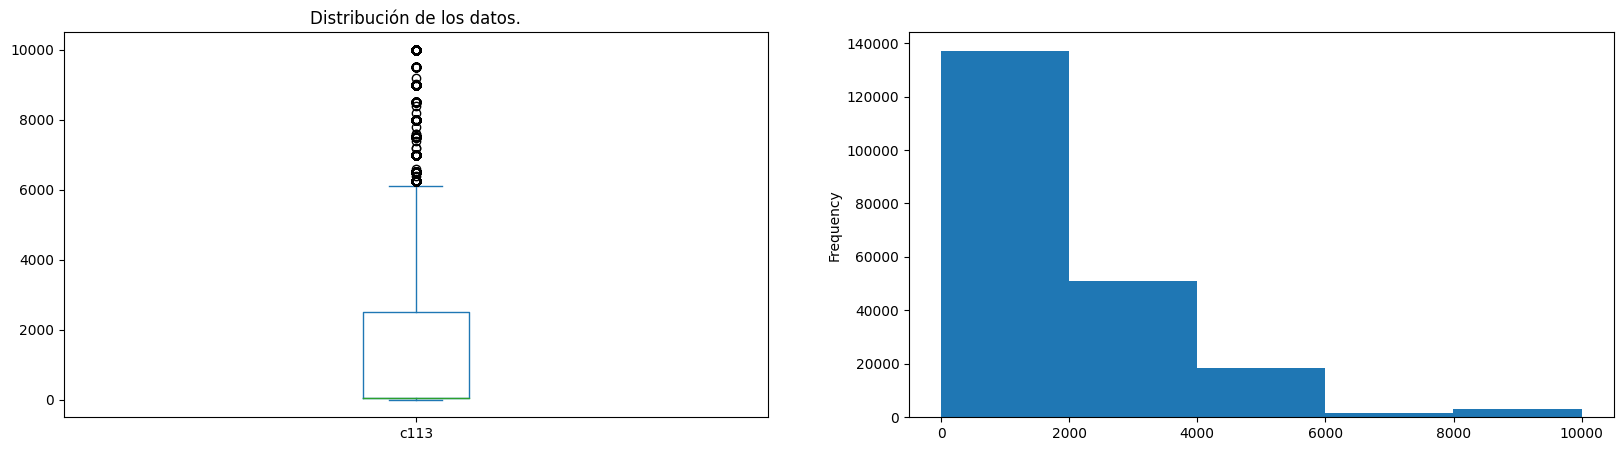

[+] SKEW	 1.5977971182771085


c113
count  211412.000000
mean     1245.399772
std      1757.779519
min         0.000000
25%        38.000000
50%        38.000000
75%      2500.000000
max      9999.000000

In [243]:
# Aplicar la imputación
df[[col]] = groups[[col]].transform(lambda group: group.fillna(group.median()))
numerical_histogram(col, df, bins=5)
df[[col]].describe()

Tras aplicar la imputación, se crea un sesgo hacia la derecha de los datos, quedando el máximo de los valores comprendidos entre 0 y 2000 pies de altura de las nubes.

<h6><div style="font-size:14px; text-align:left"><b>c114: Visibility code</b></div></h6>

In [244]:
col = 'c114'
print('[+] COL\t', col_name(col), '\n')
print('[+] NAN_VALUES\t', df[[col]].isna().sum()[0])
df[[col]].describe()

[+] COL	 Visibility code 

[+] NAN_VALUES	 126446


c114
count   88218
unique     12
top       G10
freq    48211

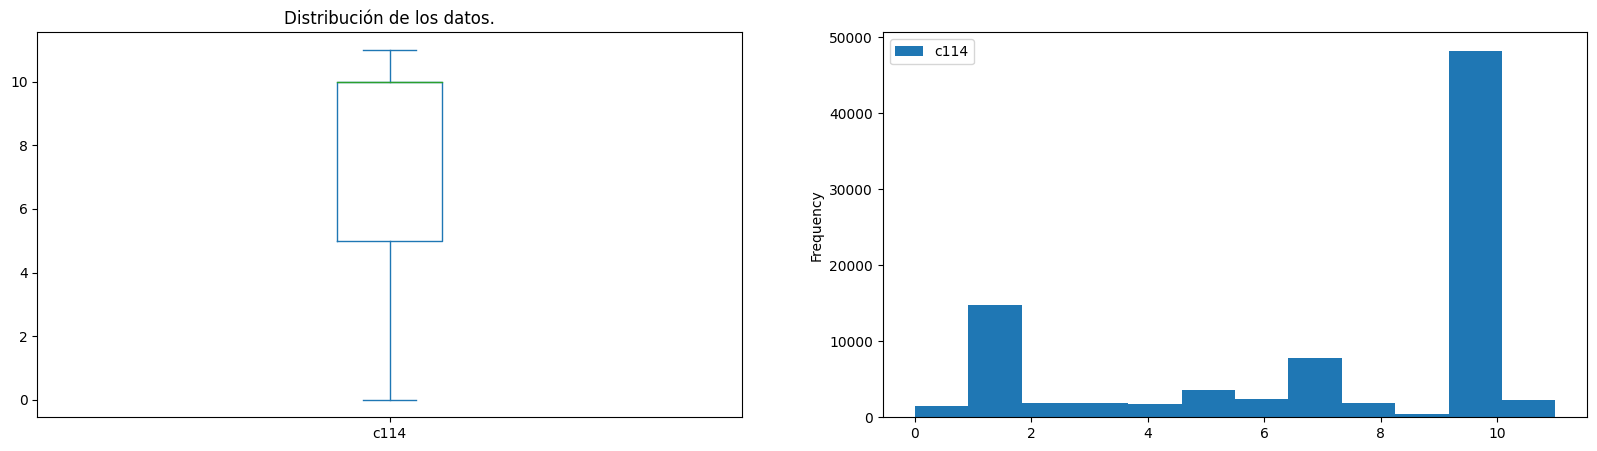

[+] VALUES_ENCODED	 ['1' '10' '2' '3' '4' '5' '6' '7' '8' '9' 'G10' 'LS1' nan]
[+] SKEW	 -0.8669808518337043


In [245]:
categorical_histogram(col, df, bins=12)

Para la codificación de estos datos, del mismo modo que con las columnas anteriores, existe una relación con una serie de columnas, en concreto con el estado del cielo (c112), el código de la luz (c110) y la restriccion de la visión (c115).

In [246]:
df[['c112', 'c110', 'c115', 'c10']].nunique()

c112     5
c110     5
c115     8
c10     24
dtype: int64

Teniendo en cuenta los resultados, se realiza el agrupamiento por orden de c110/c112/c115

In [247]:
# Convertir la columna a numérica para realizar la imputación
# Instancia del codificador
oe = preprocessing.OrdinalEncoder()
oe.fit(df[[col]])
col_encoded = oe.transform(df[[col]])

# Crear un dataframe auxiliar con los atributos y valores transformados
df[col] = col_encoded

# Crear los grupos en orden segun: Codigo de luz - Estado del cielo - Restriccion de visión
groups = df.groupby(['c110', 'c112', 'c115', 'c10'], group_keys=False, dropna=False)

print('[+] TOTAL_GROUPS\t', groups.ngroups)
groups.mean(numeric_only=True)[[col]]

[+] TOTAL_GROUPS	 1923


c114
c110 c112 c115 c10          
1    BRKN BLS  08   2.000000
               09   0.500000
               10   4.333333
               11   5.500000
               13   4.000000
...                      ...
NaN  NaN  SNO  21   1.000000
               NaN  1.000000
          NaN  06   9.000000
               11   7.000000
               12   7.000000

[1923 rows x 1 columns]

Por el sesgo cercano a la unidad, se decide realizar una imputación teniendo en cuenta la mediana.

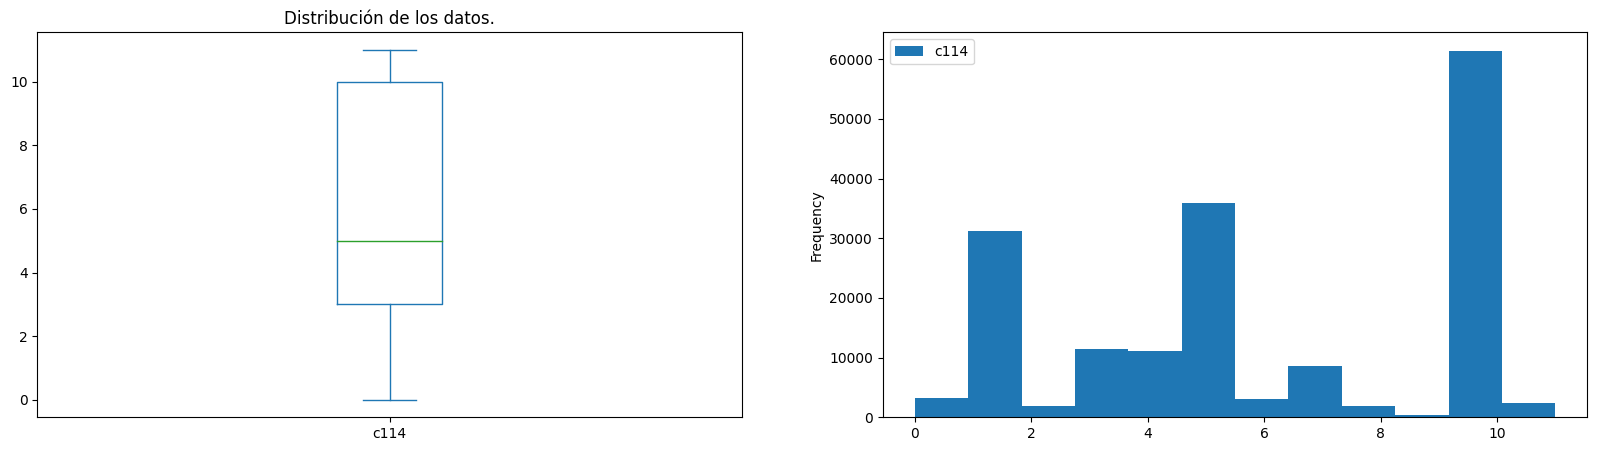

[+] VALUES_ENCODED	 ['1' '10' '2' '3' '4' '5' '6' '7' '8' '9' 'G10' 'LS1' nan]
[+] SKEW	 -0.09598177411282555


c114
count   172819
unique      12
top        G10
freq     61447

In [248]:
# Aplicar la imputación
df[[col]] = groups[[col]].transform(lambda group: group.fillna(group.median()))
# df[[col]] = groups[[col]].transform(lambda group: group.fillna(round(group.mean(), 0)))

# Devolver los valores a su categoria
df[[col]] = oe.inverse_transform(df[[col]])

# Presentar datos
categorical_histogram(col, df, bins=12)
df[[col]].describe()

Tras la imputación, se mantiene el sesgo hacia la izquierda pero este queda practicamente 0.

<h6><div style="font-size:14px; text-align:left"><b>c112: Sky condition code</b></div></h6>

In [249]:
col = 'c112'
print('[+] COL\t', col_name(col), '\n')
print('[+] NAN_VALUES\t', df[[col]].isna().sum()[0])
df[[col]].describe()

[+] COL	 Sky condition code 

[+] NAN_VALUES	 124369


c112
count   90295
unique      5
top      CLER
freq    40716

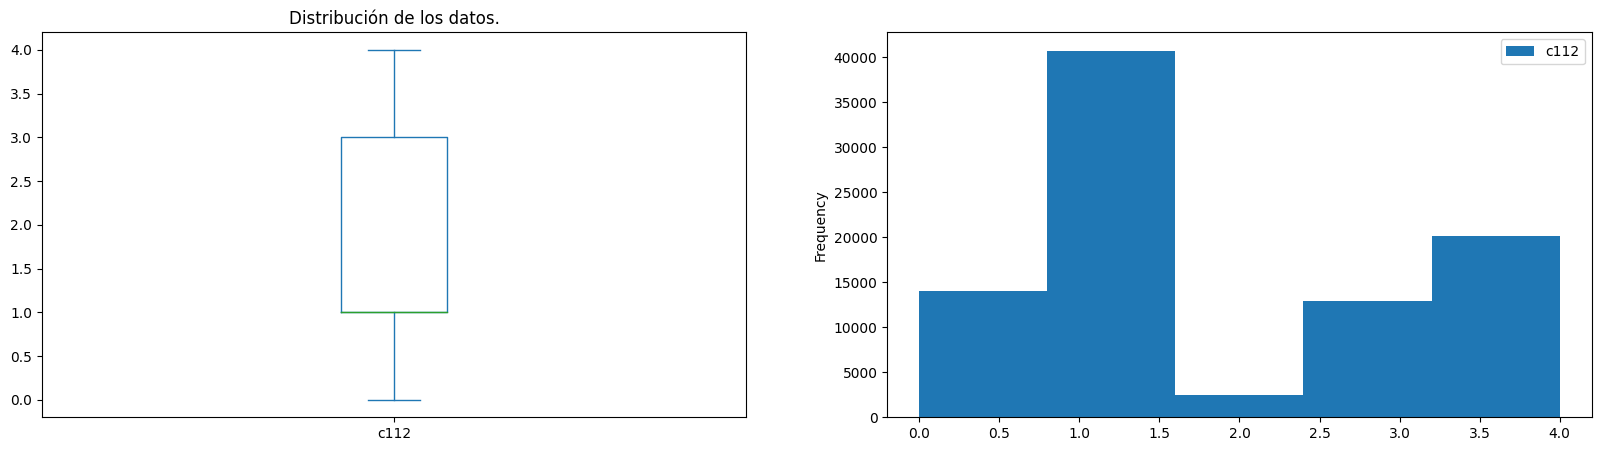

[+] VALUES_ENCODED	 ['BRKN' 'CLER' 'OBSC' 'OCST' 'SCAT' nan]
[+] SKEW	 0.4390215717801383


In [250]:
categorical_histogram(col, df, bins=5)

Teniendo en cuenta el significado de la columna, esta tiene una relacion con las columnas de vibilidad, la c114 para la distancia de visión y c115 para el tipo de restricción. Dada esta relación, se agrupa el dataframe y se imputa los valores

In [251]:
df[['c114', 'c115']].nunique()

c114    12
c115     8
dtype: int64

Teniendo en cuenta los resultados, se realiza el agrupamiento por orden de Restricción(c115)/Distancia visión(c114).

In [252]:
# Convertir la columna a numérica para realizar la imputación
# Instancia del codificador
oe = preprocessing.OrdinalEncoder()
oe.fit(df[[col]])
col_encoded = oe.transform(df[[col]])

# Crear un dataframe auxiliar con los atributos y valores transformados
df[col] = col_encoded

# Crear los grupos en orden segun: Restriccion de vision - Distancia de visión
groups = df.groupby(['c115', 'c114'], group_keys=False, dropna=False)

print('[+] TOTAL_GROUPS\t', groups.ngroups)
groups.median(numeric_only=True)[[col]]

[+] TOTAL_GROUPS	 111


c112
c115 c114      
BLS  1      2.0
     10     3.0
     2      3.0
     3      3.0
     4      2.0
...         ...
NaN  8      3.5
     9      1.0
     G10    1.0
     LS1    3.5
     NaN    4.0

[111 rows x 1 columns]

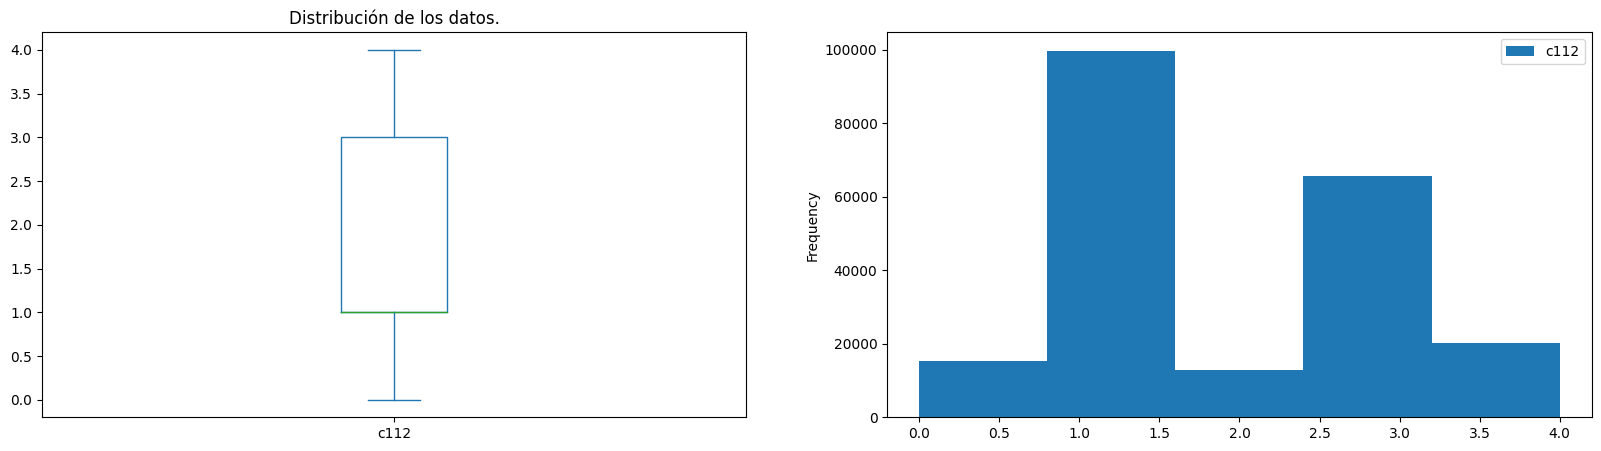

[+] VALUES_ENCODED	 ['BRKN' 'CLER' 'OBSC' 'OCST' 'SCAT' nan]
[+] SKEW	 0.29928249900791304


c112
count   214095
unique       5
top       CLER
freq     99805

In [253]:
# Aplicar la imputación
df[[col]] = groups[[col]].transform(lambda group: group.fillna(group.median()))

# Devolver los valores a su categoria
df[[col]] = oe.inverse_transform(df[[col]])
categorical_histogram(col, df, bins=5)
df[[col]].describe()

Tras la imputación se observa que el sesgo que existía, se ha reducido en 0.2 puntos.

<h6><div style="font-size:14px; text-align:left"><b>c110: Light condition code</b></div></h6>

In [254]:
col = 'c110'
print('[+] COL\t', col_name(col), '\n')
print('[+] NAN_VALUES\t', df[[col]].isna().sum()[0])
df[[col]].describe()

[+] COL	 Light condition code 

[+] NAN_VALUES	 46195


c110
count   168469
unique       5
top          1
freq    140457

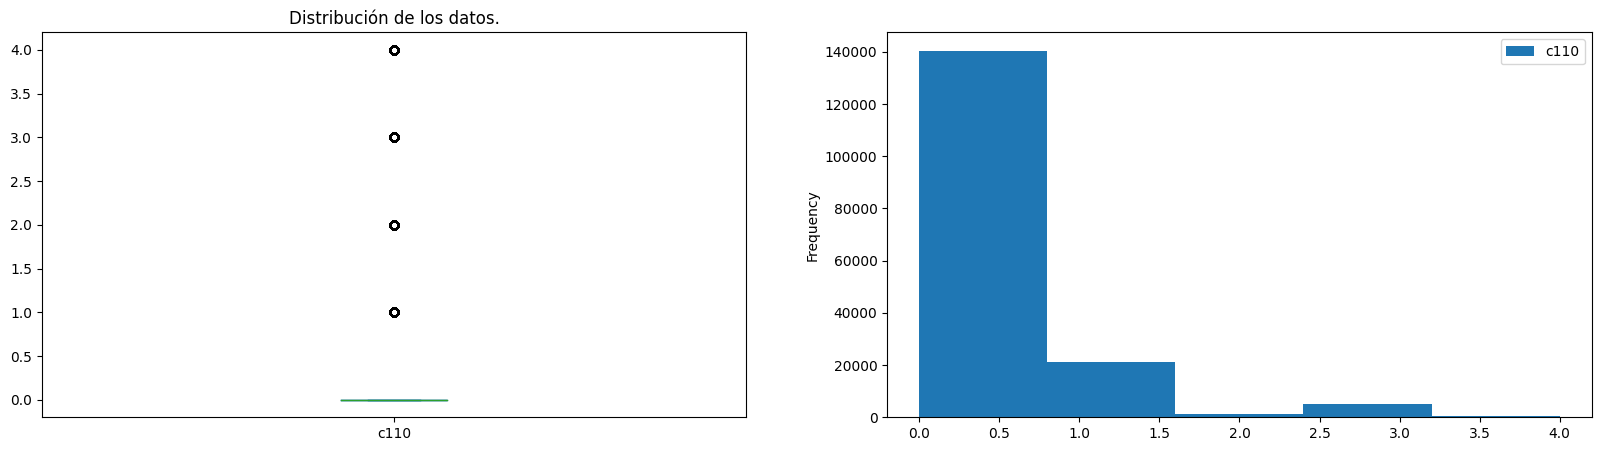

[+] VALUES_ENCODED	 ['1' '2' '3' '4' '5' nan]
[+] SKEW	 3.2817021176777317


In [255]:
categorical_histogram(col, df, bins=5)

Para la imputación, se agrupa el dataframe por las horas del accidente, se tiene en cuenta esta vez la hora del accidente que previamente ha sido imnputado de acuerdo con esta columna.<br>
Debido al sesgo que existe en los valores, se realiza una imputación teniendo en cuenta la mediana.

In [256]:
df[['c10', 'c112', 'c114', 'c115']].nunique()

c10     24
c112     5
c114    12
c115     8
dtype: int64

In [257]:
# Convertir la columna a numérica para realizar la imputación
# Instancia del codificador
oe = preprocessing.OrdinalEncoder()
oe.fit(df[[col]])
col_encoded = oe.transform(df[[col]])

# Crear un dataframe auxiliar con los atributos y valores transformados
df[col] = col_encoded

# Crear los grupos en orden según la fase del dia
groups = df.groupby(['c112', 'c115', 'c114', 'c10'], group_keys=False, dropna=False)

print('[+] TOTAL_GROUPS\t', groups.ngroups)
groups.median(numeric_only=True)[[col]]

[+] TOTAL_GROUPS	 3847


c110
c112 c115 c114 c10      
BRKN BLS  1    09    0.0
               14    0.0
               18    0.5
          10   09    0.0
               14    0.0
...                  ...
NaN  DST  NaN  19    2.0
               20    2.0
               21    2.0
               23    2.0
               NaN   2.0

[3847 rows x 1 columns]

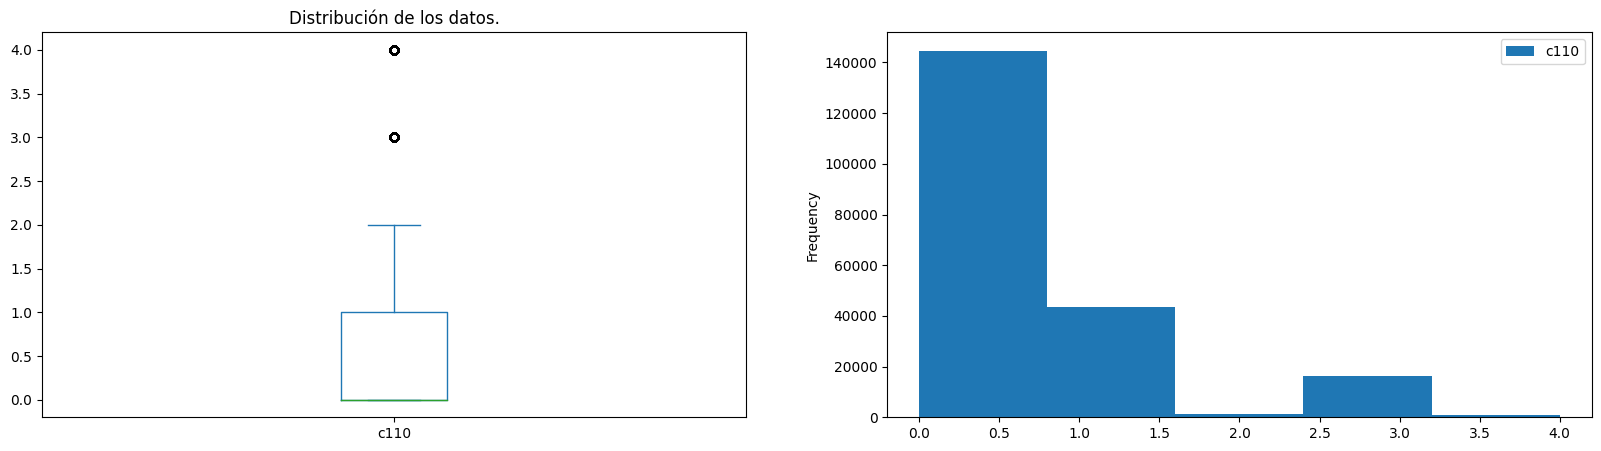

[+] VALUES_ENCODED	 ['1' '2' '3' '4' '5' nan]
[+] SKEW	 2.0449296776923815


c110
count   206582
unique       5
top          1
freq    144679

In [258]:
# Aplicar la imputación para cada grupo
df[[col]] = groups[[col]].transform(lambda group: group.fillna(group.median()))

# Devolver los valores a su categoria
df[[col]] = oe.inverse_transform(df[[col]])

# Representacion de los datos
categorical_histogram(col, df, bins=5)
df[[col]].describe(include='all')

Tras la imputación, se ha bajado el sesgo en más de 1 punto.

<h5><div style="font-size:14px; text-align:left"><b>HORA DEL INCIDENTE</b><br></div></h5>

In [259]:
col = 'c10'
print('[+] COL\t', col_name(col), '\n')
print('[+] NAN_VALUES\t', df[[col]].isna().sum()[0])
df[[col]].describe(include='all')

[+] COL	 Local time of the accident/incident. 

[+] NAN_VALUES	 25668


c10
count   188996
unique      24
top         15
freq     16812

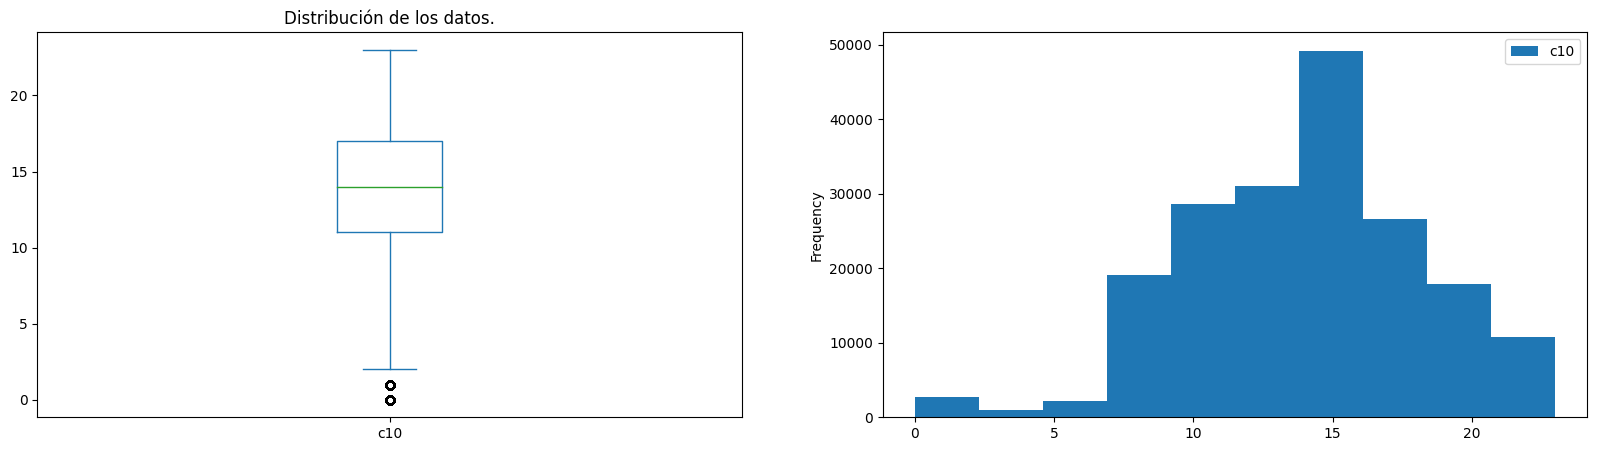

[+] VALUES_ENCODED	 ['00' '01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13'
 '14' '15' '16' '17' '18' '19' '20' '21' '22' '23' nan]
[+] SKEW	 -0.32542124023620517


c10
count   188996
unique      24
top         15
freq     16812

In [260]:
categorical_histogram(col, df)
df[[col]].describe()

Para la imputación, se tiene en cuenta la condición luminica del cielo, c110, ya que sus datos indican en que fase del dia se produce el incidente. Para dicho proceso, se agrupa los datos según la c110.<br>
Commo método de imputación, se decide realizar la mediana dada la distribución de los datos, por lo tanto, previamente se debe convertir la columna como numérica.

In [261]:
# Convertir la columna a numérica
df[col] = df[col].astype(float)

# Crear los grupos en orden según la fase del dia
groups = df.groupby(['c110'], group_keys=False, dropna=False)

print('[+] TOTAL_GROUPS\t', groups.ngroups)
groups.median(numeric_only=True)[[col]]

[+] TOTAL_GROUPS	 6


c10
c110      
1     14.0
2     14.0
3      7.0
4     15.0
5     15.0
NaN   18.0

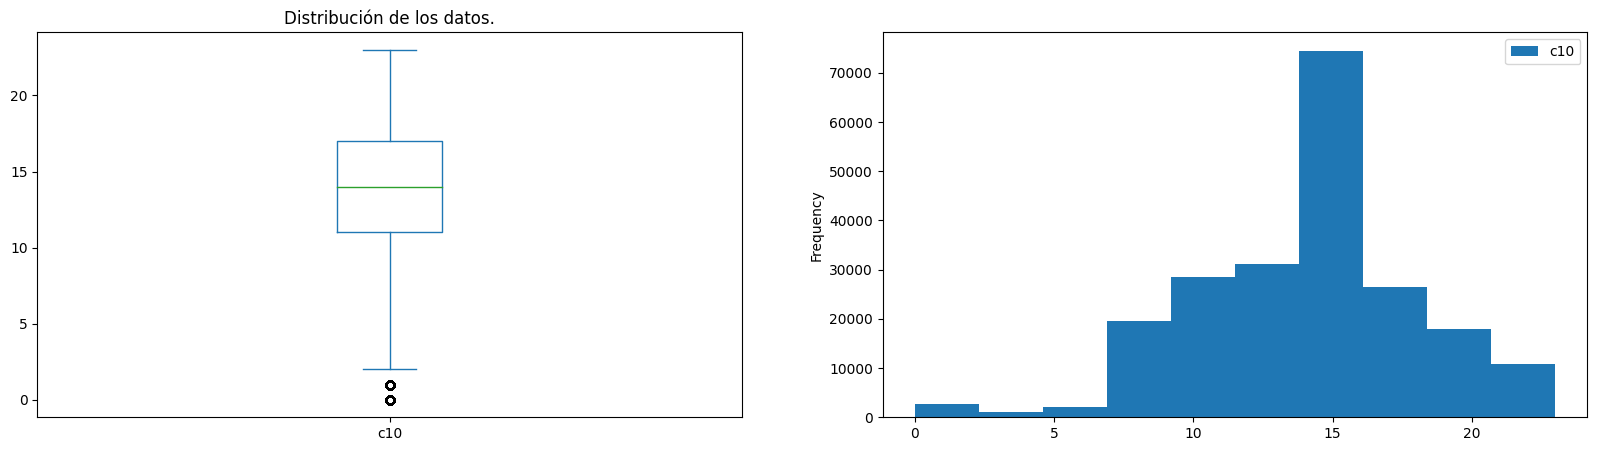

[+] VALUES_ENCODED	 ['00' '01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13'
 '14' '15' '16' '17' '18' '19' '20' '21' '22' '23']
[+] SKEW	 -0.3576212833234302


c10
count   214664
unique      24
top         14
freq     37604

In [262]:
# Aplicar la imputación para cada grupo
df[[col]] = groups[[col]].transform(lambda group: group.fillna(group.median()))

# Convertir la columna a categorica de nuevo dejando las horas en formato HH
df[col] = df[col].astype(int).astype(str)
df[col] = df[[col]].applymap(lambda x: x.zfill(2))

# Representacion de los datos
categorical_histogram(col, df)
df[[col]].describe(include='all')

Tras la imputación de los datos, se observa que el sego a la izquierda ha crecido 0.02 puntos y que el registro con mayor incidencia es el de la hora 14.

<h5><div style="font-size:14px; text-align:left"><b>CONCLUSION</b></div></h5>

In [ ]:
plot_nan(df)

<h4><div style="font-size:14px; text-align:center"><b>CODIFICACIÓN DE DATOS CATEGÓRICOS</b><br></div></h4>

Existe una serie de columnas con datos categóricos que se deberá de codificar para poder tratar sus datos y realizar nuestra prediccion del modelo.<br>
Hasta ahora se ha trabajado con las columnas categóricas y numéricas em base a sus datos, pero, para realizar la codificación necesaria, se va a realizar sobre todas las columnas que necesariamente serán categóricas para realizar el modelo.<br>
Existe tres técnicas de Data Encoding dependiendo de las carácteristicas de los atributos:<br>
- OrdinalEncoder: Para caracteristicas de tipo imput. Devuelve una unica columna que va de 1 a n_caracteristicas-1 
- LabelEncoder: Para la caracteristica objetivo (target) devolviendo una columna de 1 a n_caracteristicas-1
- OneHotEncoder: Devuelve una columna para cada atributo codificado, indicando 0 o 1 según la presencia de la carateristica para cada registro.<br>

Teniendo en cuenta estas caracteristicas, se decide emplear OrdinalEncoder en lugar de OneHotEncoder para los inputs dado el gran número de características que existe por atributo categórico. Para la predicción, se empleará LabelEncoder.

In [ ]:
STOP

- **LOS ESTADOS DEL VUELO; HAY QUE MODIFICARLOS PARA QUE SEA VOLANDO; DESPEGANDO; ATERRIZANDO O EN TIERRA**